In [109]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="darkgrid", palette="muted", rc={"figure.figsize": (10, 6)})

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report, confusion_matrix

# Classifier Model

I am using a CIFAR 10 dataset from https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/data. The data is 32x32x3 images 100K of which are train data and 20K are test data. They are split equally by Real and Fake images.

The model I will use will be a simple implementation of a ResNet18 model. I change the convolution layer and the pooling layer to account for the size of my images. The latter in particular is not pooled due to the size already being 32x32.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


train_data = datasets.ImageFolder('dataset/train/', transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.ImageFolder('dataset/test/', transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print("Class mapping:", train_data.class_to_idx)

Class mapping: {'FAKE': 0, 'REAL': 1}


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(num_classes=2)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", ncols=200):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%")


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:57<00:00,  8.83it/s]


Epoch [1/10] - Loss: 0.2355 - Train Accuracy: 90.28%


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [02:16<00:00, 11.42it/s]


Epoch [2/10] - Loss: 0.1401 - Train Accuracy: 94.63%


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [03:56<00:00,  6.61it/s]


Epoch [3/10] - Loss: 0.0998 - Train Accuracy: 96.13%


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:56<00:00, 27.51it/s]


Epoch [4/10] - Loss: 0.0649 - Train Accuracy: 97.58%


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:56<00:00, 27.75it/s]


Epoch [5/10] - Loss: 0.0449 - Train Accuracy: 98.33%


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:57<00:00, 26.97it/s]


Epoch [6/10] - Loss: 0.0352 - Train Accuracy: 98.72%


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.71it/s]


Epoch [7/10] - Loss: 0.0296 - Train Accuracy: 98.91%


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.27it/s]


Epoch [8/10] - Loss: 0.0257 - Train Accuracy: 99.06%


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.19it/s]


Epoch [9/10] - Loss: 0.0227 - Train Accuracy: 99.16%


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:56<00:00, 27.82it/s]


Epoch [10/10] - Loss: 0.0202 - Train Accuracy: 99.27%


In [11]:
torch.save(model.state_dict(), 'resnet18_cifar_model.pth')
print("Model saved to resnet18_cifar_model.pth")

Model saved to resnet18_cifar_model.pth


In [ ]:
# Model Loader
# Works by resetting the resnet18 model and then loading

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(num_classes=2)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

model.load_state_dict(torch.load('resnet18_cifar_model.pth', map_location=device))
model.to(device)
model.eval()

print("Model loaded.")

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.93      0.96      0.95     10000
        REAL       0.96      0.93      0.94     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9584  416]
 [ 679 9321]]


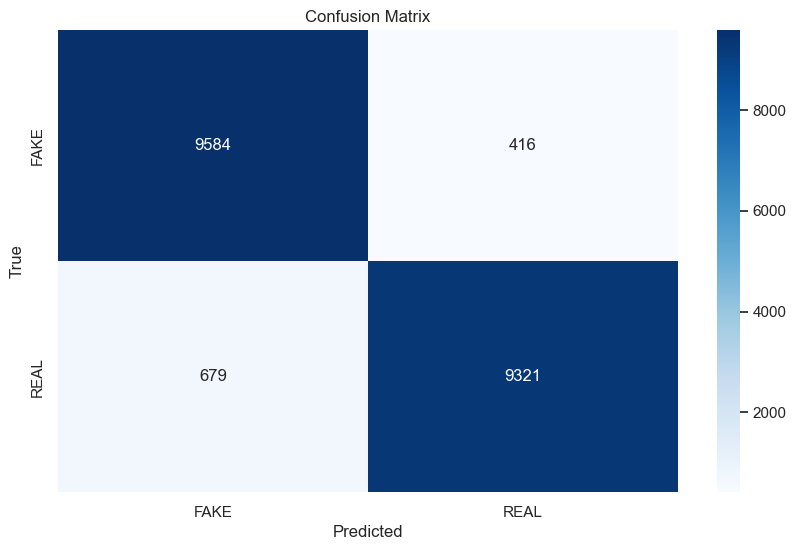

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_data.classes))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_data.classes, yticklabels=test_data.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

I'm actually quite surprised with these results already. I wasn't actually expecting such high performance with so little tweaking, but I will take it.

# XAI

My goal here is to explore XAI methods to explain why my classifier chose the answers it did for the images. In particular I want to understand the places where it got the classification wrong.

Methods?

Need to check out output meaning and how to do it in bulk. Also look at a sampling of correct predictions and wrong predictions for fake and real images.


## Grad-CAM and Captum

In [110]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


In [111]:
# Reloading architecture

model = models.resnet18(num_classes=2)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

model.load_state_dict(torch.load('resnet18_cifar_model.pth', map_location='cpu'))
model.eval()

C:\Users\dblan\AppData\Local\Temp\ipykernel_1496\3151879818.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_cifar_model.pth', 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [13]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

img = Image.open("./dataset/test/FAKE/0 (8).jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0)
input_tensor.requires_grad_()

tensor([[[[0.0078, 0.0039, 0.0039,  ..., 0.0275, 0.0196, 0.0157],
          [0.0157, 0.0118, 0.0078,  ..., 0.0784, 0.0588, 0.0471],
          [0.0078, 0.0078, 0.0039,  ..., 0.1608, 0.1333, 0.1176],
          ...,
          [0.3255, 0.3176, 0.3020,  ..., 0.0784, 0.1020, 0.1176],
          [0.3059, 0.3098, 0.2980,  ..., 0.0824, 0.1059, 0.1176],
          [0.2078, 0.2431, 0.2745,  ..., 0.0784, 0.0706, 0.0706]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0235, 0.0157, 0.0118],
          [0.0118, 0.0078, 0.0039,  ..., 0.0745, 0.0549, 0.0431],
          [0.0039, 0.0039, 0.0000,  ..., 0.1569, 0.1294, 0.1137],
          ...,
          [0.3098, 0.3020, 0.2863,  ..., 0.0745, 0.0980, 0.1137],
          [0.2902, 0.2941, 0.2824,  ..., 0.0784, 0.1020, 0.1137],
          [0.1922, 0.2275, 0.2588,  ..., 0.0745, 0.0667, 0.0667]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0078, 0.0039],
          [0.0039, 0.0000, 0.0000,  ..., 0.0667, 0.0471, 0.0353],
          [0.0000, 0.0000, 0.0000,  ..., 0

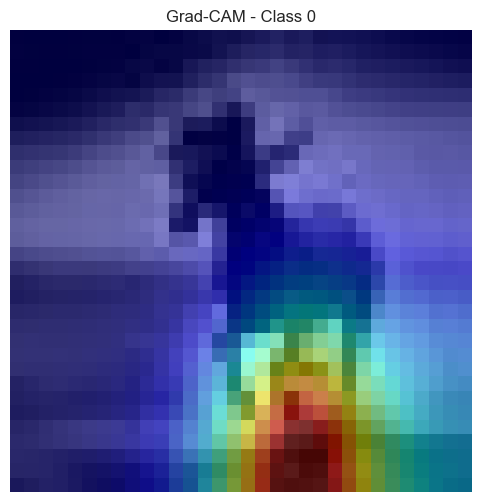

In [9]:
cam_extractor = GradCAM(model, target_layer="layer4")


out = model(input_tensor)
pred_class = out.argmax().item()


activation_map = cam_extractor(pred_class, out)


result = overlay_mask(to_pil_image(input_tensor.squeeze()), 
                      to_pil_image(activation_map[0].squeeze(), mode='F'), alpha=0.5)

plt.imshow(result)
plt.title(f"Grad-CAM - Class {pred_class}")
plt.axis('off')
plt.show()

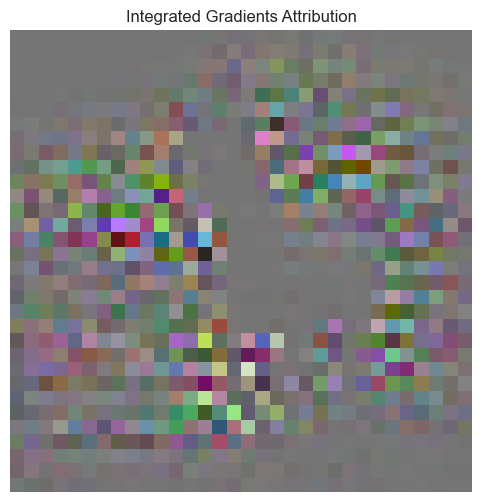

In [33]:
from captum.attr import IntegratedGradients
import numpy as np

ig = IntegratedGradients(model)

# Define a baseline (black image)
baseline = torch.zeros_like(input_tensor)

# Get attributions for predicted class
attributions, _ = ig.attribute(input_tensor, baseline, target=pred_class, return_convergence_delta=True)

# Visualization
def visualize_attr(attributions):
    attr = attributions.squeeze().detach().numpy()
    attr = np.transpose(attr, (1, 2, 0))  # CHW → HWC
    attr = (attr - attr.min()) / (attr.max() - attr.min())
    plt.imshow(attr)
    plt.title("Integrated Gradients Attribution")
    plt.axis('off')
    plt.show()

visualize_attr(attributions)

## LIME and SHAP

In [23]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np

  0%|          | 0/1000 [00:00<?, ?it/s]

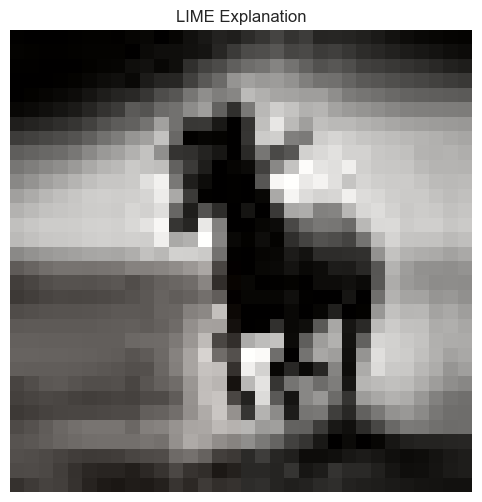

In [24]:
# Note need to restart kernal to run this so TorchCAM doesn't conflict

def predict_numpy(images):
    model.eval()
    images = torch.tensor(np.transpose(images, (0, 3, 1, 2)), dtype=torch.float32)
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
        probs = torch.nn.functional.softmax(output, dim=1).cpu().numpy()
    return probs

device = torch.device("cpu")

img = Image.open("./dataset/test/FAKE/0 (8).jpg").convert("RGB")
img = img.resize((32, 32))
img_np = np.array(img)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_np, 
    predict_numpy, 
    top_labels=2, 
    hide_color=0, 
    num_samples=1000
)

from matplotlib import pyplot as plt

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()

In [25]:
pip install shap

   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ----- ---------------------------------- 71.7/545.2 kB 2.0 MB/s eta 0:00:01
   --------------- ------------------------ 204.8/545.2 kB 2.5 MB/s eta 0:00:01
   ------------------------ --------------- 337.9/545.2 kB 2.6 MB/s eta 0:00:01
   --------------------------------- ------ 450.6/545.2 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 545.2/545.2 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
import shap

In [38]:
device = "cpu"

model.eval()
model.to(device)

img = Image.open("./dataset/test/FAKE/0 (8).jpg").convert("RGB")
img = img.resize((32, 32))
img_tensor = transform(img).unsqueeze(0).to(device)

background = torch.zeros((1, 3, 32, 32)).to(device)

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(img_tensor)

shap.image_plot(shap_values, np.transpose(img_tensor.cpu().numpy(), (0, 2, 3, 1)))

RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

## Proper Test Setup

Idea will be to get a random sampling of real and fake images correctly and incorrectly classified. Probably 10 of each, so 40 overall.

In [112]:
# Model Loader
# Works by resetting the resnet18 model and then loading

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(num_classes=2)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

model.load_state_dict(torch.load('resnet18_cifar_model.pth', map_location=device))
model.to(device)
model.eval()

print("Model loaded.")

C:\Users\dblan\AppData\Local\Temp\ipykernel_1496\1928388203.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_cifar_model.pth',

Model loaded.


Classification Report:
               precision    recall  f1-score   support

        FAKE       0.93      0.96      0.95     10000
        REAL       0.96      0.93      0.94     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Confusion Matrix:
 [[9584  416]
 [ 679 9321]]


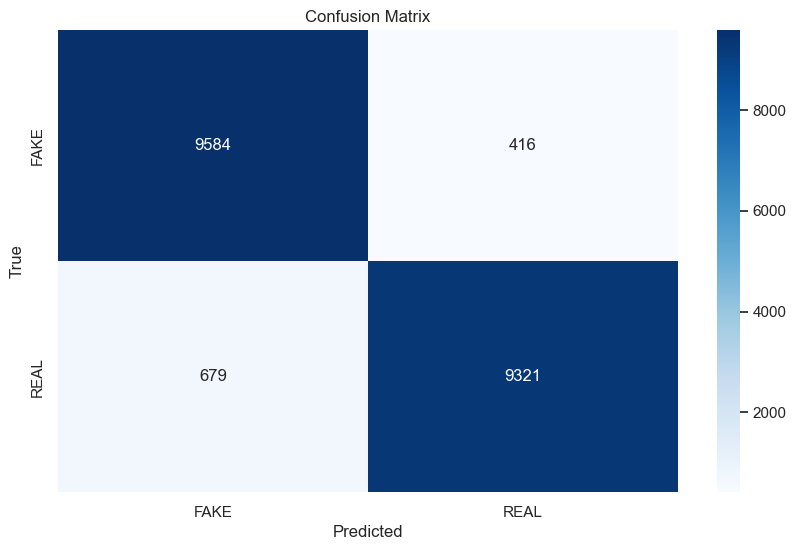

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_data.classes))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_data.classes, yticklabels=test_data.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Lists of different categories for comparison.
# nameing key is true_pred. So fake_real for example is a fake image predicted as a real one.

fake_fake = []
fake_real = []
real_fake = []
real_real = []

for i in range(len(y_true)):
    if y_true[i] == 0:
        if y_pred[i] == 0:
            fake_fake.append(i)
        else:
            fake_real.append(i)
            
    else:
        if y_pred[i] == 0:
            real_fake.append(i)
        else:
            real_real.append(i)



In [11]:
print(len(fake_fake))
print(len(fake_real))
print(len(real_fake))
print(len(real_real))

9584
416
679
9321


In [15]:
import random

selected_fake_fake = random.choices(fake_fake, k=10)
print(selected_fake_fake)

selected_fake_real = random.choices(fake_real, k=10)
print(selected_fake_real)

selected_real_fake = random.choices(real_fake, k=10)
print(selected_real_fake)

selected_real_real = random.choices(real_real, k=10)
print(selected_real_real)

[7786, 4154, 7433, 6008, 6116, 9227, 7506, 5958, 1121, 1465]
[6284, 5792, 3692, 212, 6875, 5687, 2131, 4870, 2465, 4132]
[13949, 11212, 18791, 11152, 16471, 19542, 18931, 18764, 15377, 11623]
[19865, 18531, 10577, 18205, 13565, 16712, 10323, 15840, 15348, 16320]


In [12]:
selected_fake_fake = [7786, 4154, 7433, 6008, 6116, 9227, 7506, 5958, 1121, 1465]
selected_fake_real = [6284, 5792, 3692, 212, 6875, 5687, 2131, 4870, 2465, 4132]
selected_real_fake = [13949, 11212, 18791, 11152, 16471, 19542, 18931, 18764, 15377, 11623]
selected_real_real = [19865, 18531, 10577, 18205, 13565, 16712, 10323, 15840, 15348, 16320]

In [23]:
y_pred[6284]

1

In [24]:
y_true[6284]

0

In [13]:
test_data.samples[6284][0]

'dataset/test/FAKE\\664 (5).jpg'

In [49]:
test_data.samples[6280:6290]

[('dataset/test/FAKE\\664 (10).jpg', 0),
 ('dataset/test/FAKE\\664 (2).jpg', 0),
 ('dataset/test/FAKE\\664 (3).jpg', 0),
 ('dataset/test/FAKE\\664 (4).jpg', 0),
 ('dataset/test/FAKE\\664 (5).jpg', 0),
 ('dataset/test/FAKE\\664 (6).jpg', 0),
 ('dataset/test/FAKE\\664 (7).jpg', 0),
 ('dataset/test/FAKE\\664 (8).jpg', 0),
 ('dataset/test/FAKE\\664 (9).jpg', 0),
 ('dataset/test/FAKE\\664.jpg', 0)]

In [50]:
test_data.samples[6280+10360:6290+10360]

[('dataset/test/REAL\\0664 (10).jpg', 1),
 ('dataset/test/REAL\\0664 (2).jpg', 1),
 ('dataset/test/REAL\\0664 (3).jpg', 1),
 ('dataset/test/REAL\\0664 (4).jpg', 1),
 ('dataset/test/REAL\\0664 (5).jpg', 1),
 ('dataset/test/REAL\\0664 (6).jpg', 1),
 ('dataset/test/REAL\\0664 (7).jpg', 1),
 ('dataset/test/REAL\\0664 (8).jpg', 1),
 ('dataset/test/REAL\\0664 (9).jpg', 1),
 ('dataset/test/REAL\\0664.jpg', 1)]

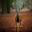

In [39]:
img_test = Image.open(test_data.samples[6284][0]).convert("RGB")
img_test

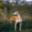

In [40]:
img_test1 = Image.open(test_data.samples[6284+10360][0]).convert("RGB")
img_test1

In [38]:
test_data.samples[6284+10360][0]

'dataset/test/REAL\\0664 (5).jpg'

In [19]:
len(test_data.samples)

20000

In [25]:
test_data.samples[-1][0]

'dataset/test/REAL\\0999.jpg'

In [28]:
test_data.samples[selected_fake_real[0]][0]

'dataset/test/FAKE\\664 (5).jpg'

In [33]:
test_data.samples[selected_fake_fake[0]][0]

'dataset/test/FAKE\\8 (7).jpg'

In [22]:
test_data.samples

[('dataset/test/FAKE\\0 (10).jpg', 0),
 ('dataset/test/FAKE\\0 (2).jpg', 0),
 ('dataset/test/FAKE\\0 (3).jpg', 0),
 ('dataset/test/FAKE\\0 (4).jpg', 0),
 ('dataset/test/FAKE\\0 (5).jpg', 0),
 ('dataset/test/FAKE\\0 (6).jpg', 0),
 ('dataset/test/FAKE\\0 (7).jpg', 0),
 ('dataset/test/FAKE\\0 (8).jpg', 0),
 ('dataset/test/FAKE\\0 (9).jpg', 0),
 ('dataset/test/FAKE\\0.jpg', 0),
 ('dataset/test/FAKE\\1 (10).jpg', 0),
 ('dataset/test/FAKE\\1 (2).jpg', 0),
 ('dataset/test/FAKE\\1 (3).jpg', 0),
 ('dataset/test/FAKE\\1 (4).jpg', 0),
 ('dataset/test/FAKE\\1 (5).jpg', 0),
 ('dataset/test/FAKE\\1 (6).jpg', 0),
 ('dataset/test/FAKE\\1 (7).jpg', 0),
 ('dataset/test/FAKE\\1 (8).jpg', 0),
 ('dataset/test/FAKE\\1 (9).jpg', 0),
 ('dataset/test/FAKE\\1.jpg', 0),
 ('dataset/test/FAKE\\10 (10).jpg', 0),
 ('dataset/test/FAKE\\10 (2).jpg', 0),
 ('dataset/test/FAKE\\10 (3).jpg', 0),
 ('dataset/test/FAKE\\10 (4).jpg', 0),
 ('dataset/test/FAKE\\10 (5).jpg', 0),
 ('dataset/test/FAKE\\10 (6).jpg', 0),
 ('dataset/

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])



img = Image.open(test_data.samples[6284][0]).convert("RGB")
input_tensor = transform(img).unsqueeze(0)
input_tensor.requires_grad_()

In [51]:
def cam_mapper(model, image):

    model.to('cpu')
    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
        ])



    img = Image.open(image).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)
    input_tensor.requires_grad_()
    
    cam_extractor = GradCAM(model, target_layer="layer4")


    out = model(input_tensor)
    pred_class = out.argmax().item()

    
    activation_map = cam_extractor(pred_class, out)

    original_img = to_pil_image(input_tensor.cpu().squeeze())
    cam_overlay = overlay_mask(original_img, to_pil_image(activation_map[0].squeeze(), mode='F'), alpha=0.5)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(cam_overlay)
    axs[1].set_title(f"Grad-CAM - Class {pred_class}")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    
    # plt.imshow(result)
    # plt.title(f"Grad-CAM - Class {pred_class}")
    # plt.axis('off')
    # plt.show()

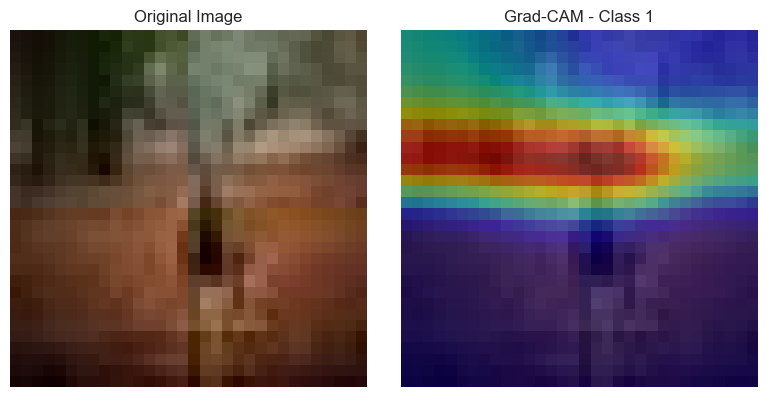

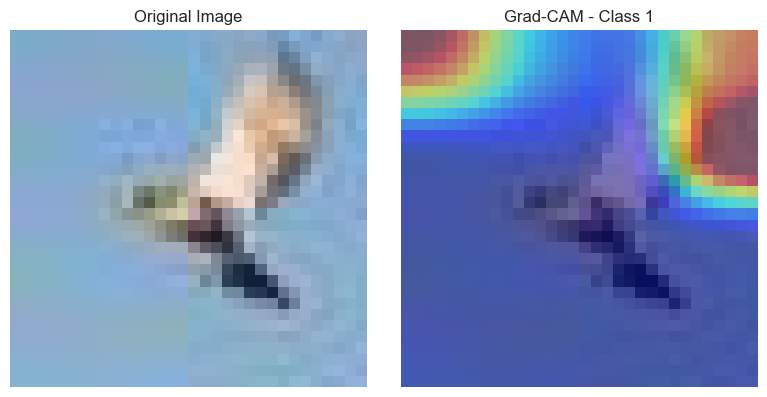

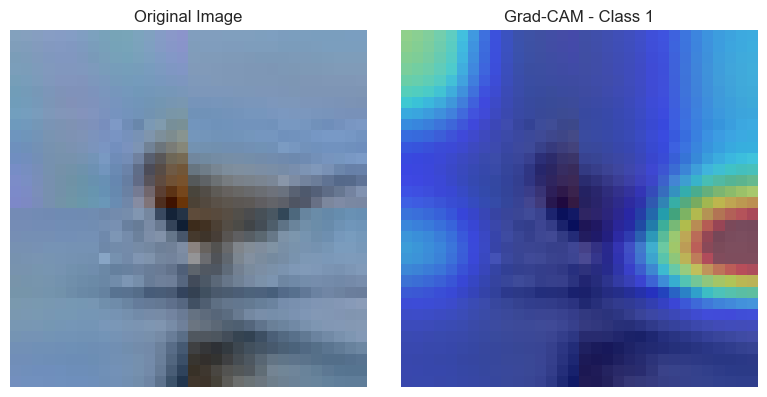

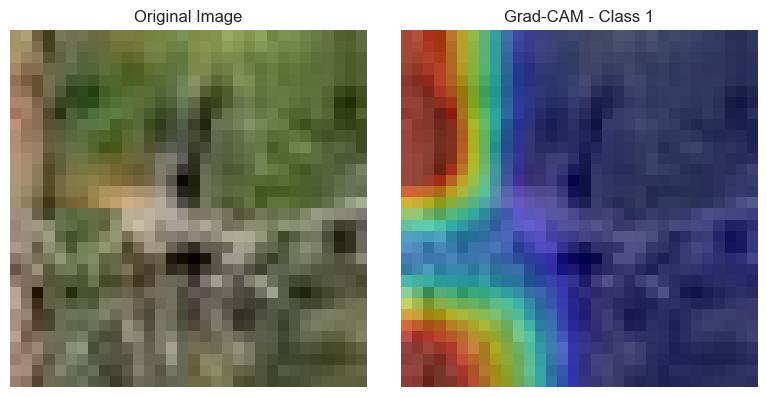

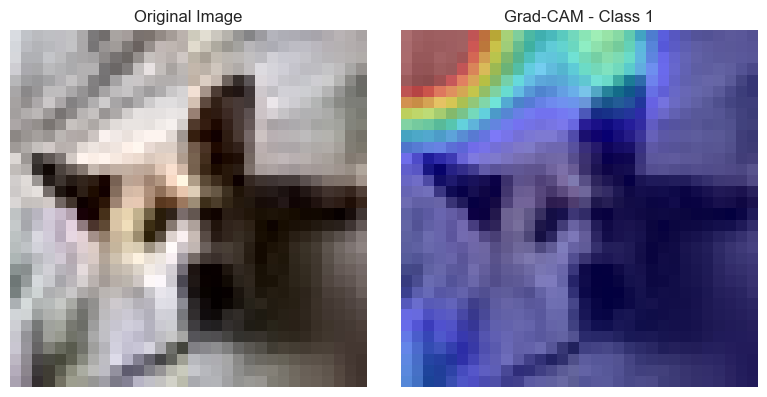

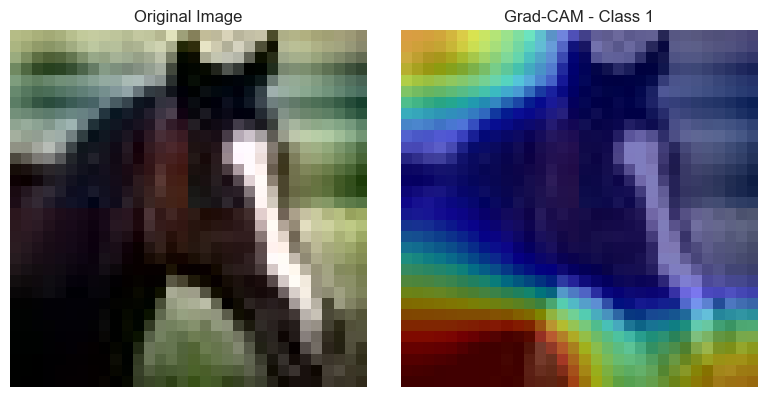

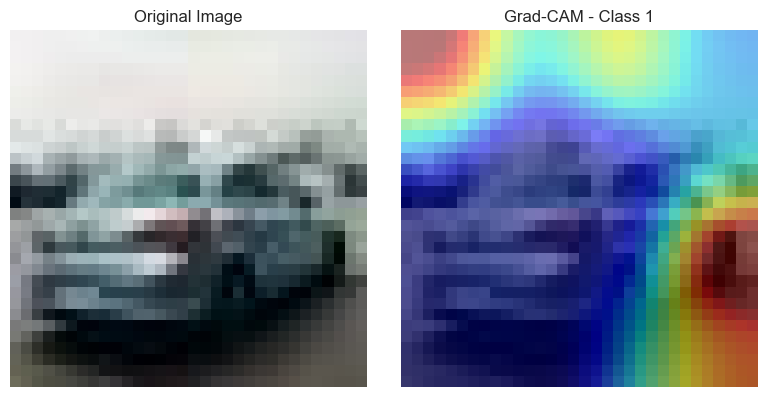

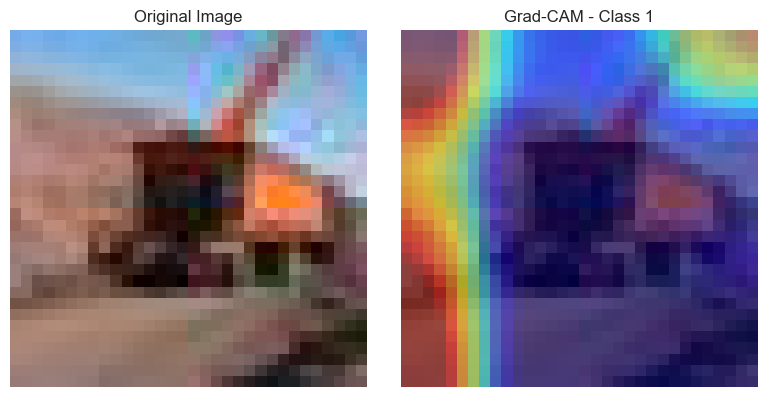

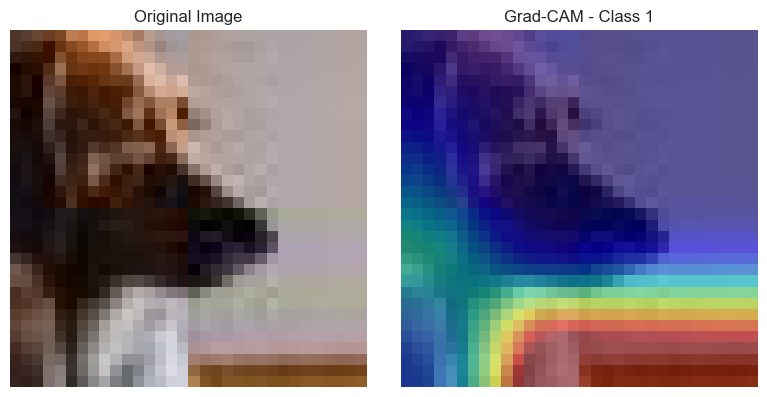

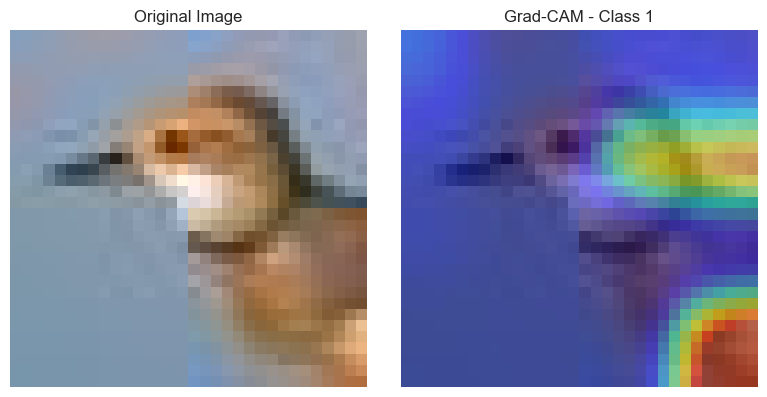

In [41]:
for i in selected_fake_real:
    cam_mapper(model, image=test_data.samples[i][0])

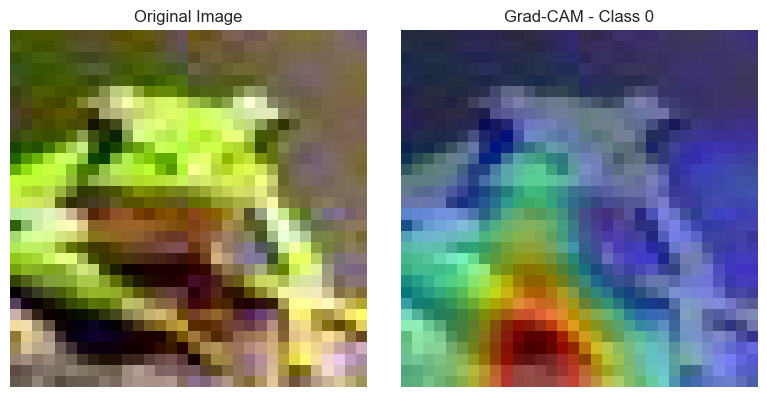

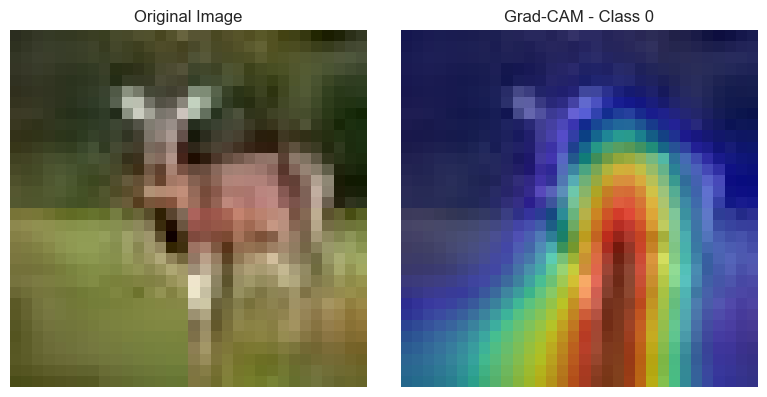

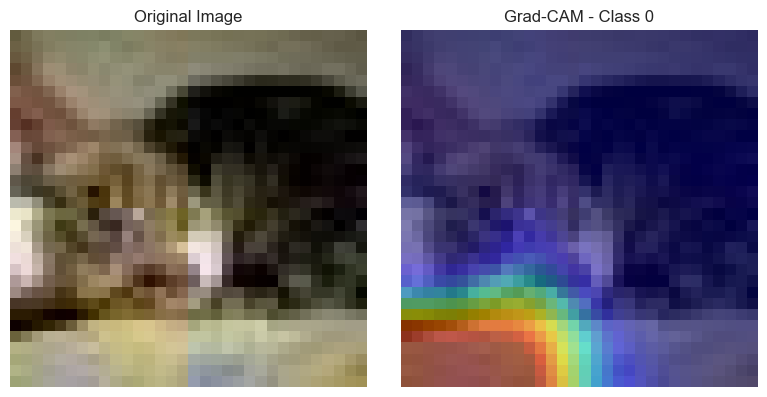

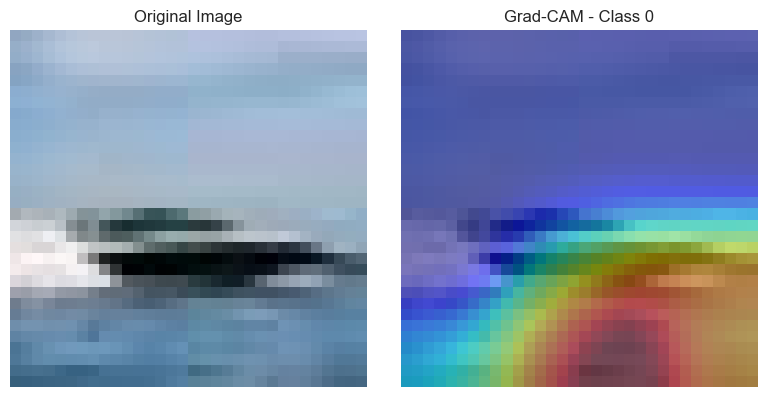

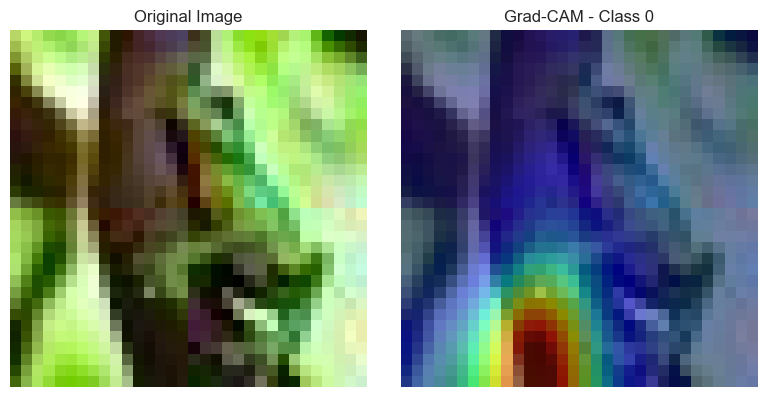

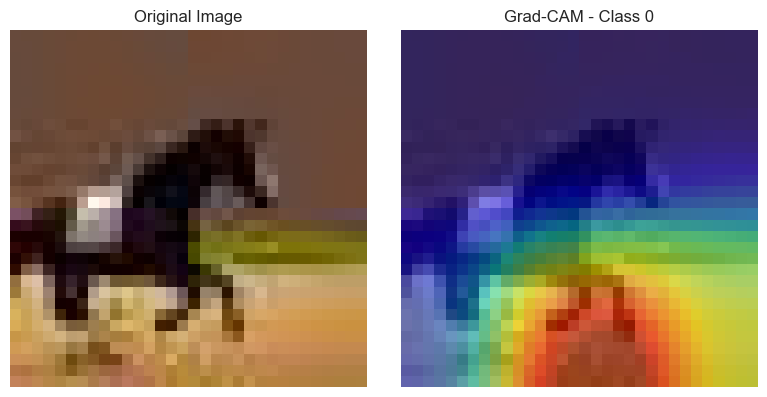

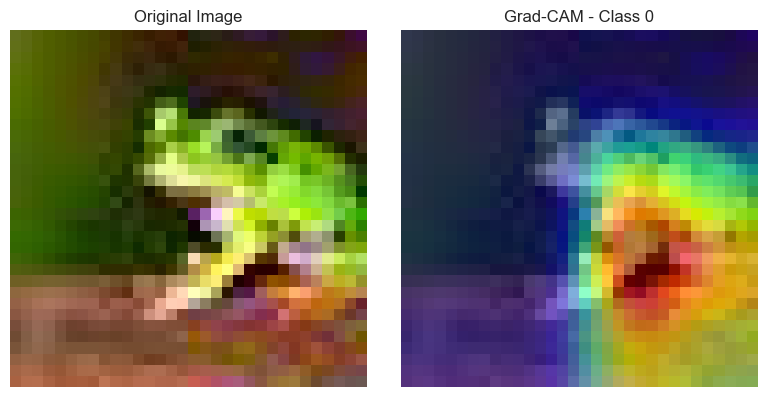

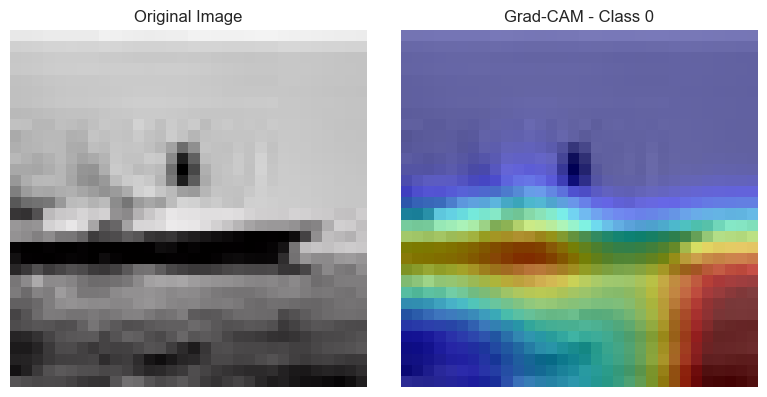

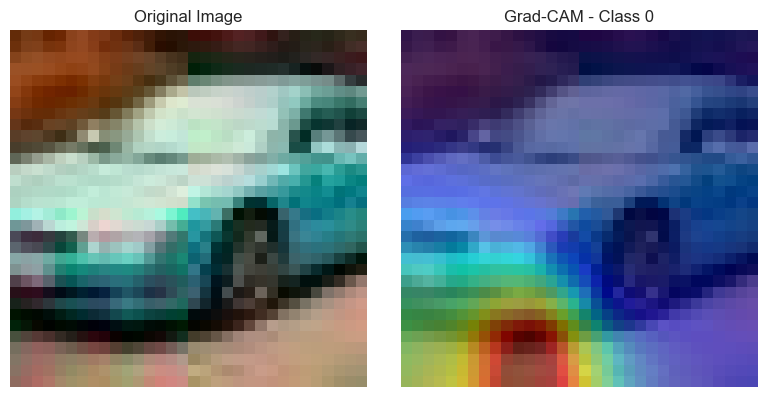

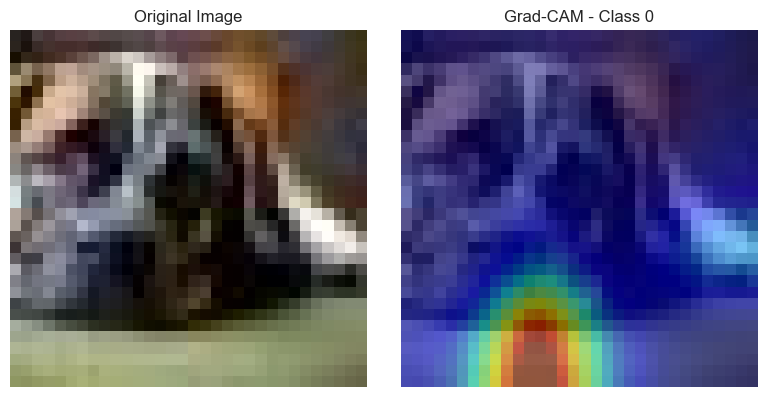

In [42]:
for i in selected_fake_fake:
    cam_mapper(model, image=test_data.samples[i][0])

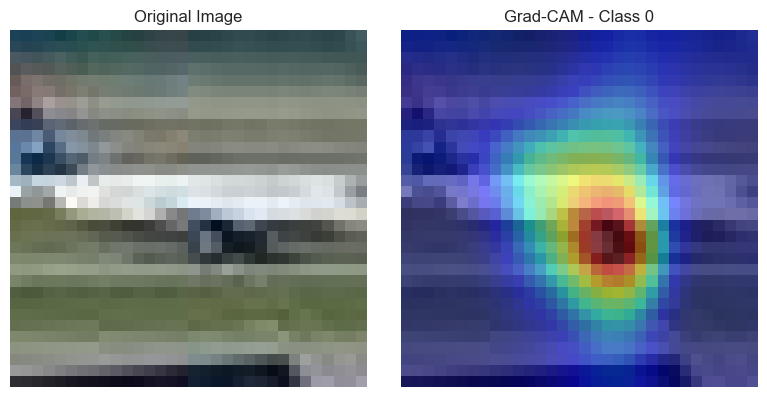

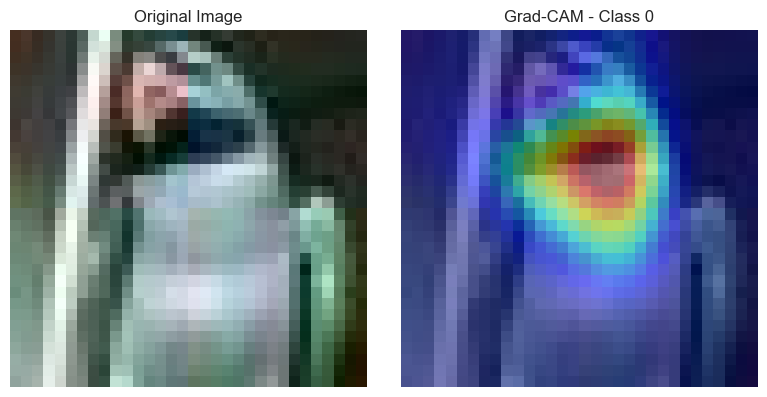

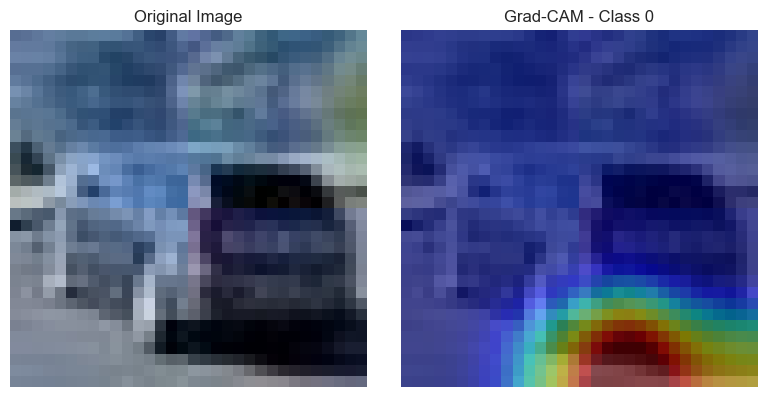

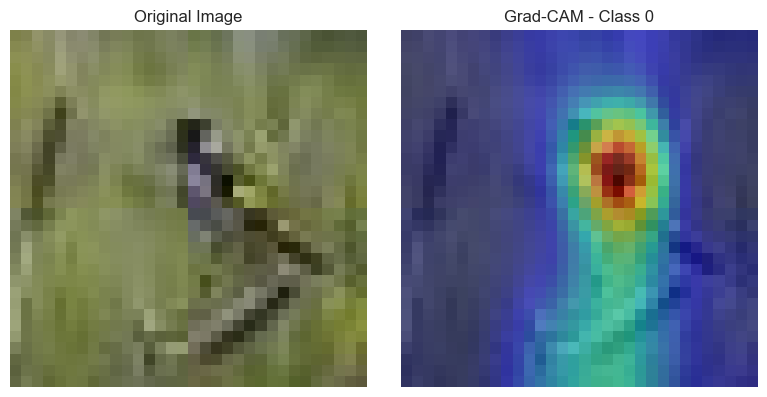

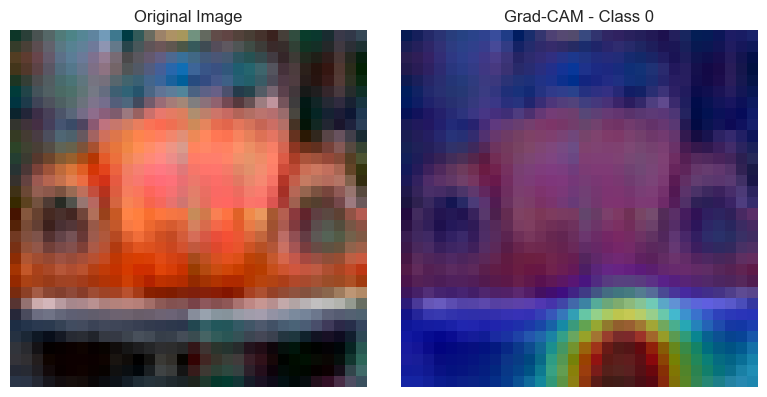

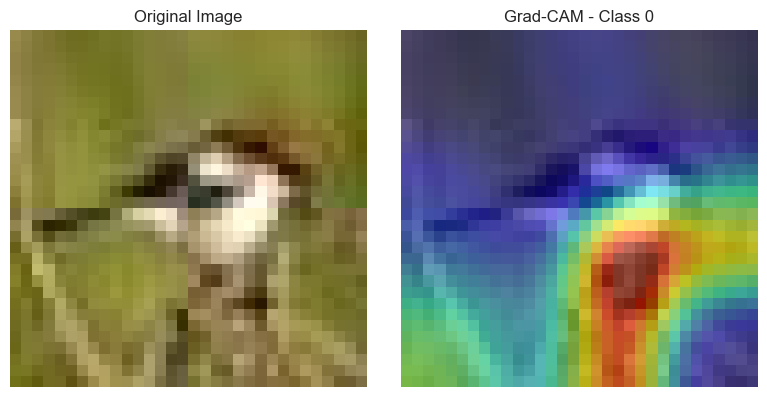

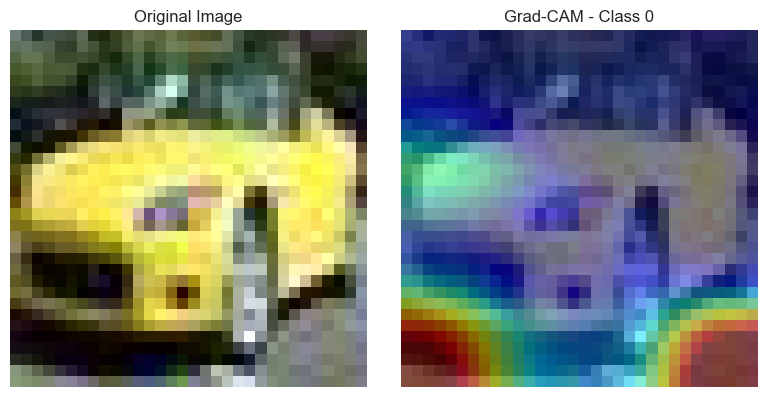

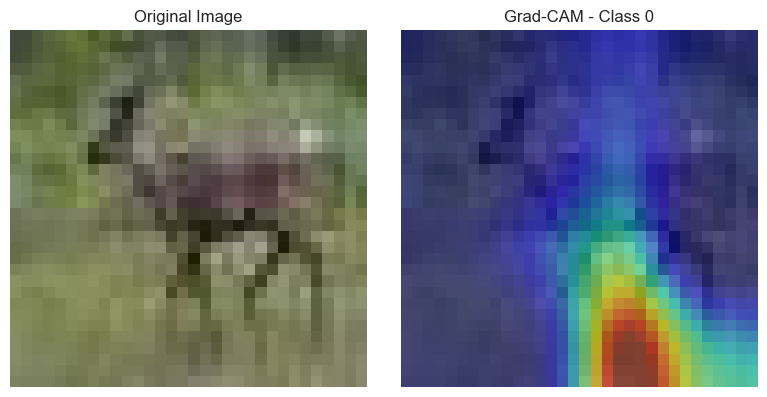

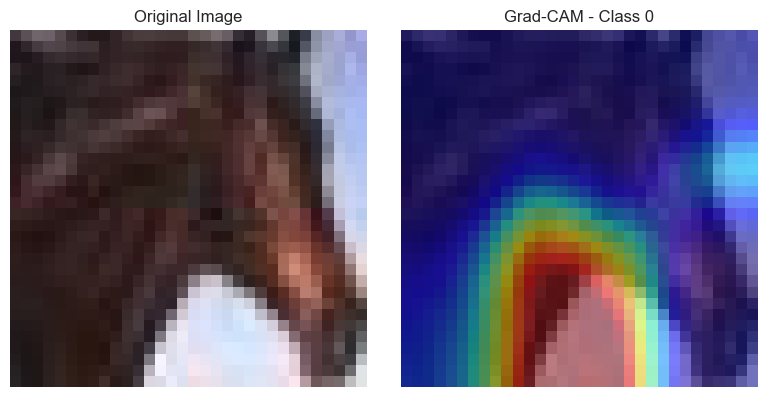

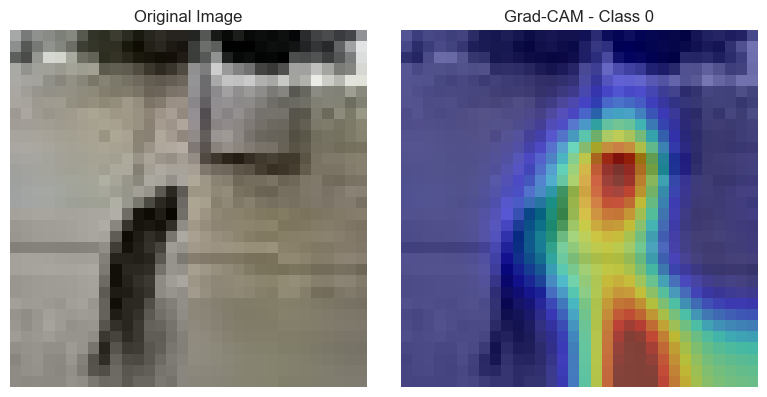

In [43]:
for i in selected_real_fake:
    cam_mapper(model, image=test_data.samples[i][0])

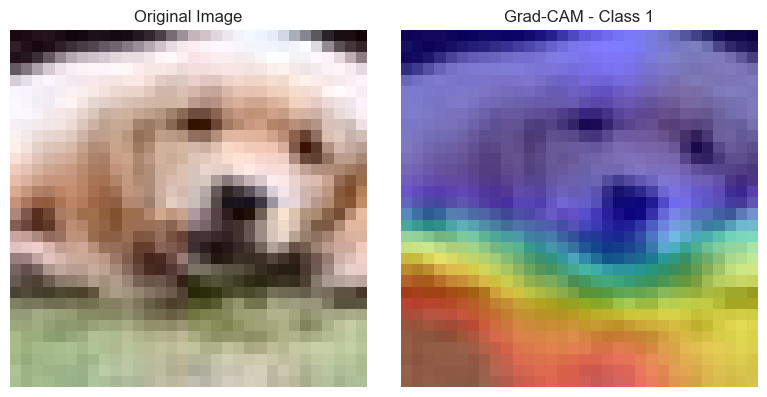

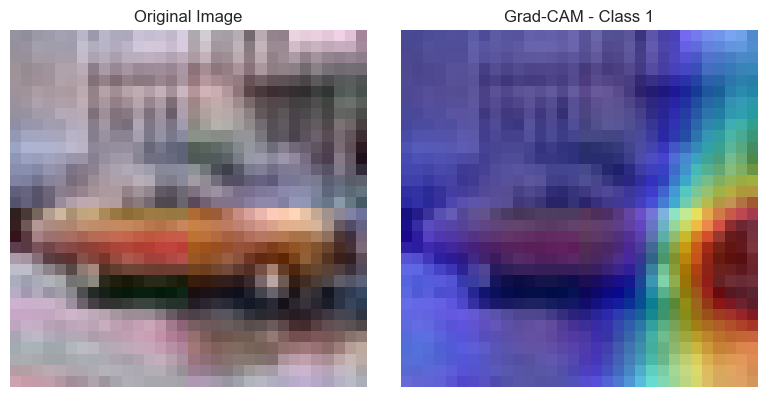

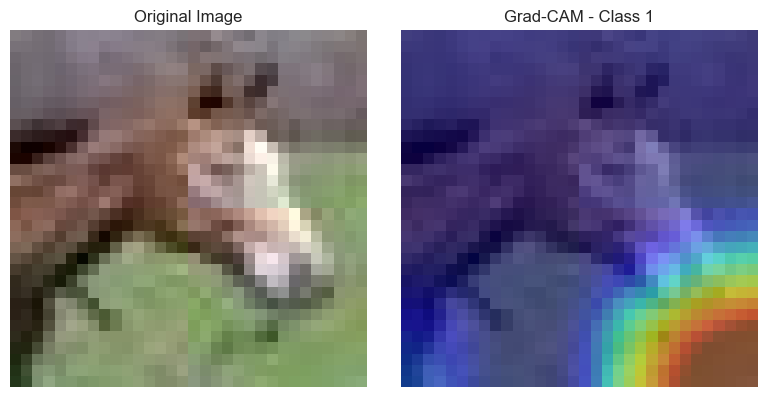

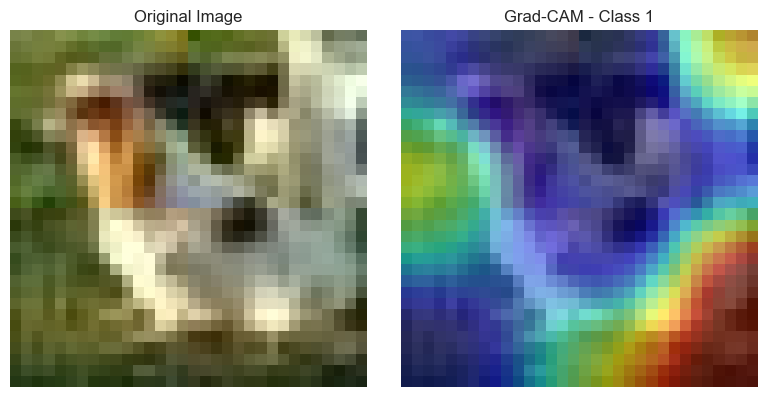

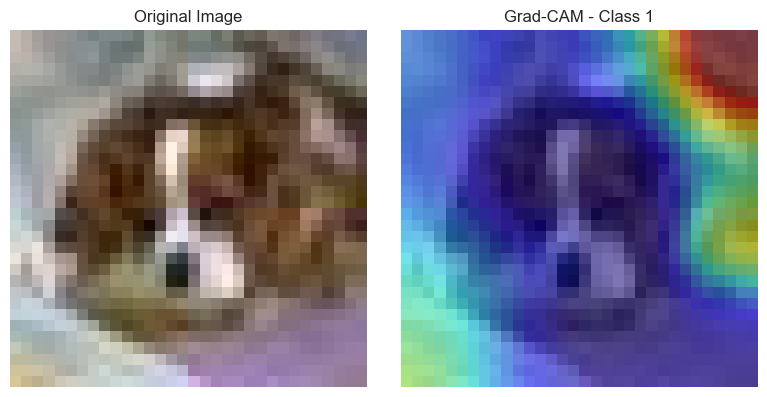

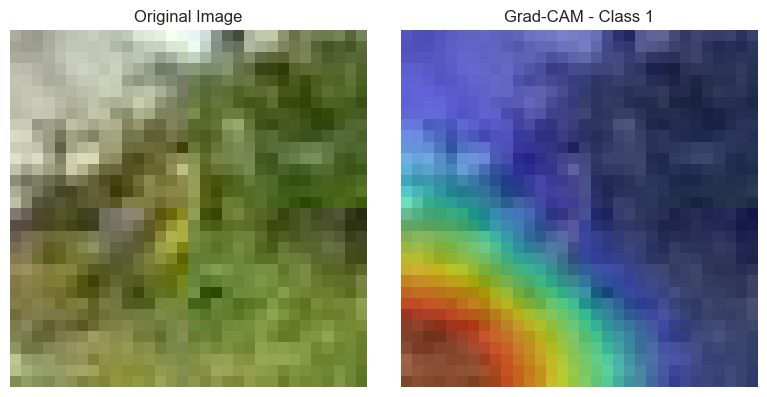

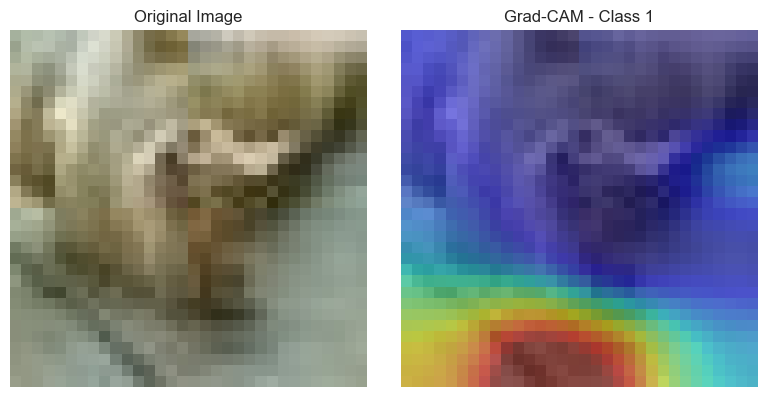

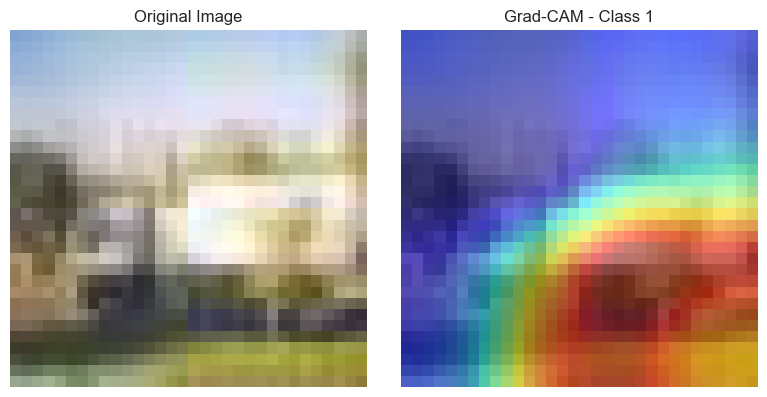

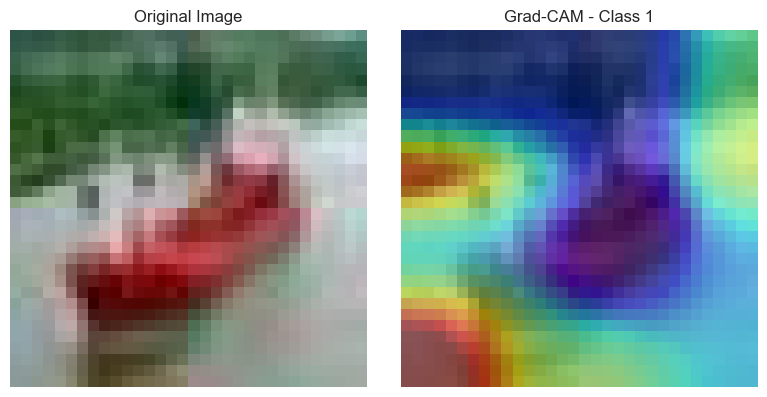

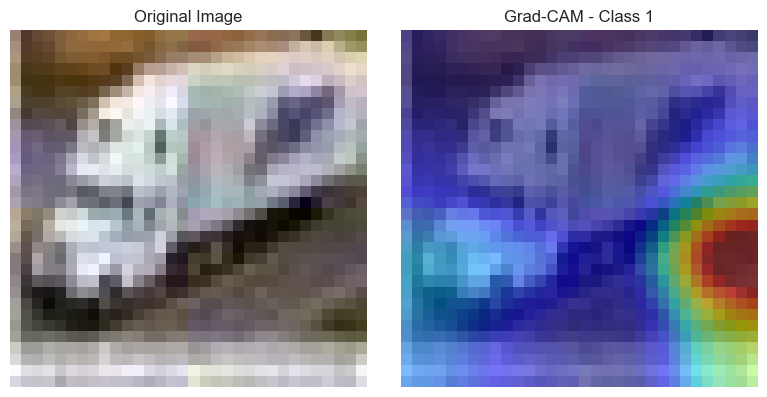

In [44]:
for i in selected_real_real:
    cam_mapper(model, image=test_data.samples[i][0])

The most interesting thing is the tendency to decide real or fake on the boundaries of the images as well as around the object of the picture.

In [3]:
import torch
import numpy as np
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

from skimage.segmentation import slic
from skimage.color import label2rgb

In [114]:
import torch
import numpy as np
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

def show_lime_grayscale(image_np, mask):

    gray = rgb2gray(image_np / 255.0)
    grayscale_with_highlights = gray.copy()
    grayscale_with_highlights[mask == 1] = 1.0

    plt.imshow(grayscale_with_highlights, cmap='gray')
    plt.title("LIME (Grayscale with White Highlights)")
    plt.axis("off")
    plt.show()

def lime_mapper(model, image_path):
    model.to("cpu")
    model.eval()

    img = Image.open(image_path).convert("RGB")
    img = img.resize((32, 32))
    img_np = np.array(img)


    def predict_numpy(images):
        images = torch.tensor(np.transpose(images, (0, 3, 1, 2)), dtype=torch.float32)
        images = images.to(device)
        local_model = model.to(device)
        local_model.eval()
        with torch.no_grad():
            output = local_model(images)
            probs = torch.nn.functional.softmax(output, dim=1).cpu().numpy()
        return probs
    
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np,
        predict_numpy,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.0
    )


    gray = rgb2gray(img_np / 255.0)
    grayscale_with_highlights = gray.copy()
    grayscale_with_highlights[mask == 1] = 1.0

    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(grayscale_with_highlights, cmap='gray')
    axs[1].set_title("LIME Explanation")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


In [117]:
def lime_mapper(model, image_path):

    import torch
    import numpy as np
    from PIL import Image
    from lime import lime_image
    from skimage.segmentation import mark_boundaries
    import matplotlib.pyplot as plt

    device = ('cpu')
    model = model.to(device)
    model.eval()

    img = Image.open(image_path).convert("RGB")
    img = img.resize((32, 32))
    img_np = np.array(img)

    def predict_numpy(images):
        images = torch.tensor(np.transpose(images, (0, 3, 1, 2)), dtype=torch.float32)
        images = images.to(device)
        local_model = model.to(device)
        local_model.eval()
        with torch.no_grad():
            output = local_model(images)
            probs = torch.nn.functional.softmax(output, dim=1).cpu().numpy()
        return probs

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np,
        predict_numpy,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    top_label = explanation.top_labels[0]
    segments = explanation.segments
    weights = dict(explanation.local_exp[top_label])

    custom_overlay = np.zeros(segments.shape)
    for seg_id, weight in weights.items():
        custom_overlay[segments == seg_id] = 1 if weight > 0 else -1

    # Use label2rgb to map:
    # - 1 (positive) → green
    # - -1 (negative) → red
    overlay_rgb = label2rgb(
        custom_overlay, 
        image=img_np, 
        colors=[(1, 0, 0), (0, 1, 0)],  # red, green
        bg_label=0,
        alpha=0.5
    )

    
    # temp, mask = explanation.get_image_and_mask(
    #     label=explanation.top_labels[0],
    #     positive_only=False,
    #     hide_rest=False,
    #     num_features=10,
    #     min_weight=0.0
    # )

    # overlay_img = mark_boundaries(temp / 255.0, mask, color=(1, 0, 0))
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(overlay_rgb)
    axs[1].set_title("LIME Explanation")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

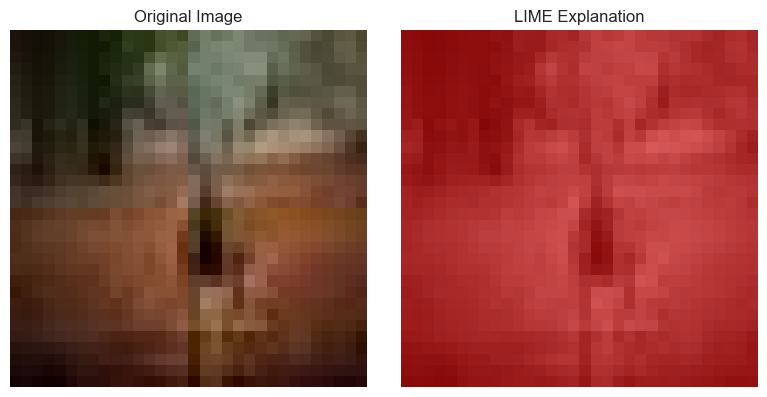

  0%|          | 0/1000 [00:00<?, ?it/s]

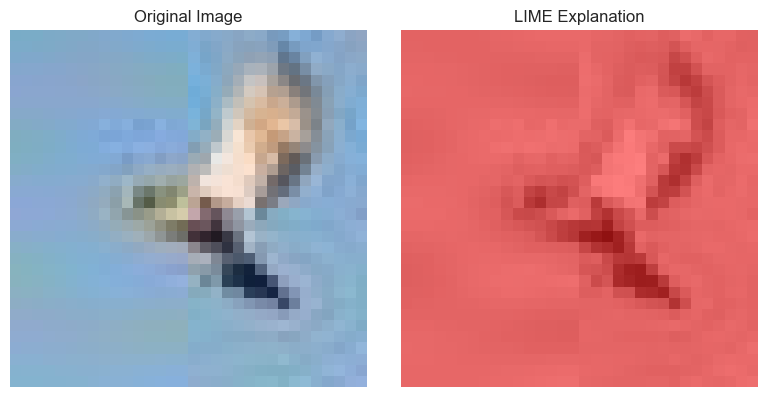

  0%|          | 0/1000 [00:00<?, ?it/s]

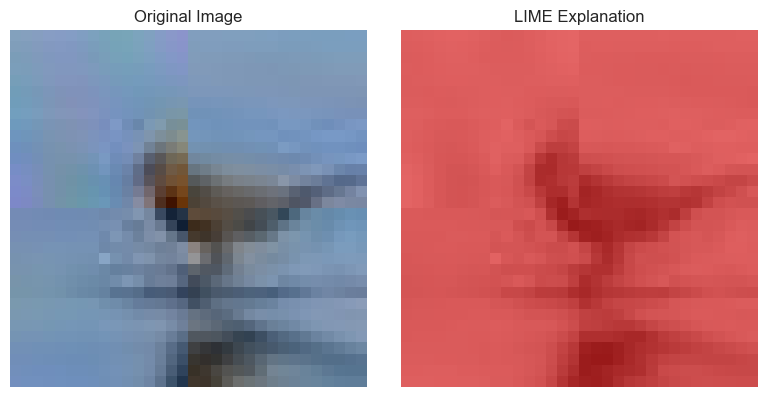

  0%|          | 0/1000 [00:00<?, ?it/s]

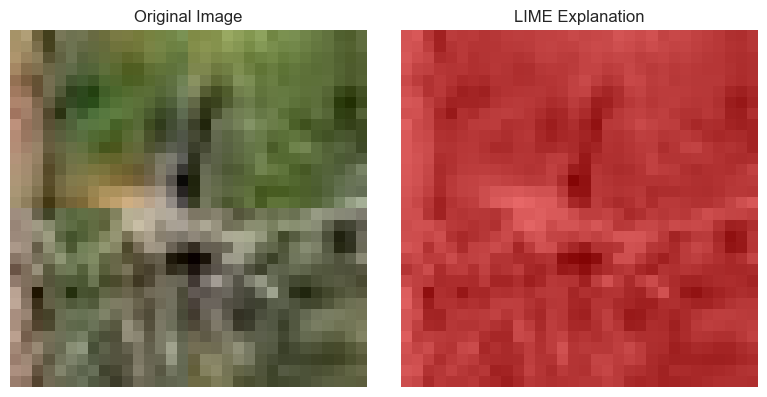

  0%|          | 0/1000 [00:00<?, ?it/s]

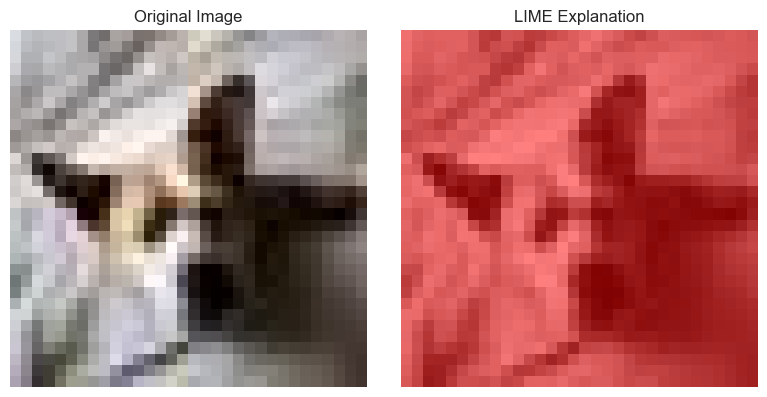

  0%|          | 0/1000 [00:00<?, ?it/s]

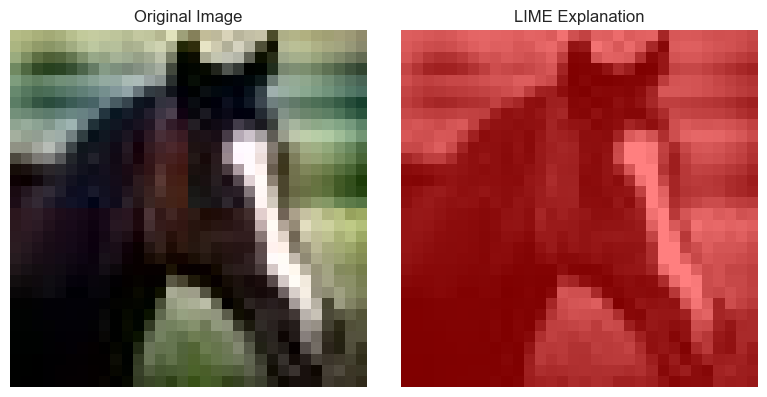

  0%|          | 0/1000 [00:00<?, ?it/s]

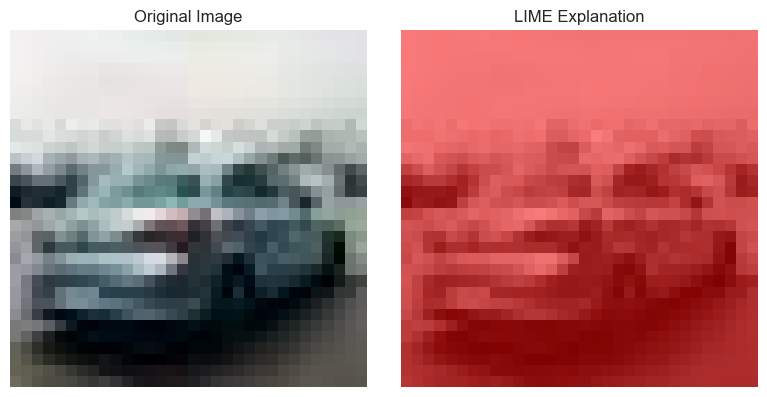

  0%|          | 0/1000 [00:00<?, ?it/s]

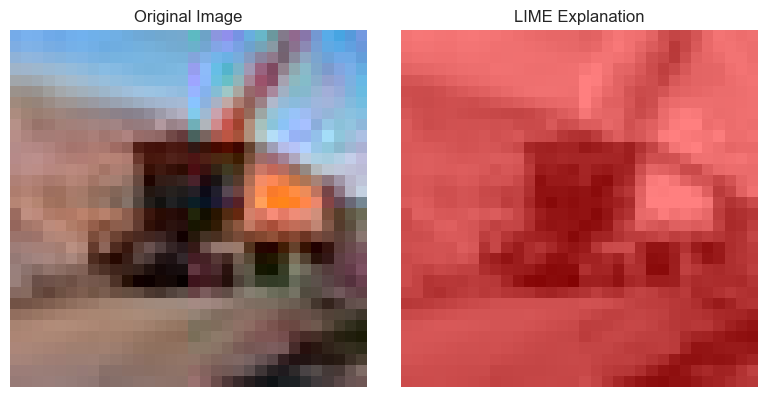

  0%|          | 0/1000 [00:00<?, ?it/s]

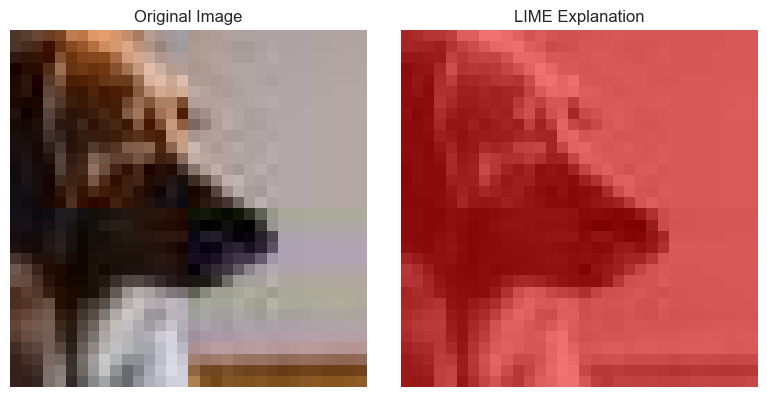

  0%|          | 0/1000 [00:00<?, ?it/s]

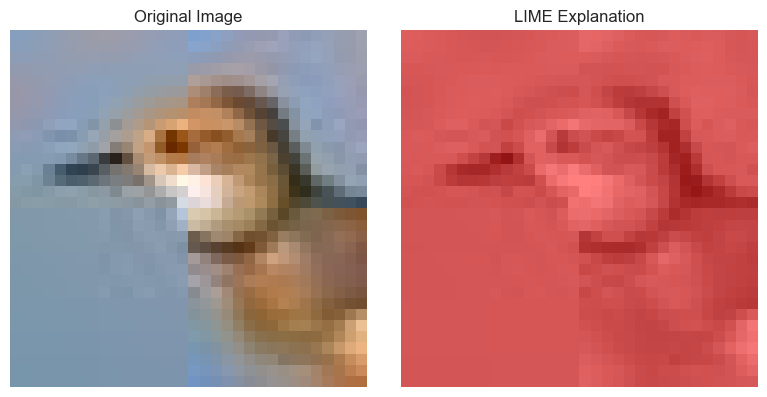

In [41]:
for i in selected_fake_real:
    lime_mapper(model, image_path=test_data.samples[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

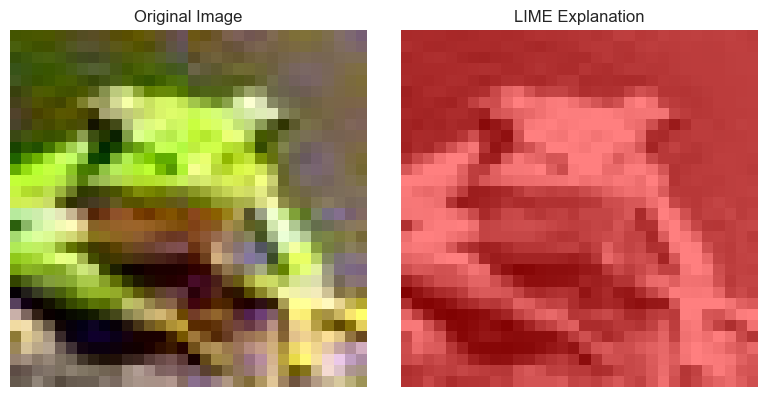

  0%|          | 0/1000 [00:00<?, ?it/s]

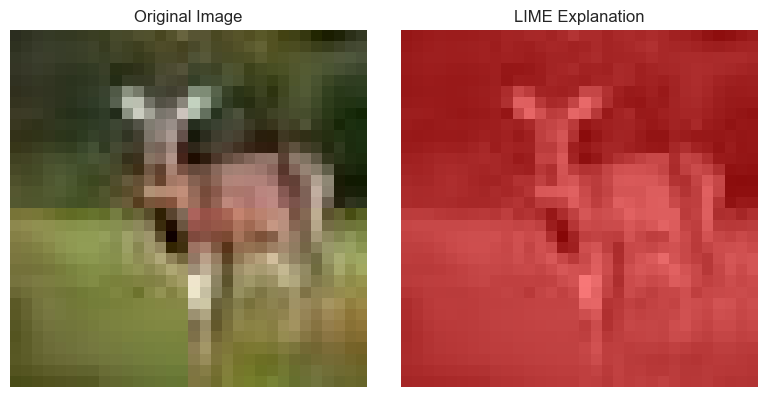

  0%|          | 0/1000 [00:00<?, ?it/s]

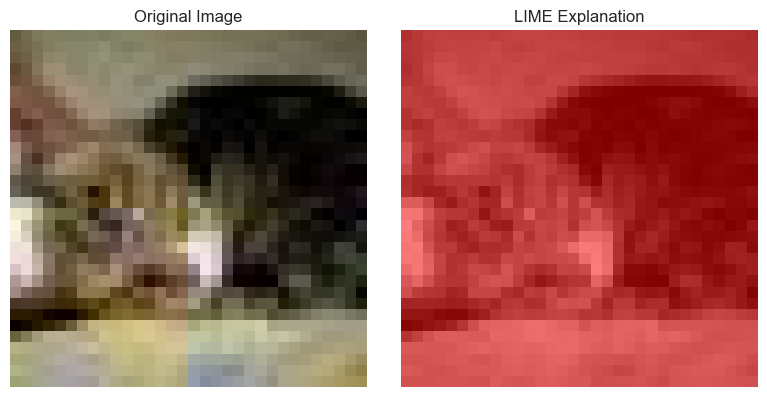

  0%|          | 0/1000 [00:00<?, ?it/s]

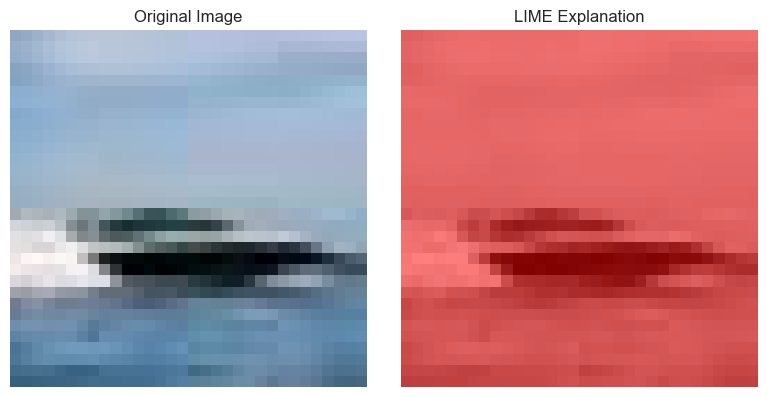

  0%|          | 0/1000 [00:00<?, ?it/s]

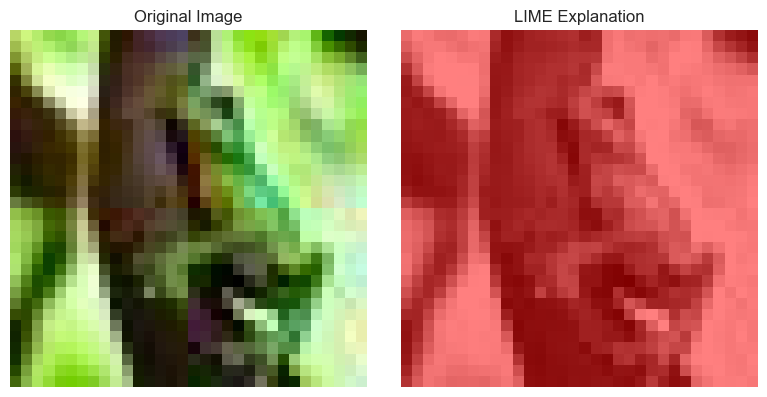

  0%|          | 0/1000 [00:00<?, ?it/s]

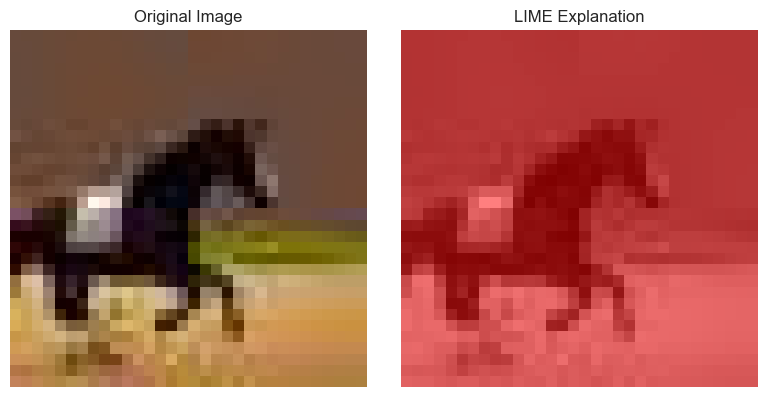

  0%|          | 0/1000 [00:00<?, ?it/s]

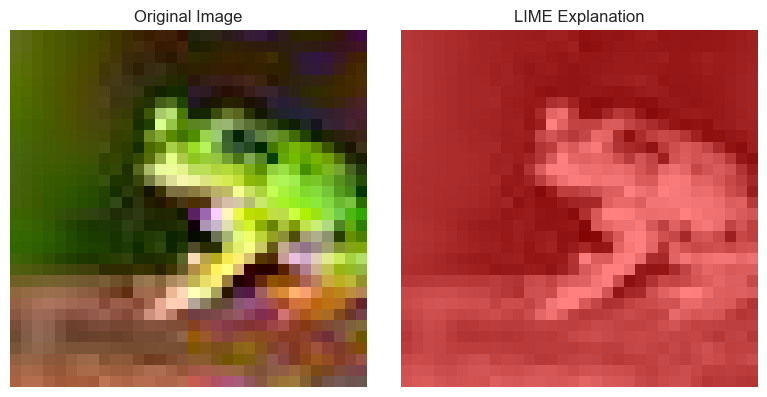

  0%|          | 0/1000 [00:00<?, ?it/s]

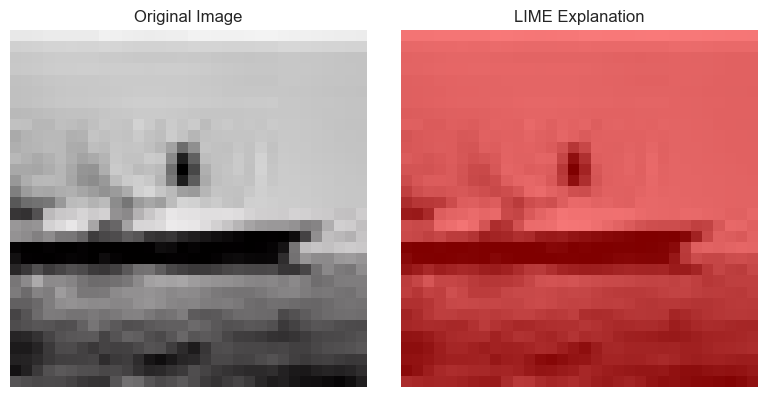

  0%|          | 0/1000 [00:00<?, ?it/s]

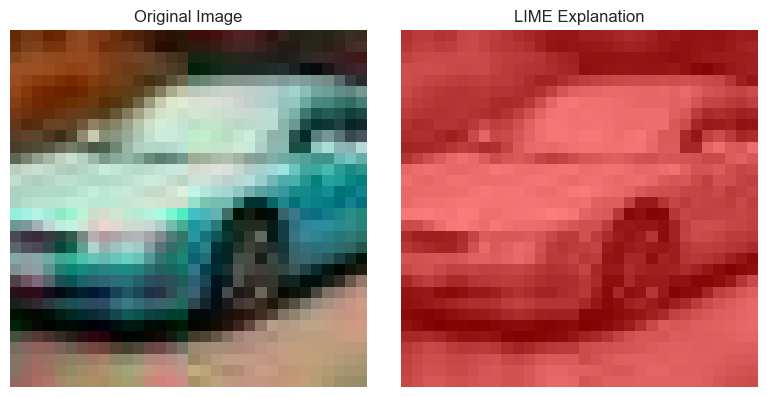

  0%|          | 0/1000 [00:00<?, ?it/s]

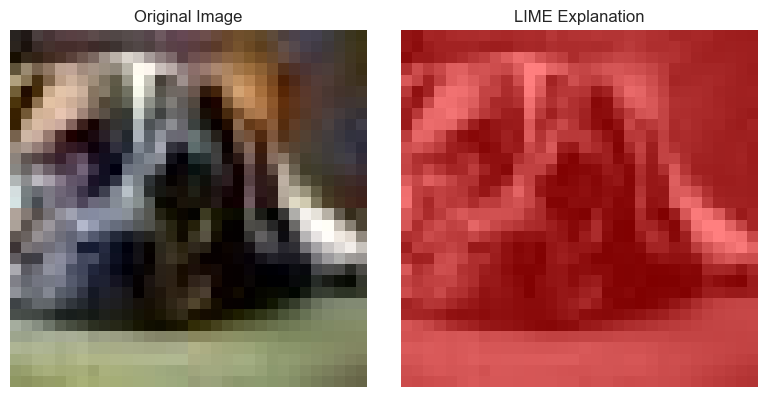

In [42]:
for i in selected_fake_fake:
    lime_mapper(model, image_path=test_data.samples[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

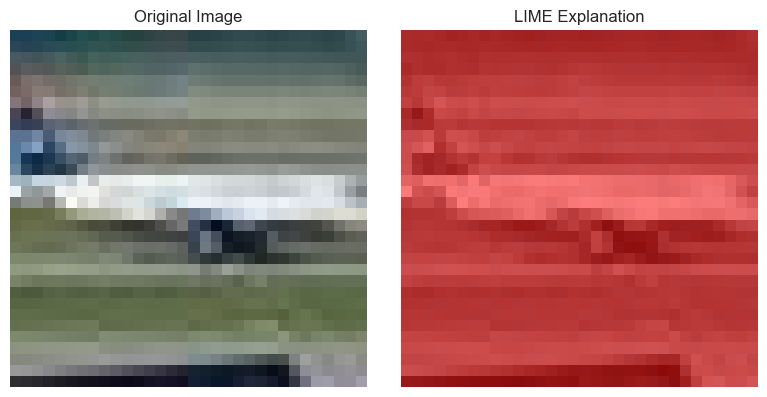

  0%|          | 0/1000 [00:00<?, ?it/s]

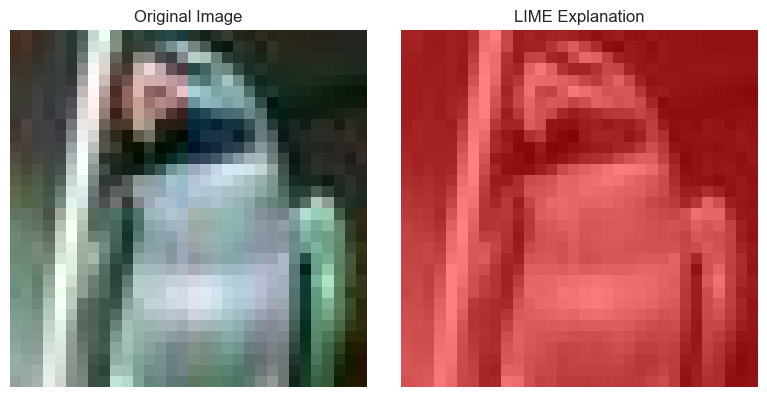

  0%|          | 0/1000 [00:00<?, ?it/s]

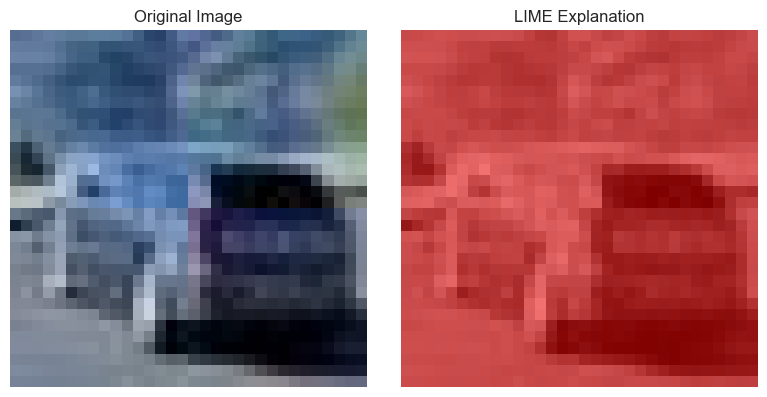

  0%|          | 0/1000 [00:00<?, ?it/s]

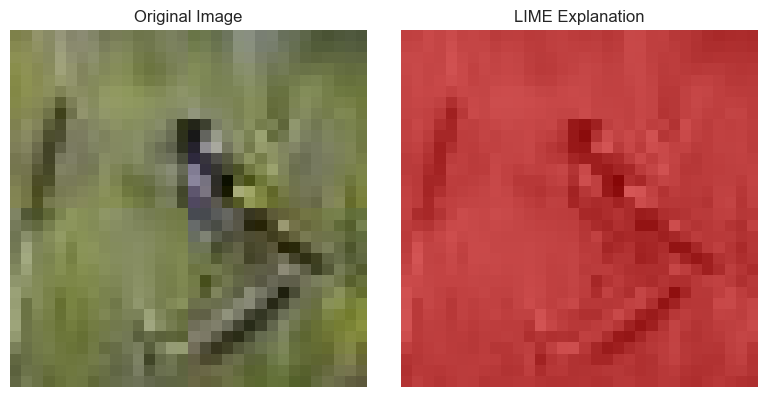

  0%|          | 0/1000 [00:00<?, ?it/s]

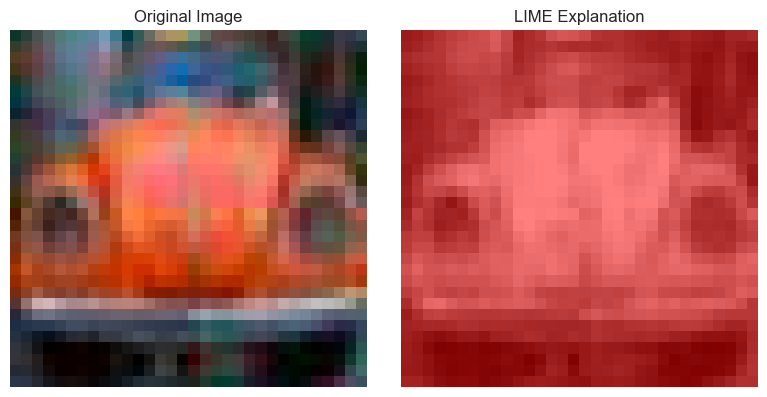

  0%|          | 0/1000 [00:00<?, ?it/s]

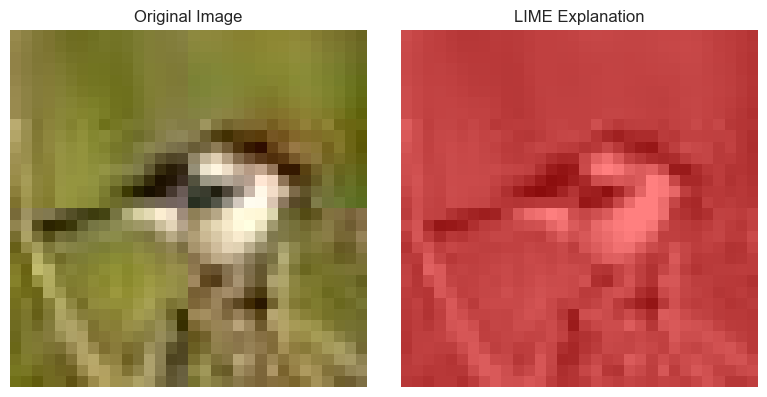

  0%|          | 0/1000 [00:00<?, ?it/s]

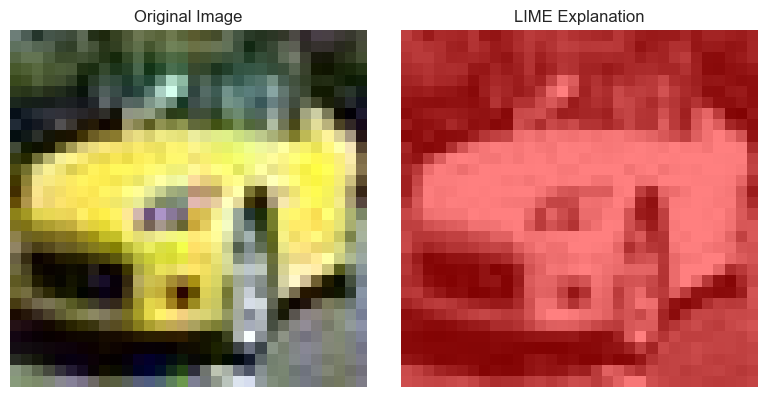

  0%|          | 0/1000 [00:00<?, ?it/s]

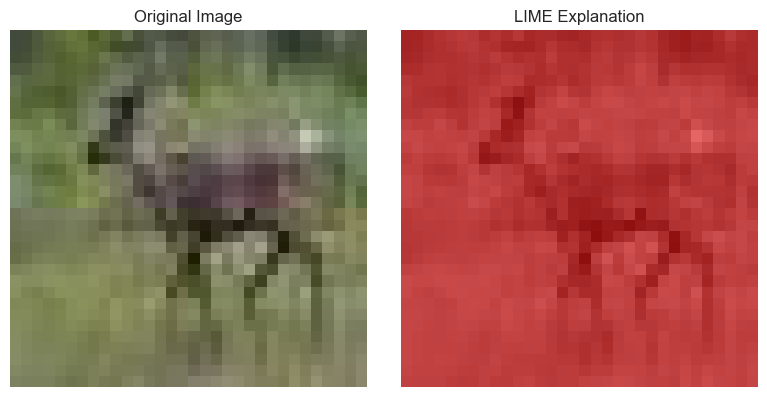

  0%|          | 0/1000 [00:00<?, ?it/s]

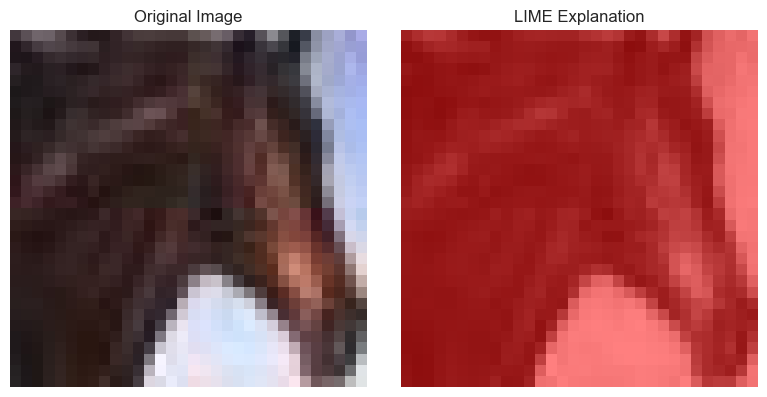

  0%|          | 0/1000 [00:00<?, ?it/s]

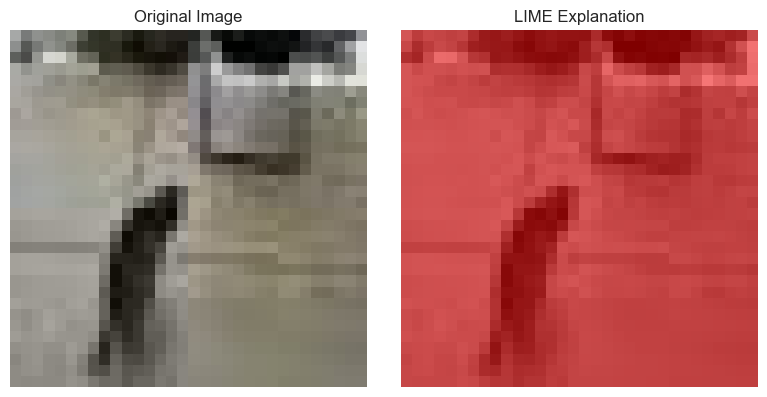

In [43]:
for i in selected_real_fake:
    lime_mapper(model, image_path=test_data.samples[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

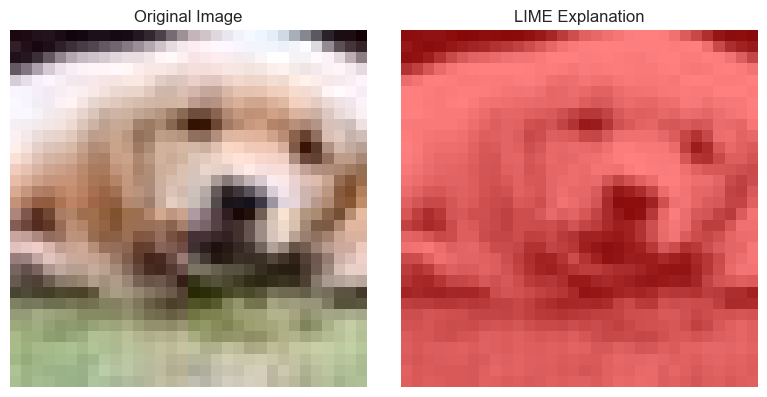

  0%|          | 0/1000 [00:00<?, ?it/s]

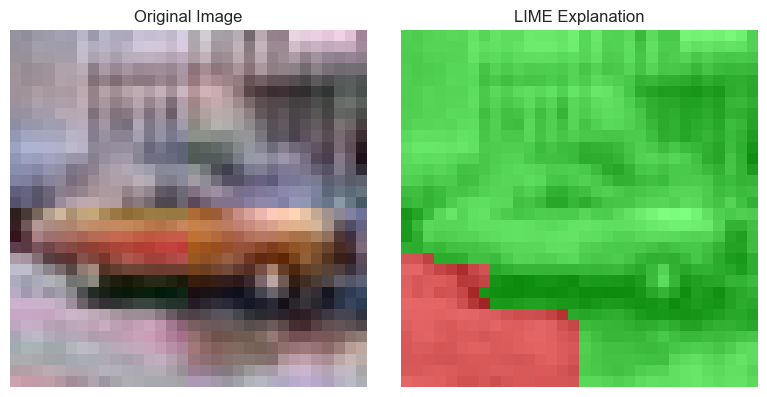

  0%|          | 0/1000 [00:00<?, ?it/s]

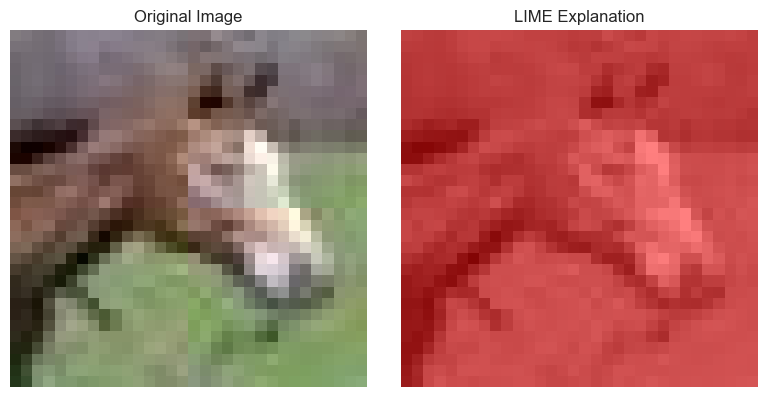

  0%|          | 0/1000 [00:00<?, ?it/s]

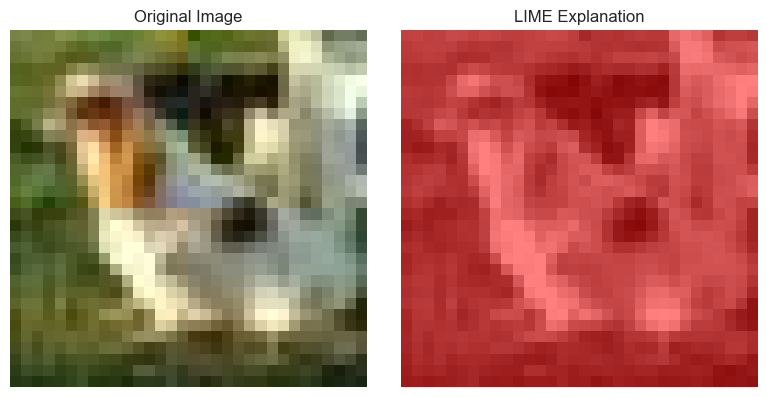

  0%|          | 0/1000 [00:00<?, ?it/s]

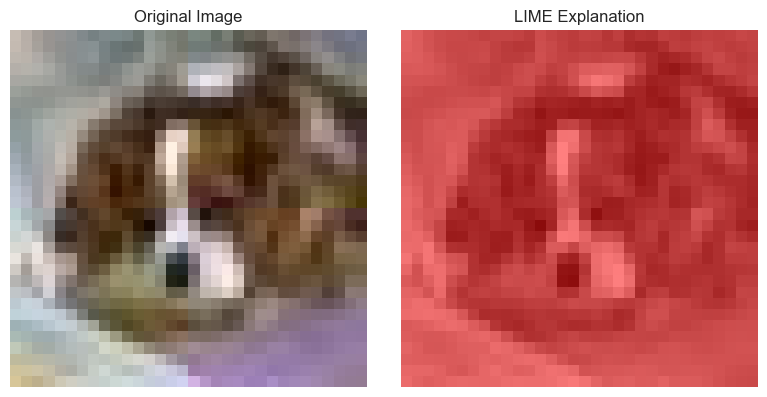

  0%|          | 0/1000 [00:00<?, ?it/s]

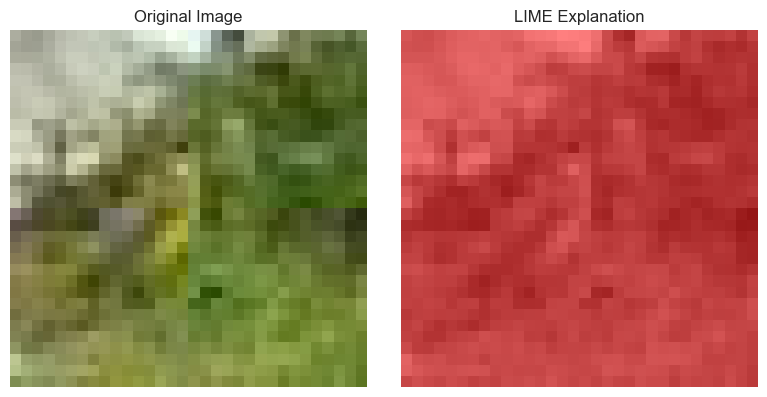

  0%|          | 0/1000 [00:00<?, ?it/s]

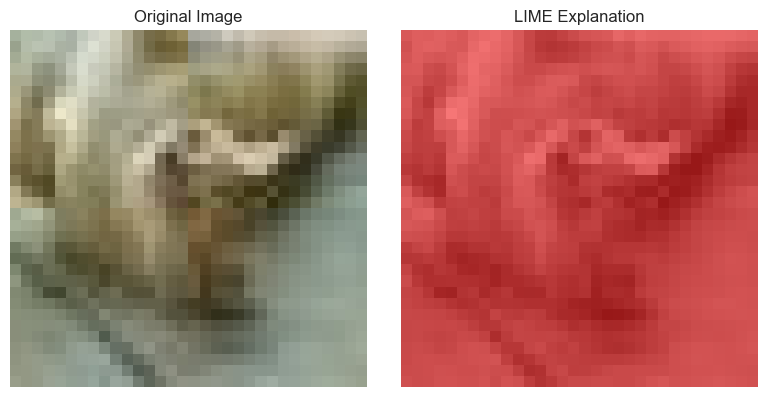

  0%|          | 0/1000 [00:00<?, ?it/s]

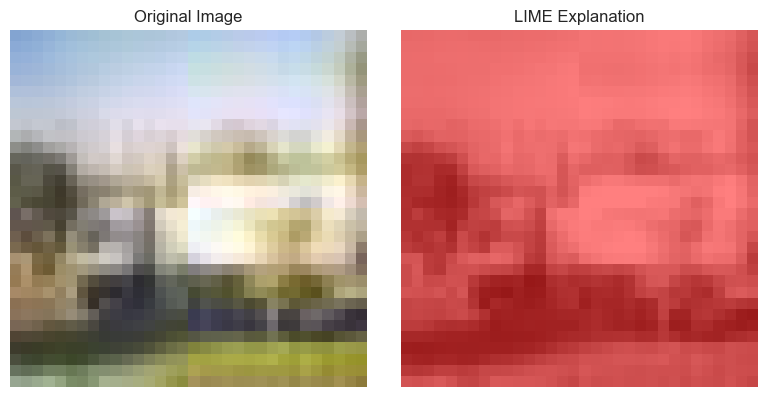

  0%|          | 0/1000 [00:00<?, ?it/s]

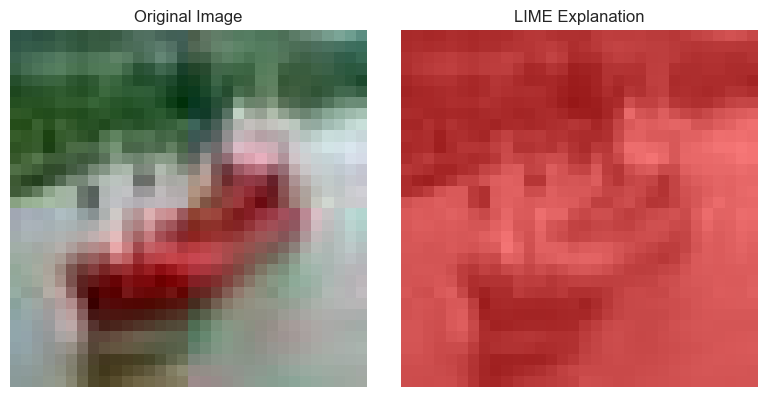

  0%|          | 0/1000 [00:00<?, ?it/s]

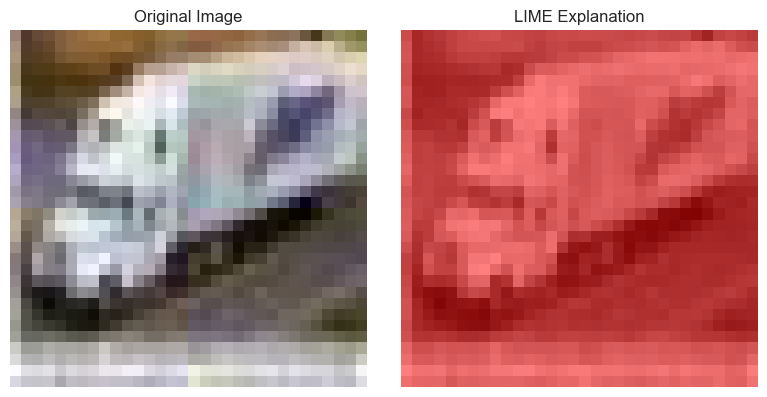

In [44]:
for i in selected_real_real:
    lime_mapper(model, image_path=test_data.samples[i][0])

This seems to suggest that for the most part, its selecting based off of LACK of features. For example, correctly predicted AI-generated images see a LACK of realistic features, likewise correctly predicted real images see a LACK of AI-generated features. Interestingly the one image with green is in the real-real category.

## Using Paired Fake and Real Images

In [115]:
fake = test_data.samples[6280:6290]
real = test_data.samples[6280+10360:6290+10360]

In [61]:
fake

[('dataset/test/FAKE\\664 (10).jpg', 0),
 ('dataset/test/FAKE\\664 (2).jpg', 0),
 ('dataset/test/FAKE\\664 (3).jpg', 0),
 ('dataset/test/FAKE\\664 (4).jpg', 0),
 ('dataset/test/FAKE\\664 (5).jpg', 0),
 ('dataset/test/FAKE\\664 (6).jpg', 0),
 ('dataset/test/FAKE\\664 (7).jpg', 0),
 ('dataset/test/FAKE\\664 (8).jpg', 0),
 ('dataset/test/FAKE\\664 (9).jpg', 0),
 ('dataset/test/FAKE\\664.jpg', 0)]

In [62]:
real

[('dataset/test/REAL\\0664 (10).jpg', 1),
 ('dataset/test/REAL\\0664 (2).jpg', 1),
 ('dataset/test/REAL\\0664 (3).jpg', 1),
 ('dataset/test/REAL\\0664 (4).jpg', 1),
 ('dataset/test/REAL\\0664 (5).jpg', 1),
 ('dataset/test/REAL\\0664 (6).jpg', 1),
 ('dataset/test/REAL\\0664 (7).jpg', 1),
 ('dataset/test/REAL\\0664 (8).jpg', 1),
 ('dataset/test/REAL\\0664 (9).jpg', 1),
 ('dataset/test/REAL\\0664.jpg', 1)]

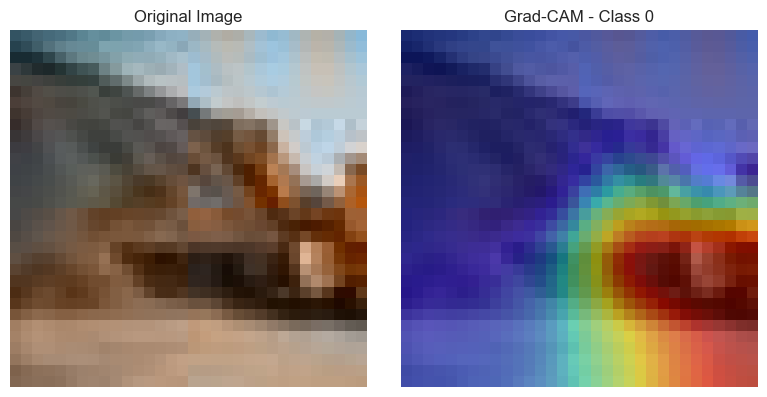

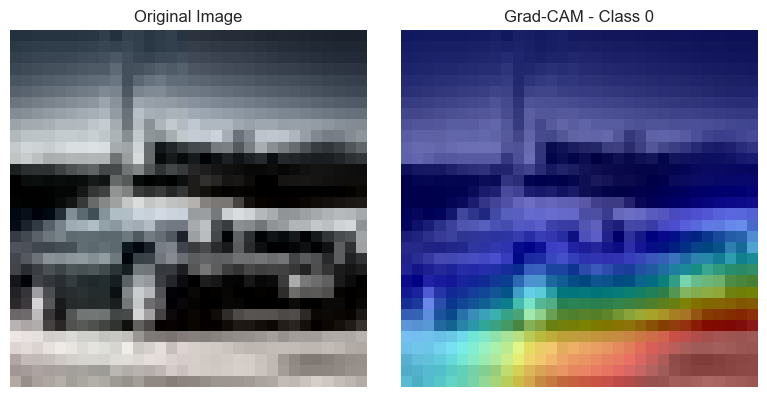

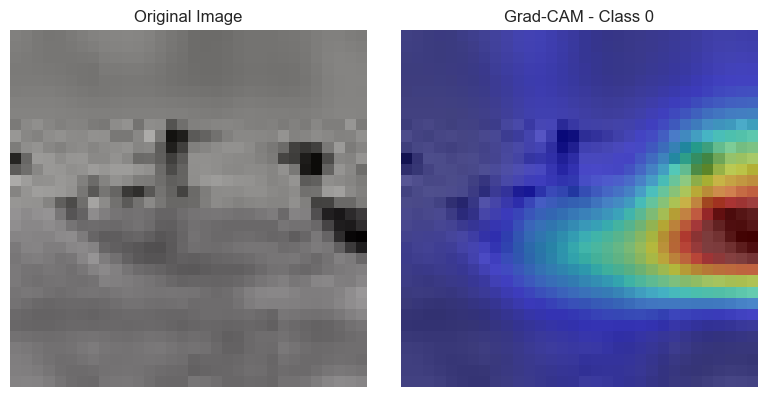

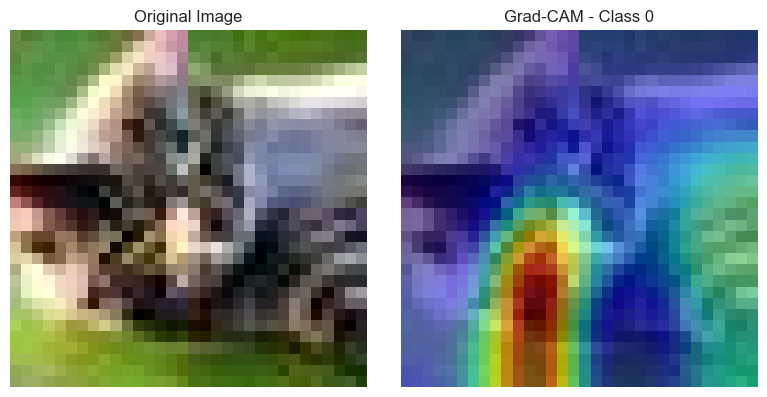

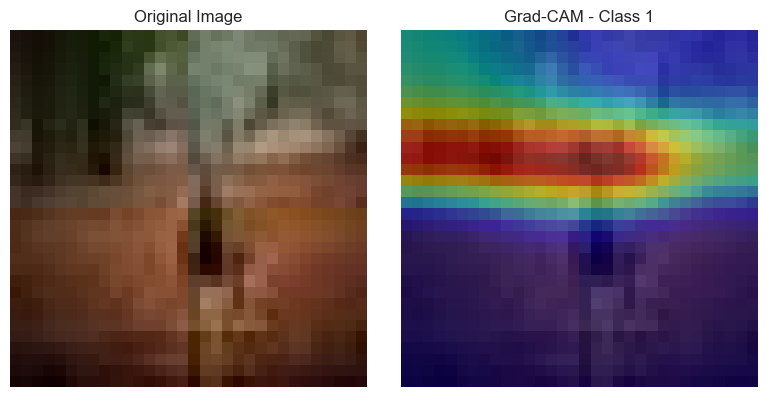

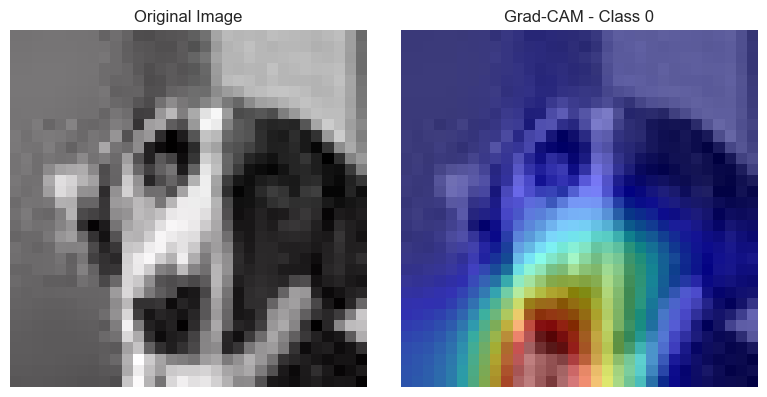

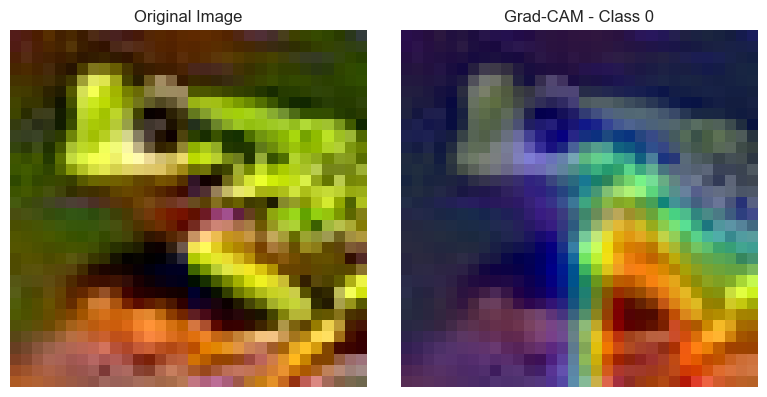

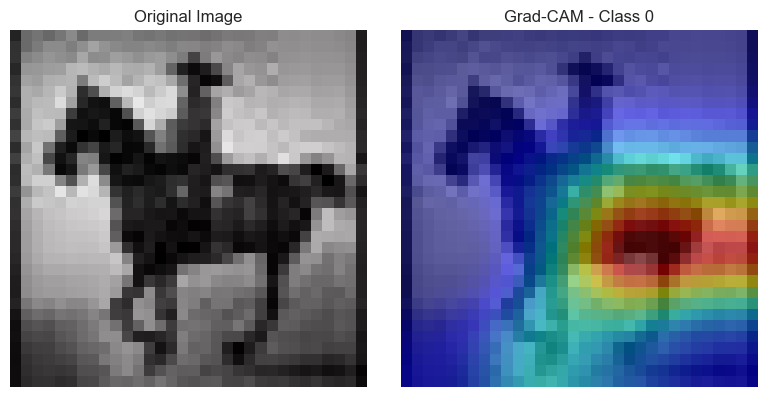

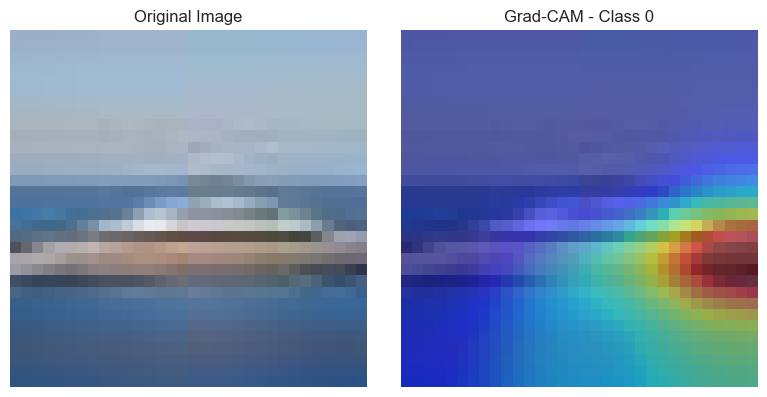

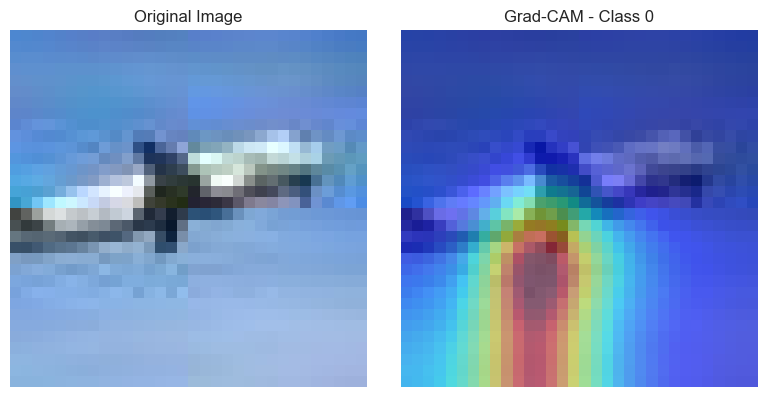

In [58]:
for i in range(len(fake)):
    cam_mapper(model, image=fake[i][0])

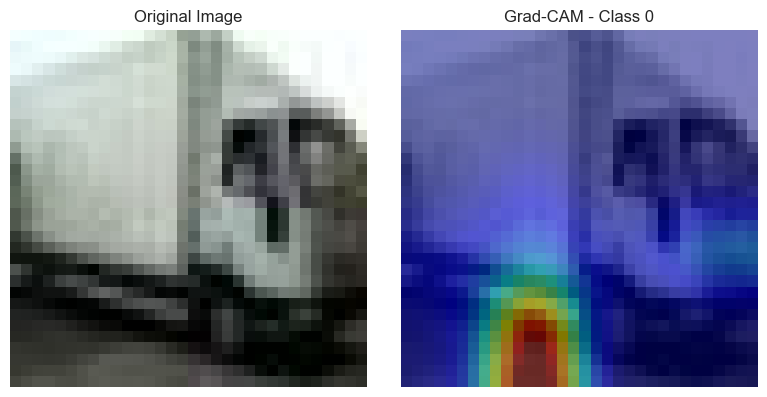

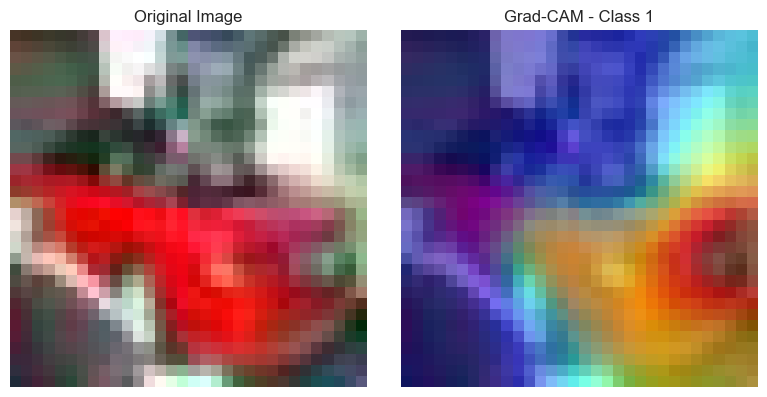

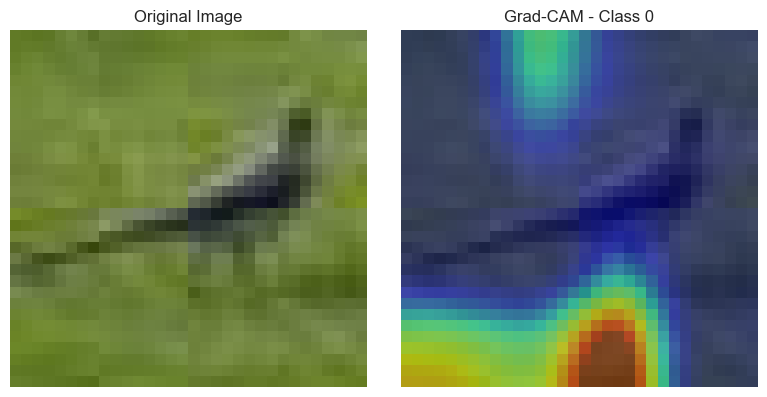

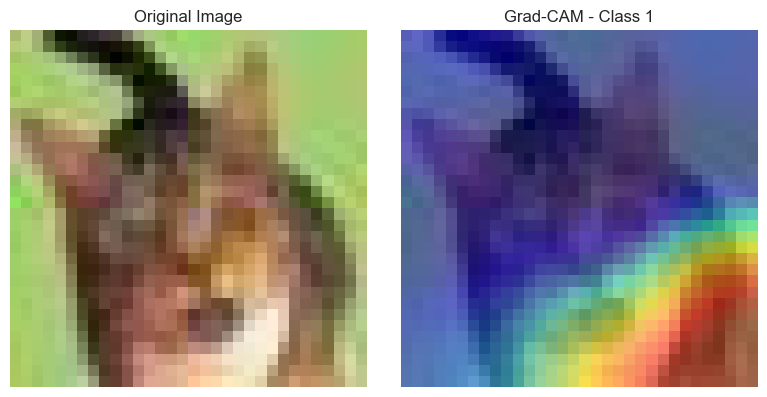

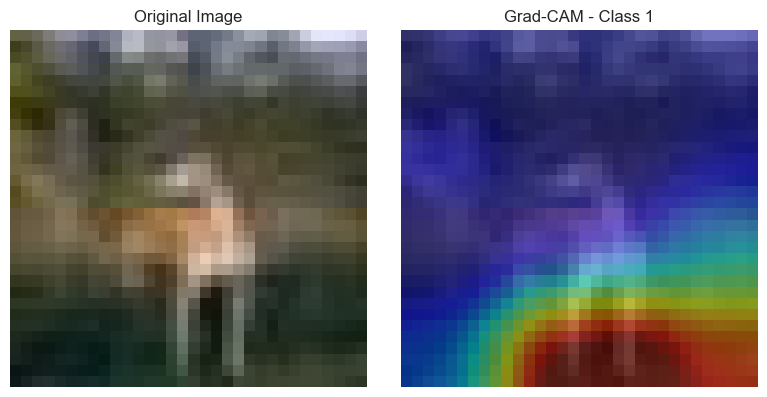

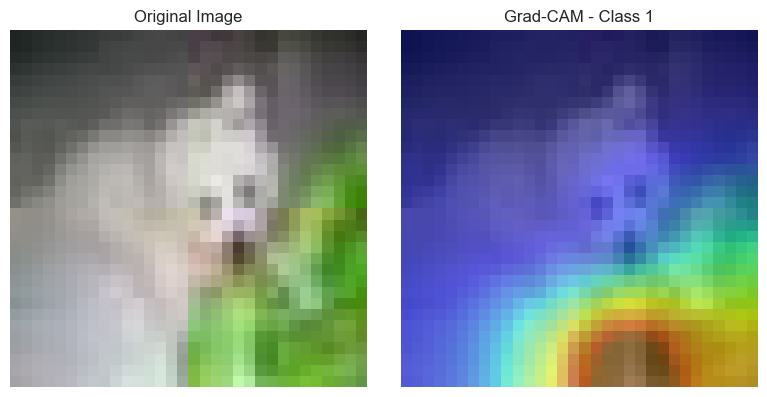

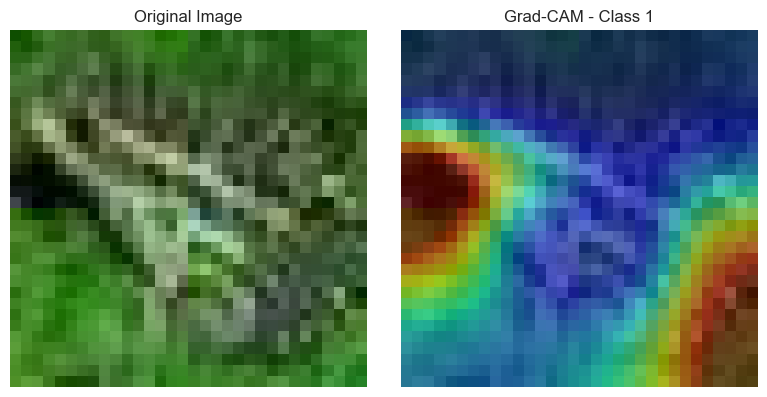

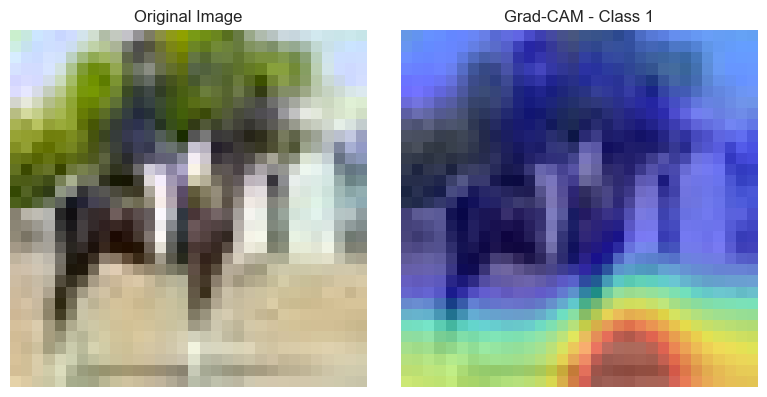

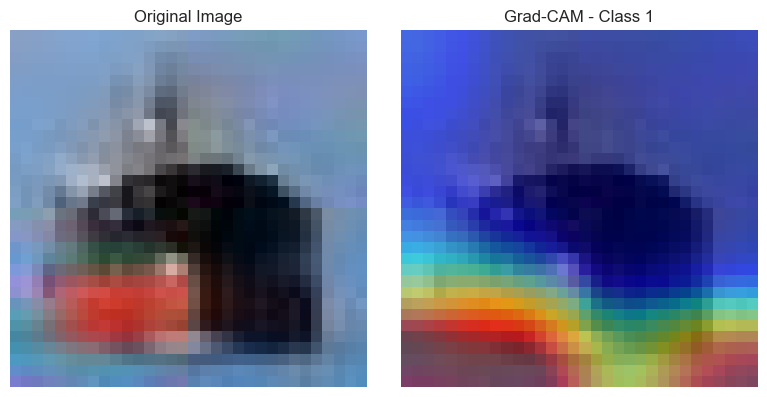

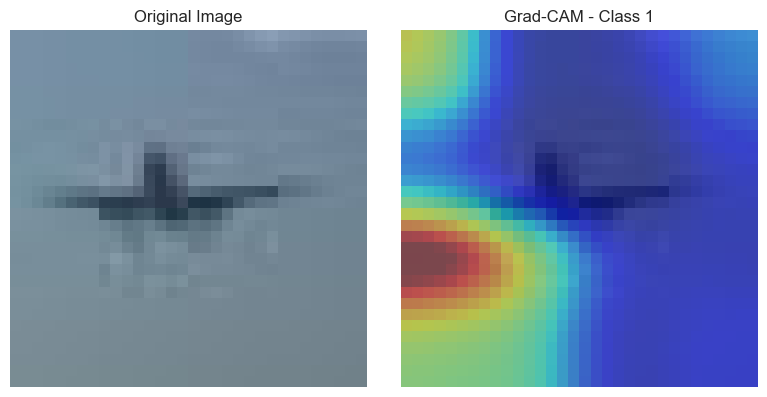

In [59]:
for i in range(len(real)):
    cam_mapper(model, image=real[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

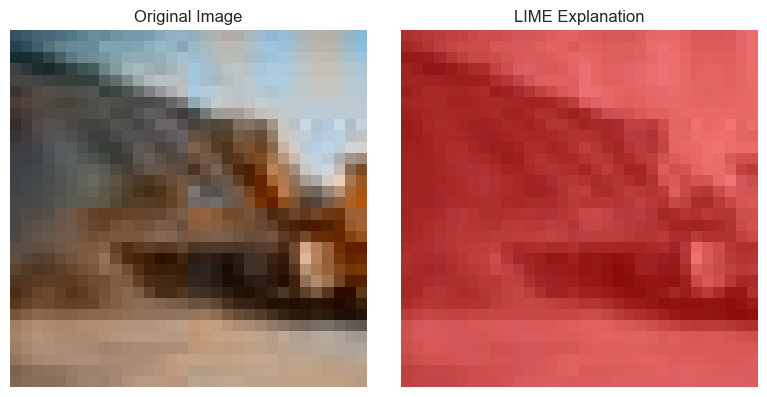

  0%|          | 0/1000 [00:00<?, ?it/s]

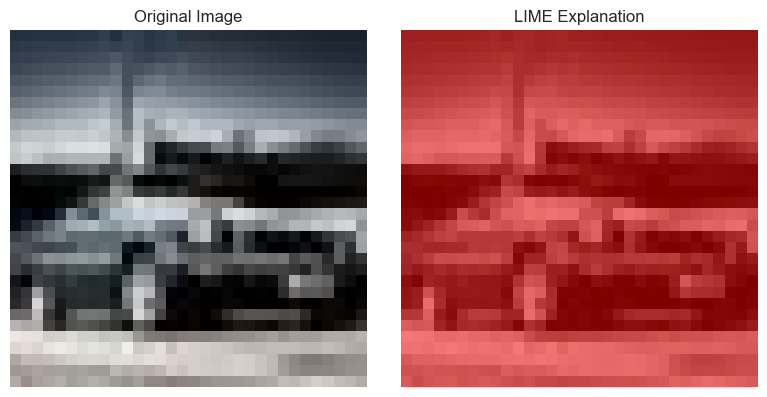

  0%|          | 0/1000 [00:00<?, ?it/s]

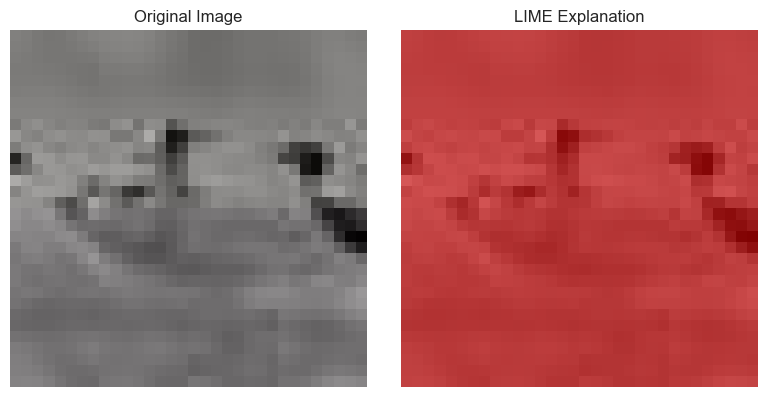

  0%|          | 0/1000 [00:00<?, ?it/s]

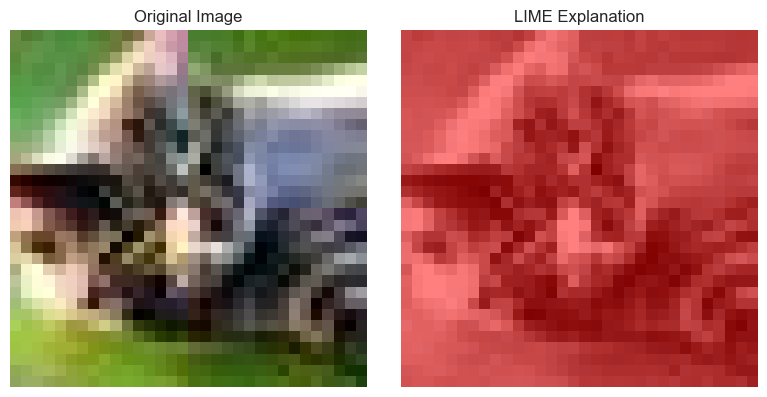

  0%|          | 0/1000 [00:00<?, ?it/s]

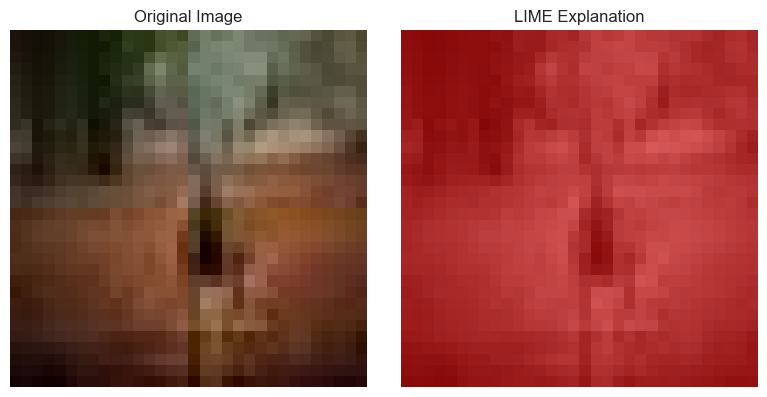

  0%|          | 0/1000 [00:00<?, ?it/s]

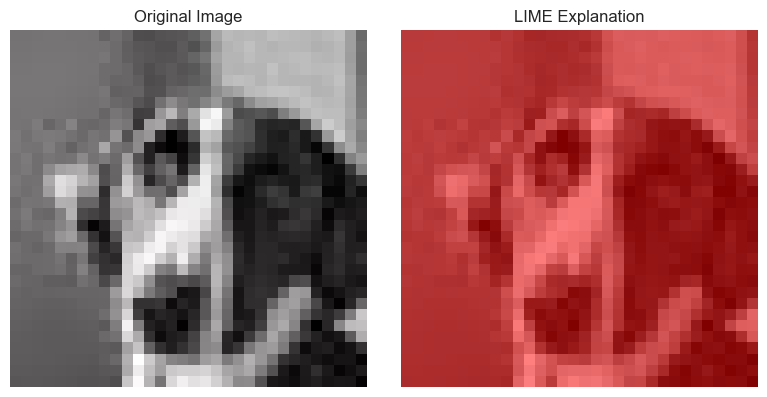

  0%|          | 0/1000 [00:00<?, ?it/s]

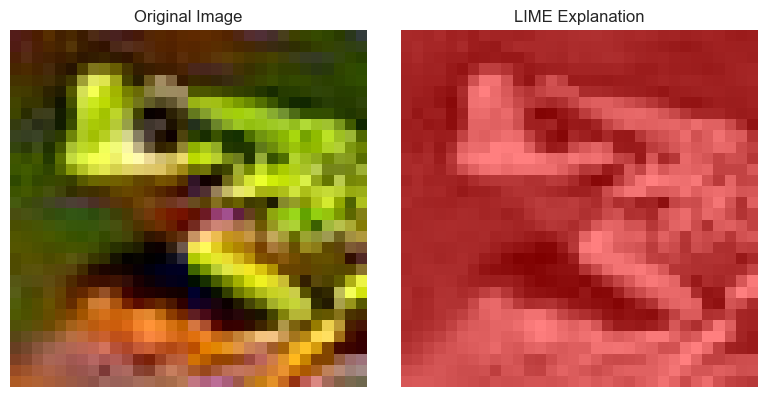

  0%|          | 0/1000 [00:00<?, ?it/s]

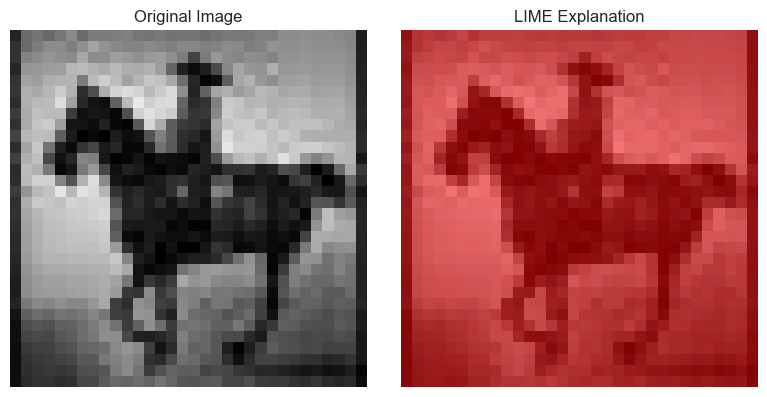

  0%|          | 0/1000 [00:00<?, ?it/s]

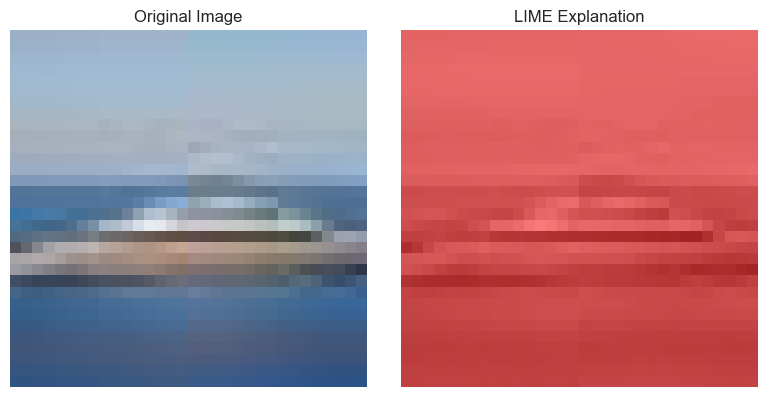

  0%|          | 0/1000 [00:00<?, ?it/s]

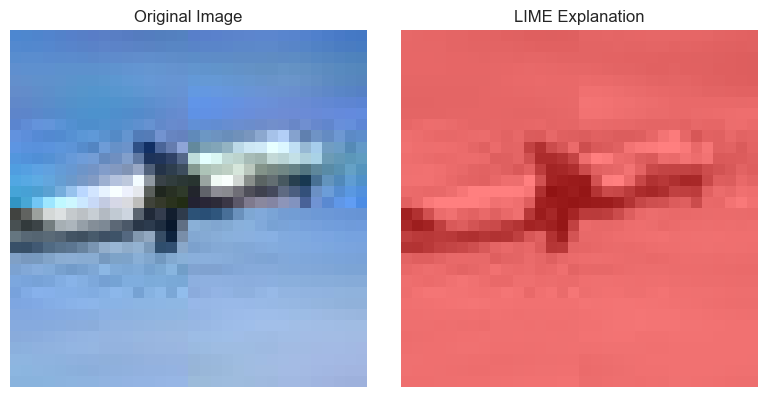

In [118]:
for i in range(len(fake)):
    lime_mapper(model, image_path=fake[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

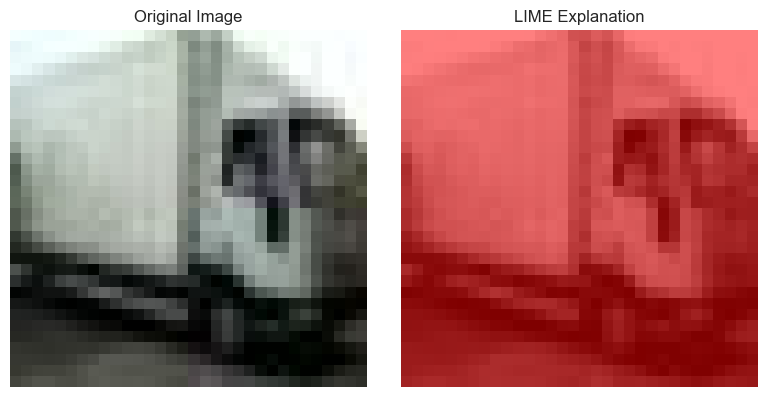

  0%|          | 0/1000 [00:00<?, ?it/s]

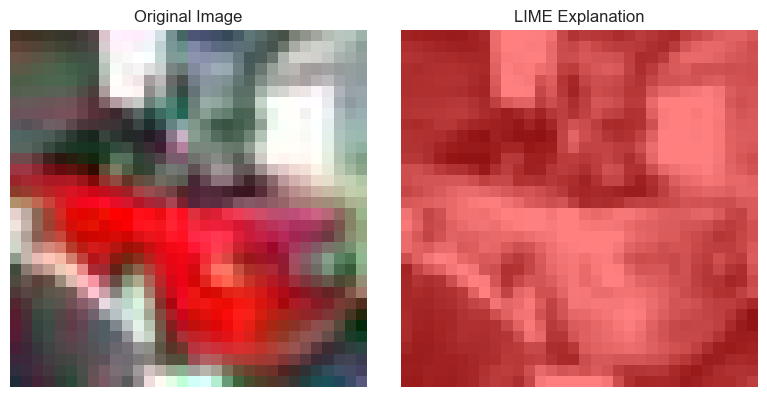

  0%|          | 0/1000 [00:00<?, ?it/s]

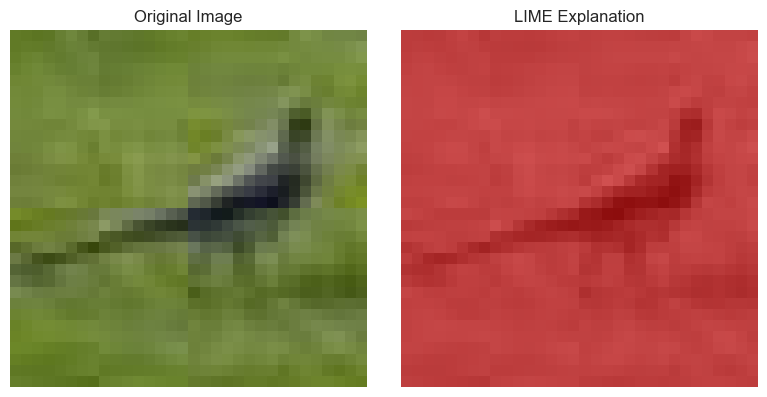

  0%|          | 0/1000 [00:00<?, ?it/s]

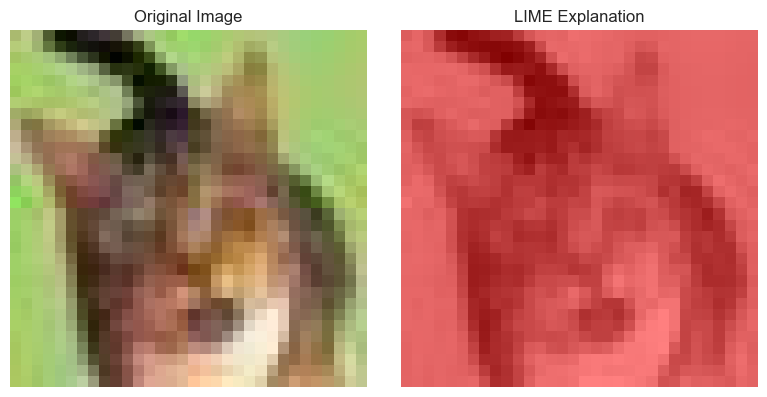

  0%|          | 0/1000 [00:00<?, ?it/s]

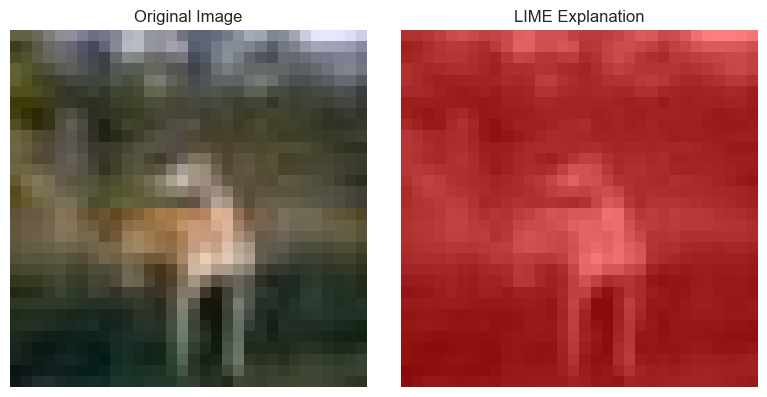

  0%|          | 0/1000 [00:00<?, ?it/s]

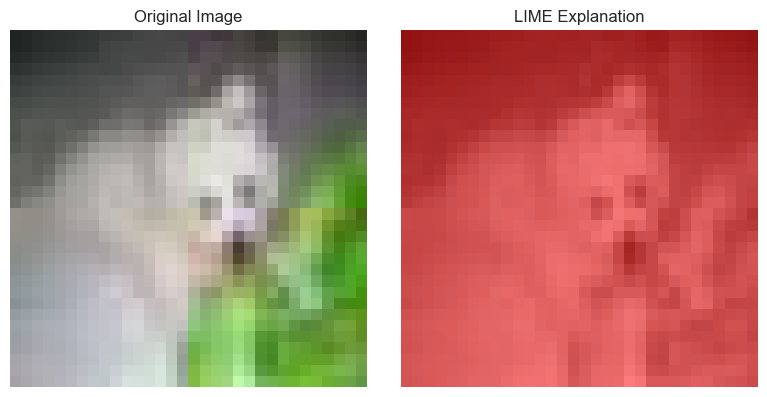

  0%|          | 0/1000 [00:00<?, ?it/s]

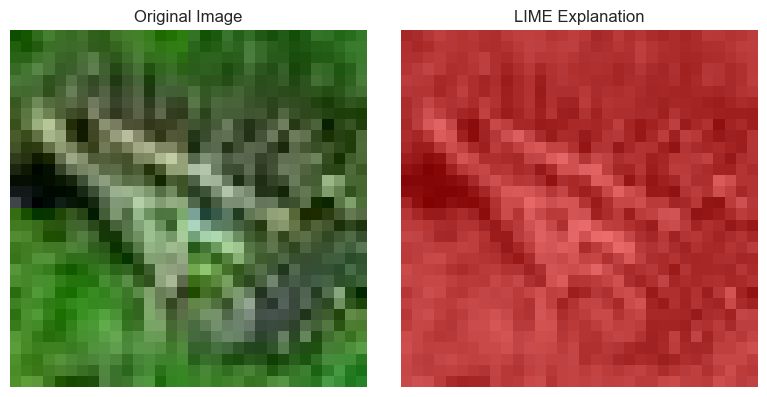

  0%|          | 0/1000 [00:00<?, ?it/s]

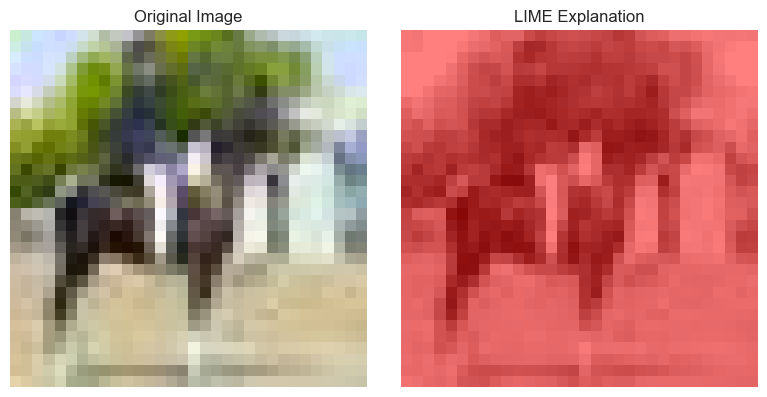

  0%|          | 0/1000 [00:00<?, ?it/s]

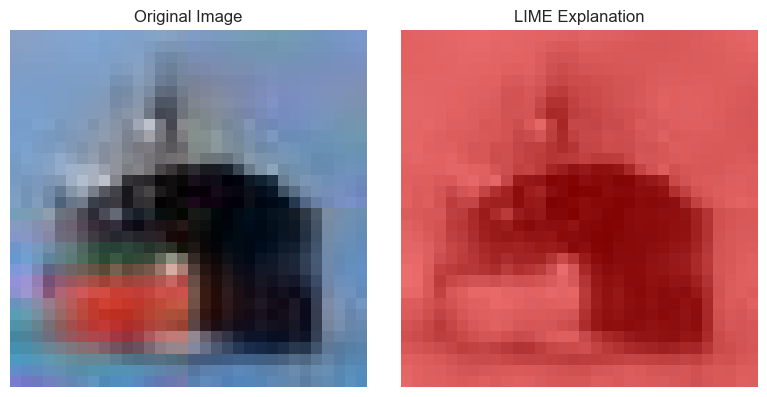

  0%|          | 0/1000 [00:00<?, ?it/s]

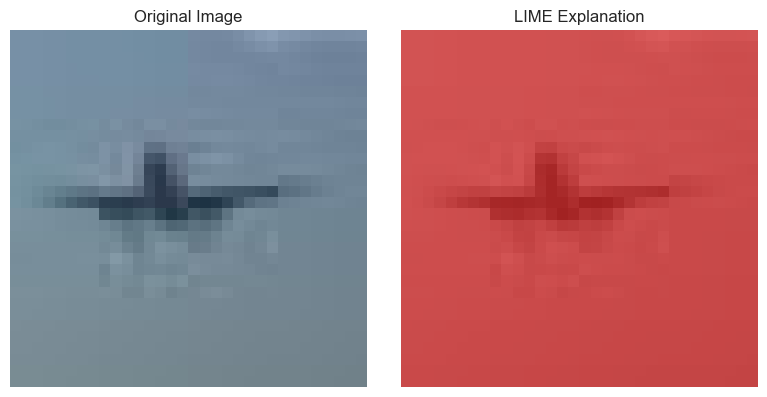

In [119]:
for i in range(len(real)):
    lime_mapper(model, image_path=real[i][0])

In [63]:
test_data.samples[11212]

('dataset/test/REAL\\0121 (3).jpg', 1)

In [120]:
real1 = test_data.samples[11210:11220]
real1

[('dataset/test/REAL\\0121 (10).jpg', 1),
 ('dataset/test/REAL\\0121 (2).jpg', 1),
 ('dataset/test/REAL\\0121 (3).jpg', 1),
 ('dataset/test/REAL\\0121 (4).jpg', 1),
 ('dataset/test/REAL\\0121 (5).jpg', 1),
 ('dataset/test/REAL\\0121 (6).jpg', 1),
 ('dataset/test/REAL\\0121 (7).jpg', 1),
 ('dataset/test/REAL\\0121 (8).jpg', 1),
 ('dataset/test/REAL\\0121 (9).jpg', 1),
 ('dataset/test/REAL\\0121.jpg', 1)]

In [121]:
fake1 = test_data.samples[260:270]
fake1

[('dataset/test/FAKE\\121 (10).jpg', 0),
 ('dataset/test/FAKE\\121 (2).jpg', 0),
 ('dataset/test/FAKE\\121 (3).jpg', 0),
 ('dataset/test/FAKE\\121 (4).jpg', 0),
 ('dataset/test/FAKE\\121 (5).jpg', 0),
 ('dataset/test/FAKE\\121 (6).jpg', 0),
 ('dataset/test/FAKE\\121 (7).jpg', 0),
 ('dataset/test/FAKE\\121 (8).jpg', 0),
 ('dataset/test/FAKE\\121 (9).jpg', 0),
 ('dataset/test/FAKE\\121.jpg', 0)]

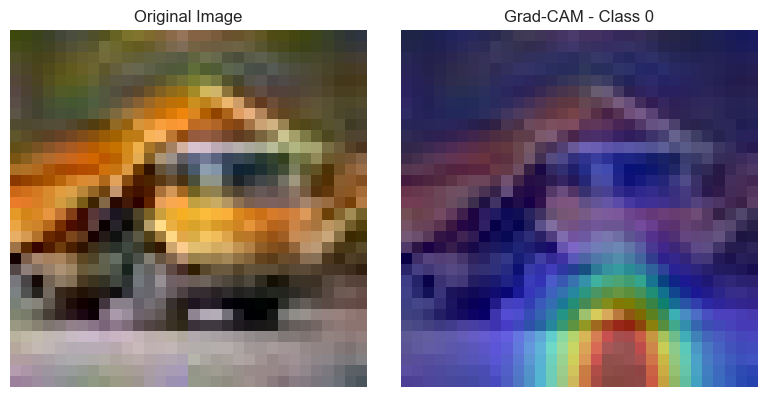

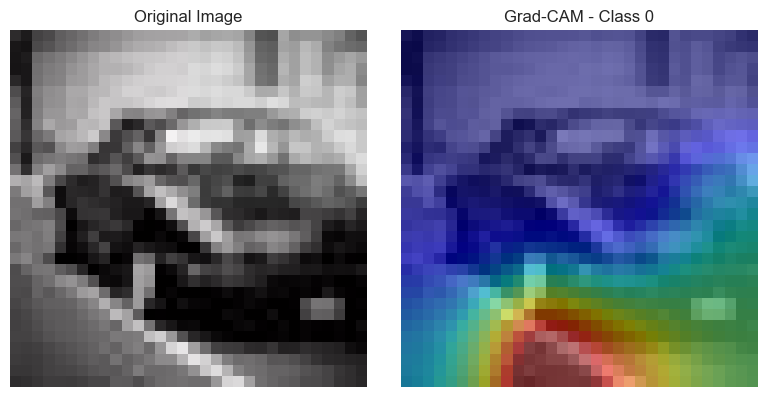

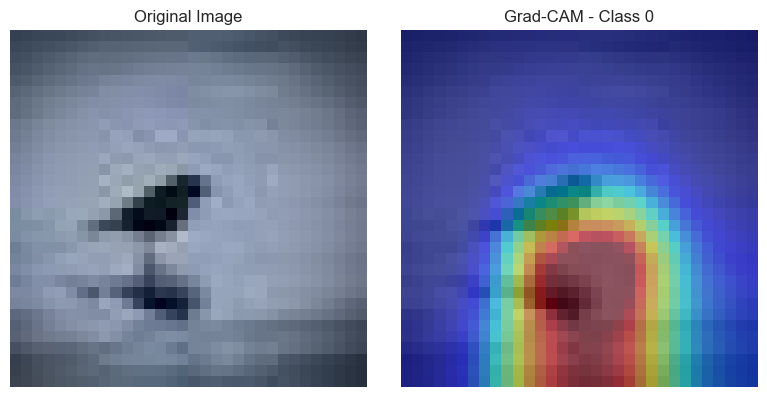

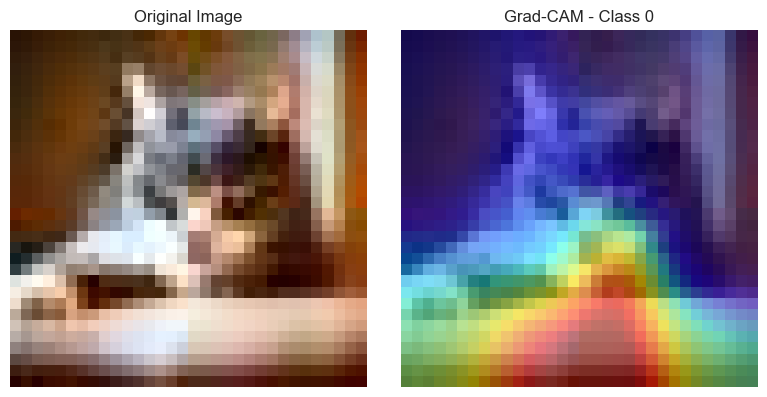

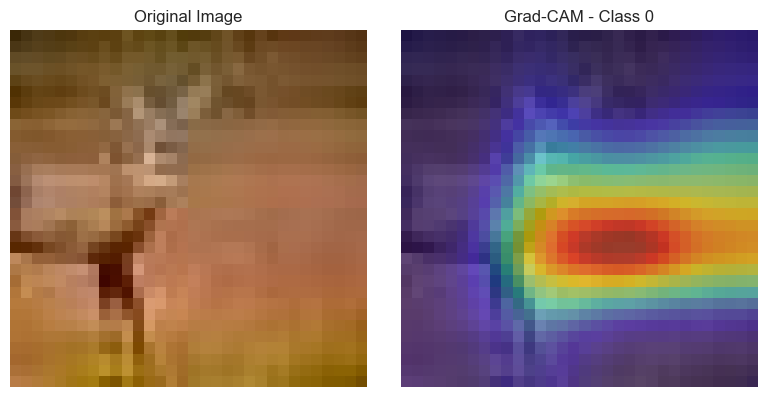

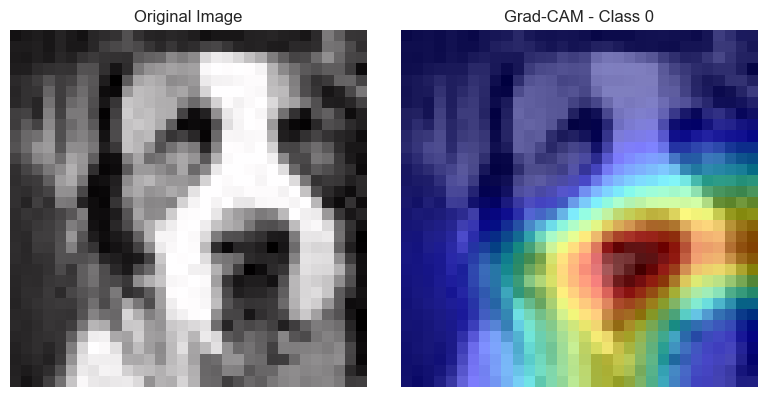

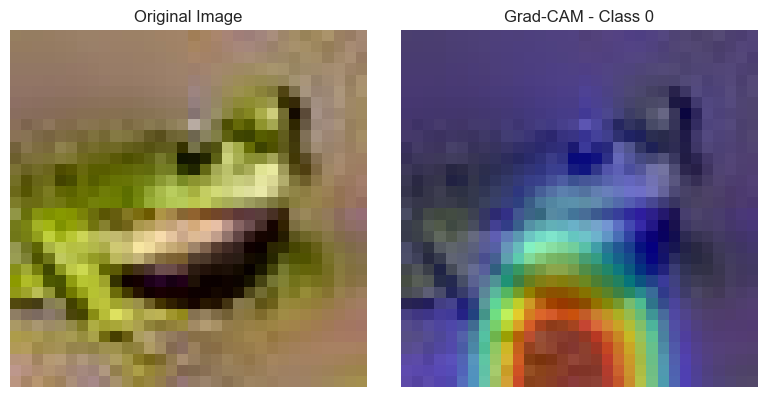

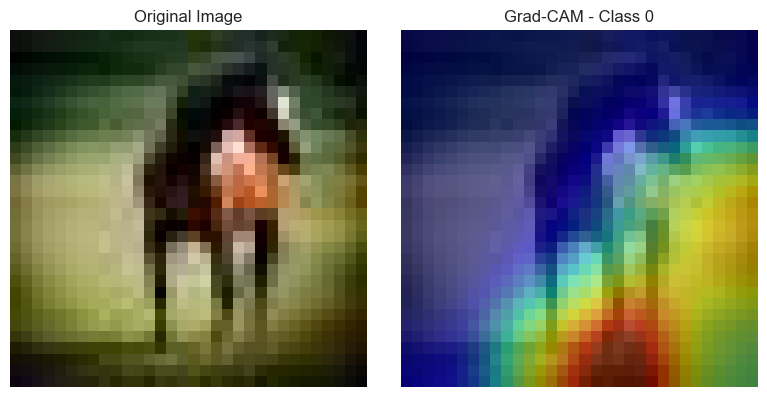

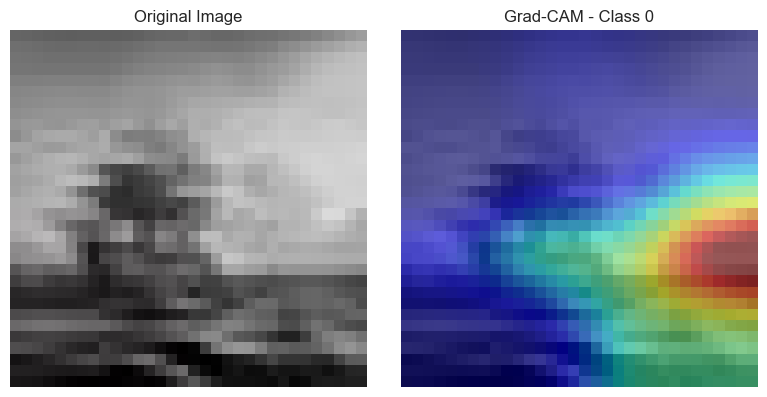

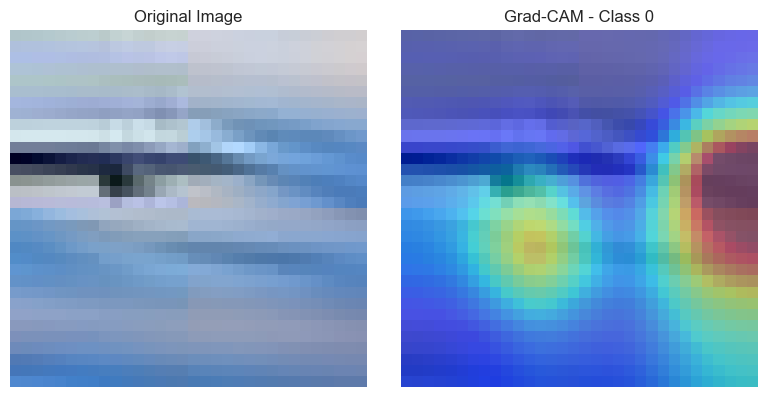

In [87]:
for i in range(len(fake1)):
    cam_mapper(model, image=fake1[i][0])

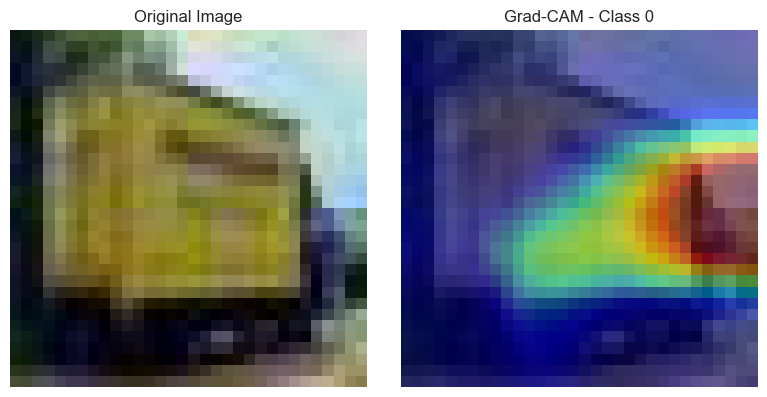

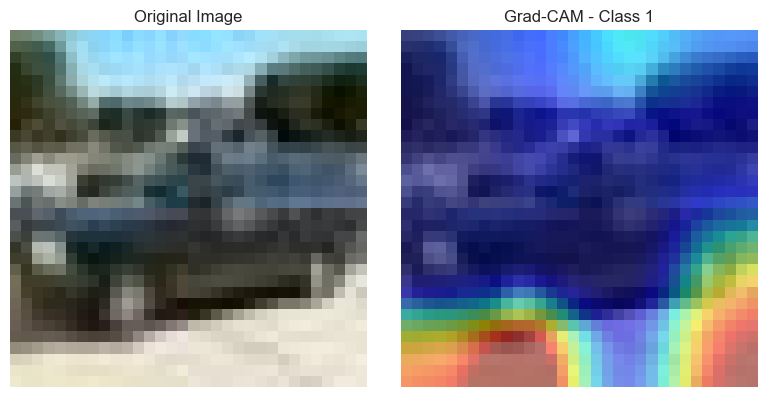

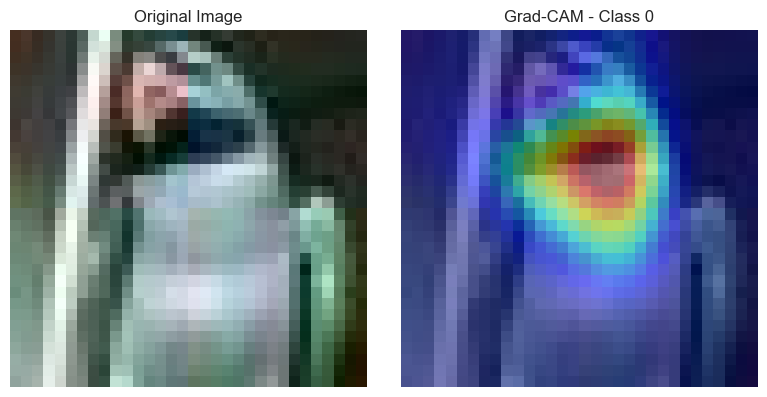

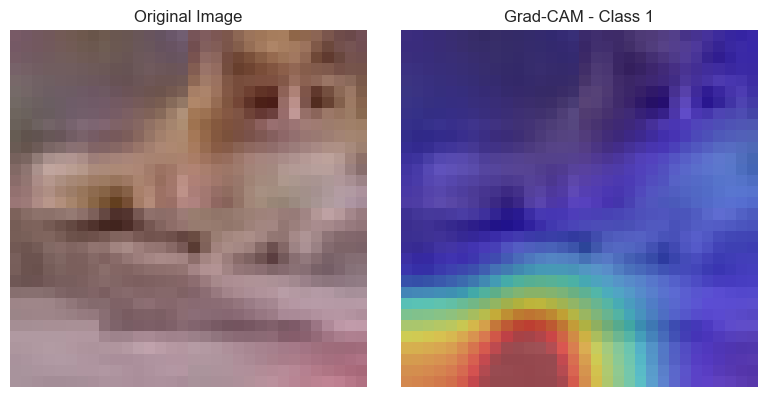

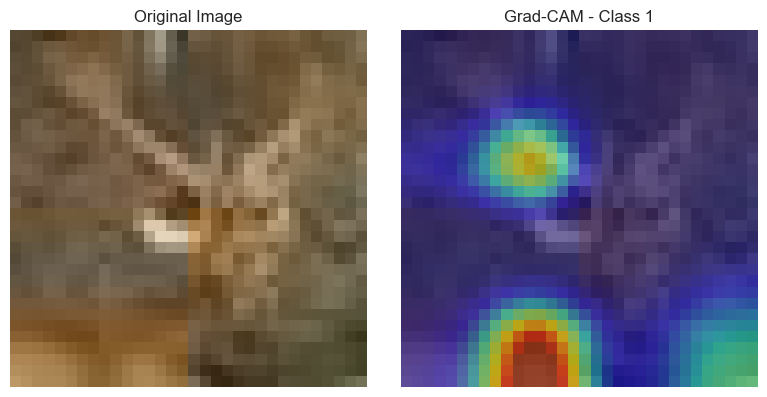

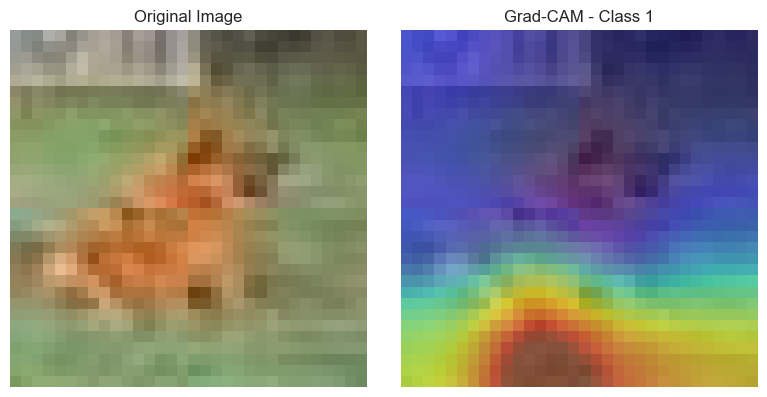

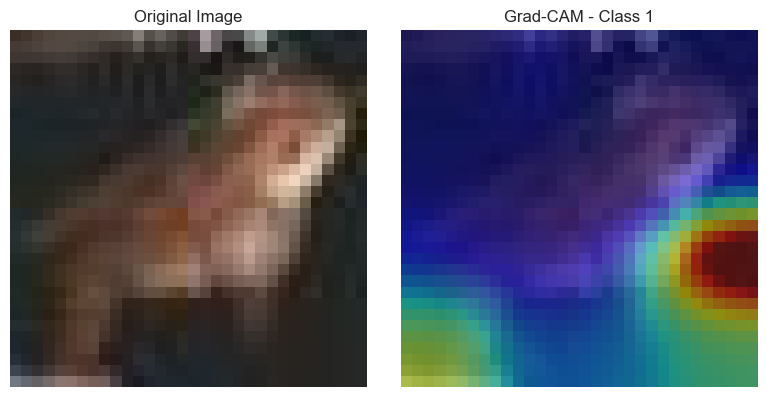

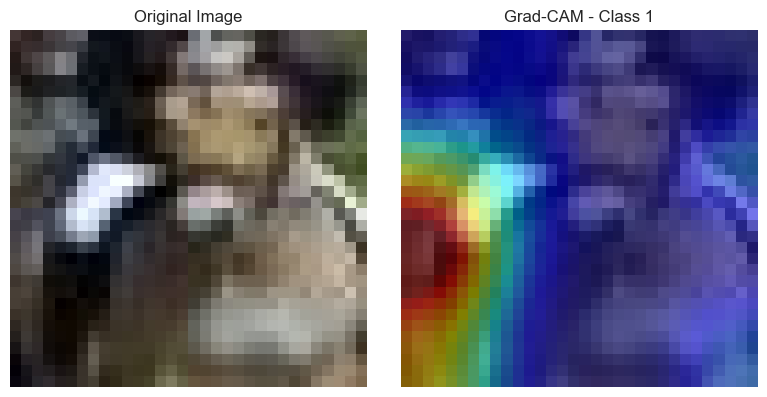

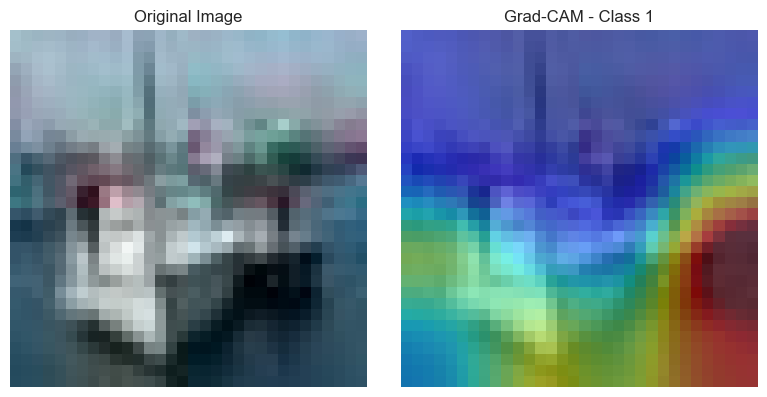

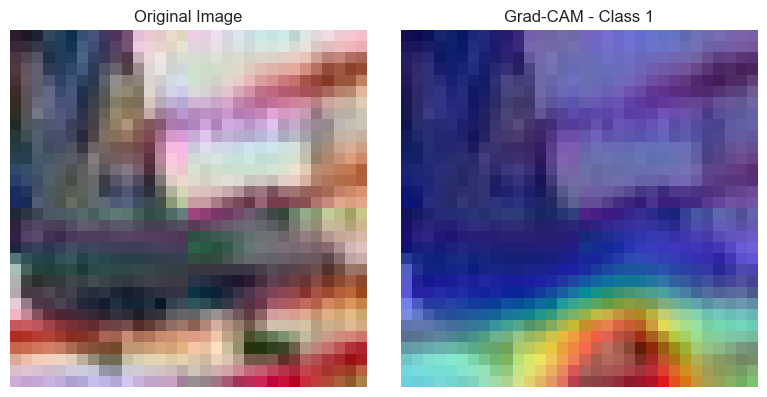

In [88]:
for i in range(len(real1)):
    cam_mapper(model, image=real1[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

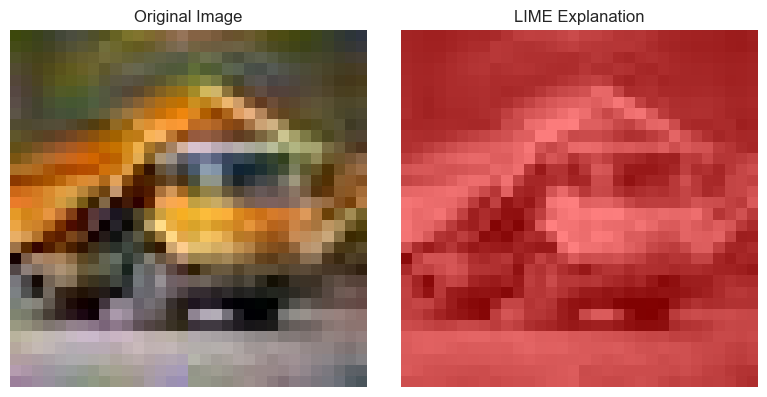

  0%|          | 0/1000 [00:00<?, ?it/s]

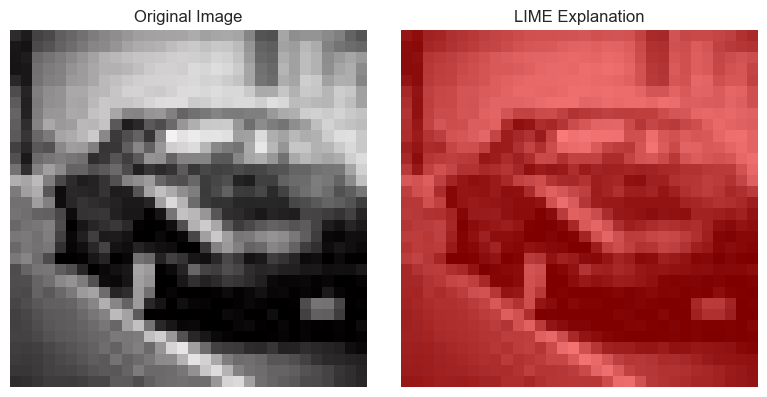

  0%|          | 0/1000 [00:00<?, ?it/s]

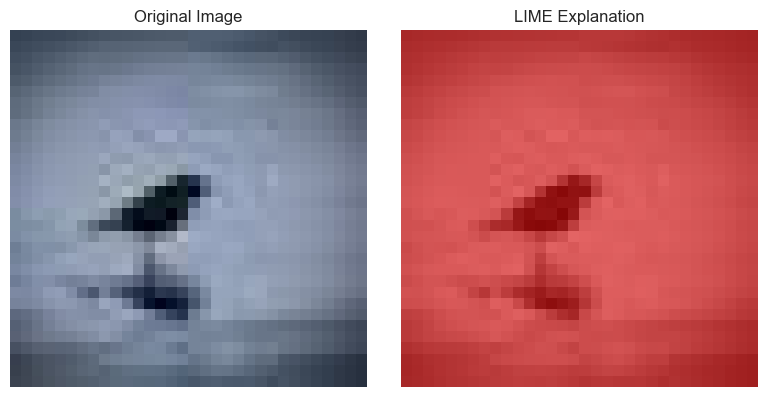

  0%|          | 0/1000 [00:00<?, ?it/s]

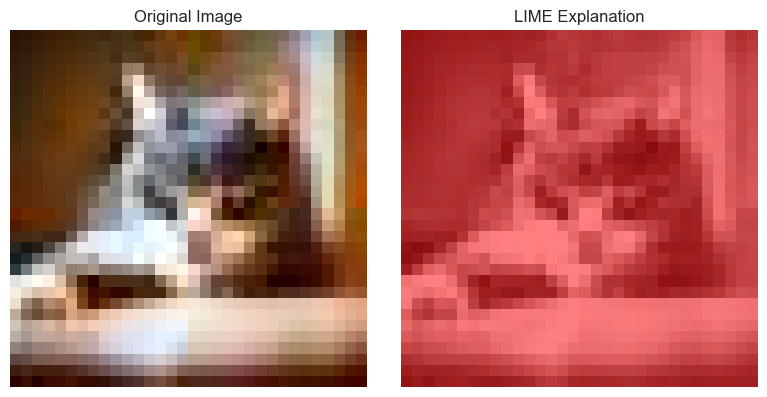

  0%|          | 0/1000 [00:00<?, ?it/s]

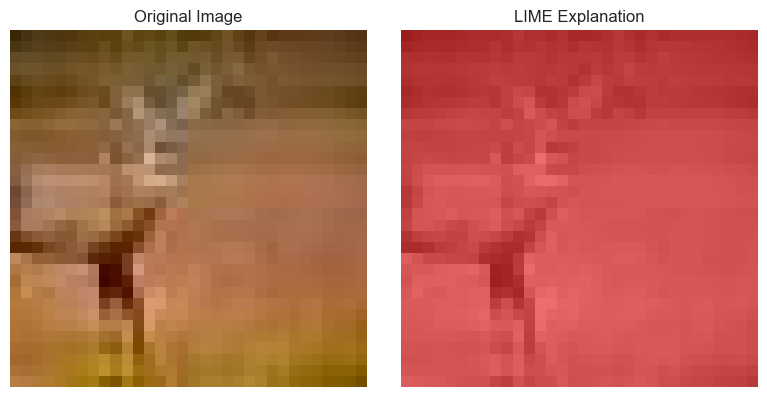

  0%|          | 0/1000 [00:00<?, ?it/s]

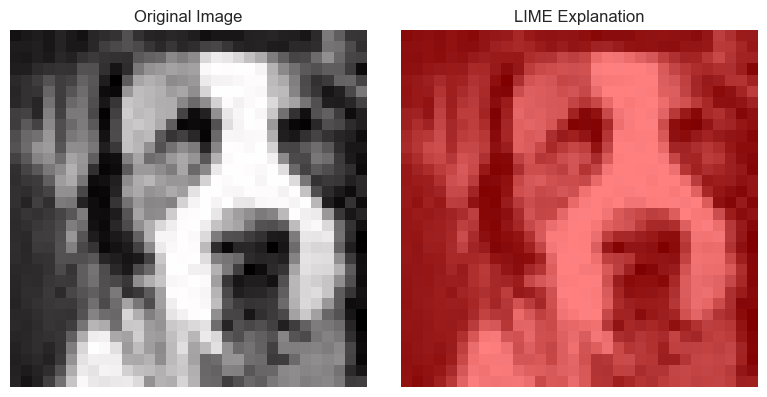

  0%|          | 0/1000 [00:00<?, ?it/s]

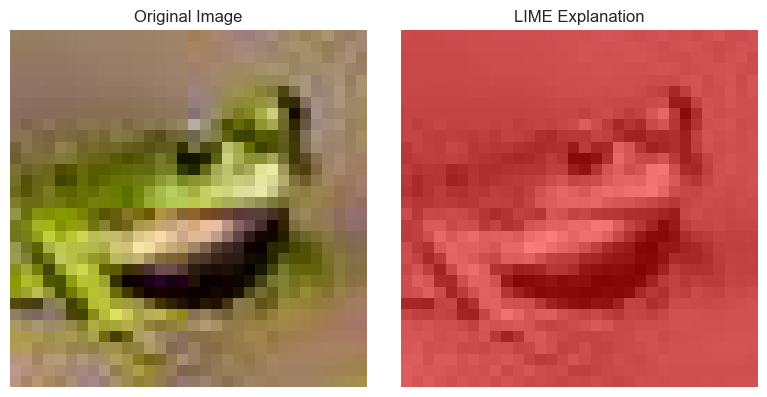

  0%|          | 0/1000 [00:00<?, ?it/s]

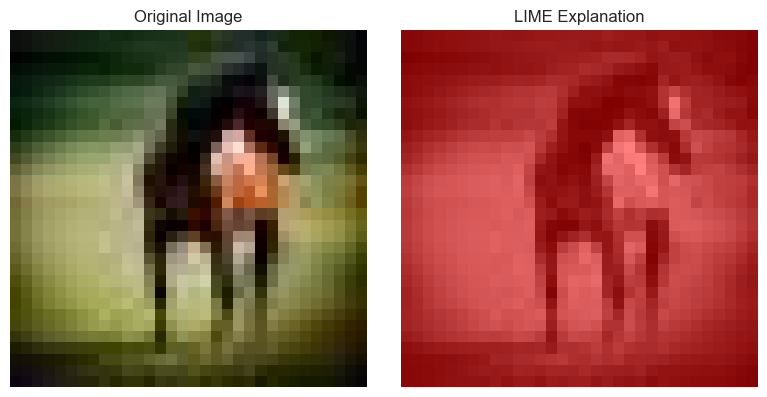

  0%|          | 0/1000 [00:00<?, ?it/s]

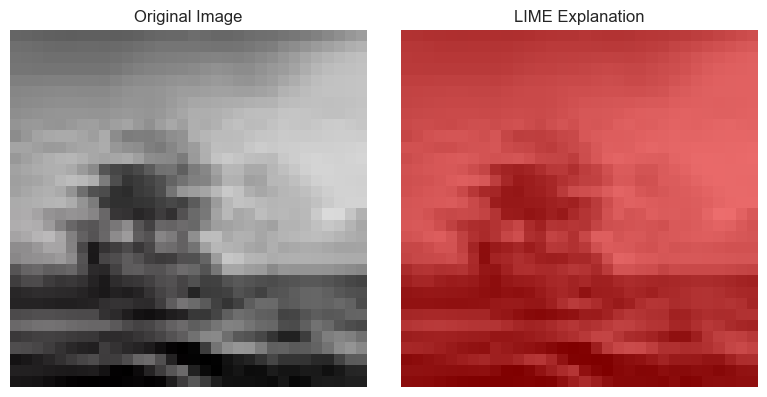

  0%|          | 0/1000 [00:00<?, ?it/s]

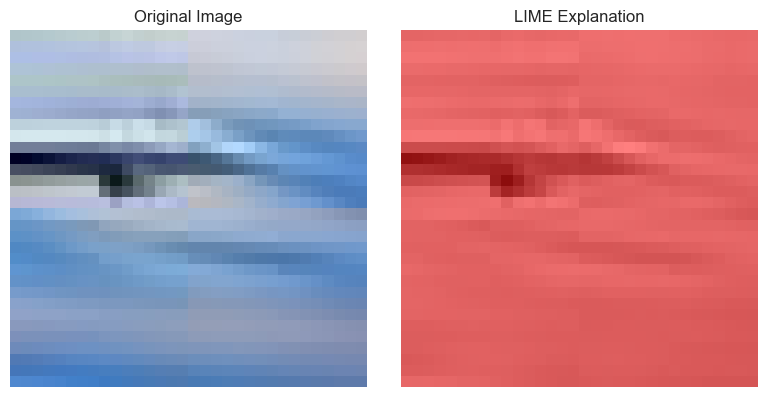

In [124]:
for i in range(len(fake1)):
    lime_mapper(model, image_path=fake1[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

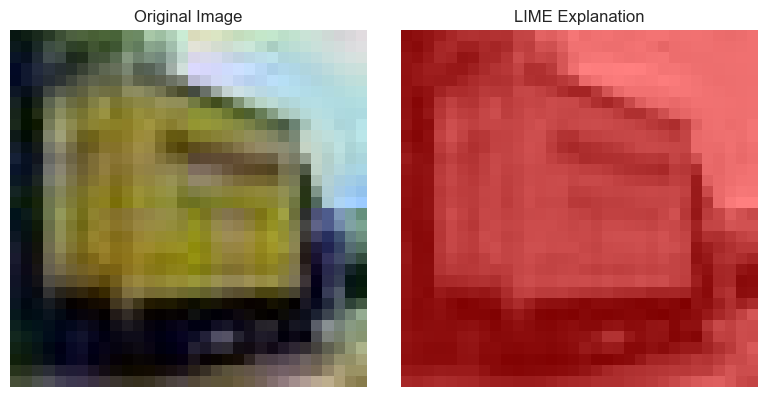

  0%|          | 0/1000 [00:00<?, ?it/s]

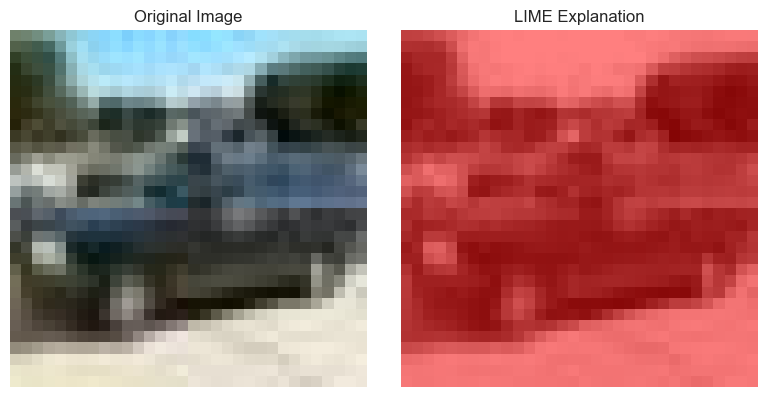

  0%|          | 0/1000 [00:00<?, ?it/s]

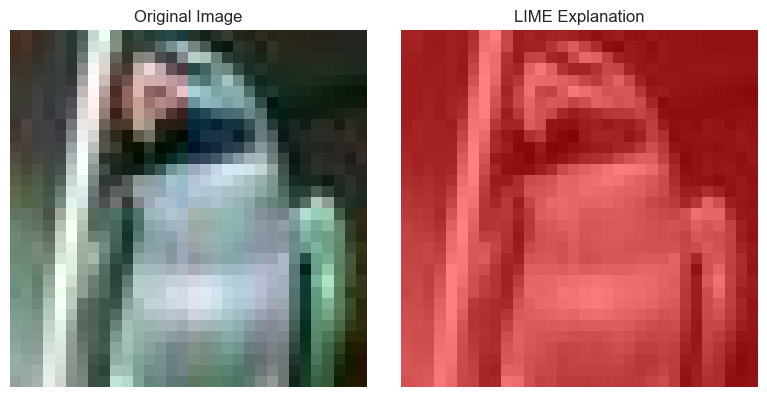

  0%|          | 0/1000 [00:00<?, ?it/s]

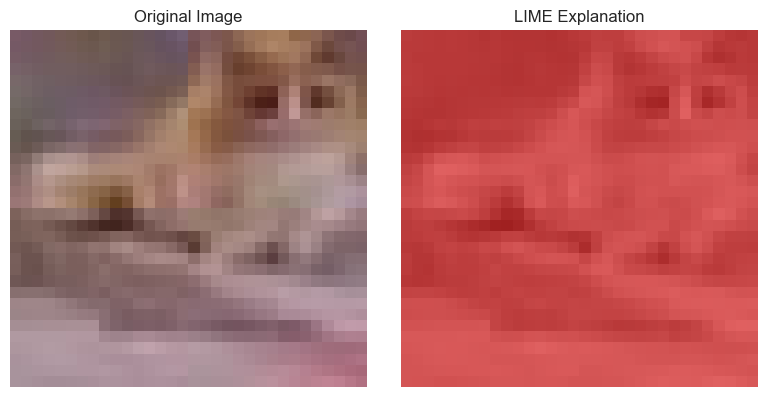

  0%|          | 0/1000 [00:00<?, ?it/s]

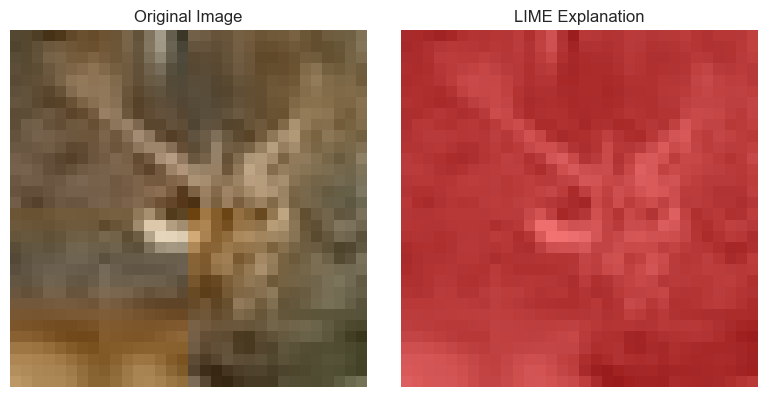

  0%|          | 0/1000 [00:00<?, ?it/s]

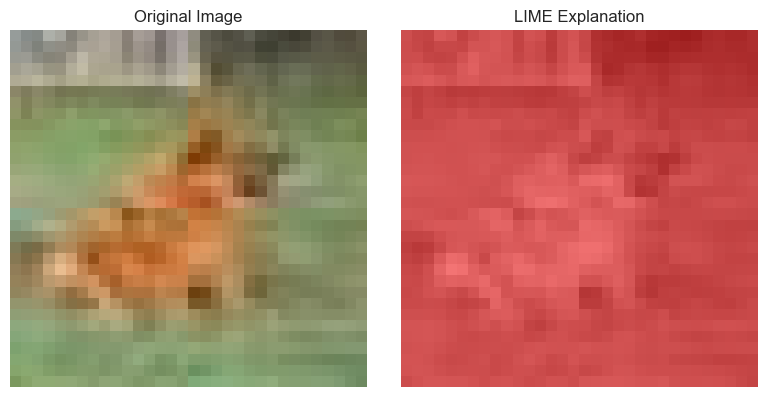

  0%|          | 0/1000 [00:00<?, ?it/s]

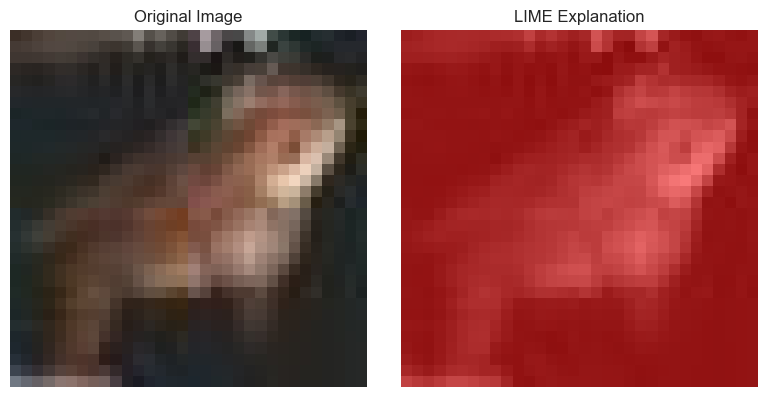

  0%|          | 0/1000 [00:00<?, ?it/s]

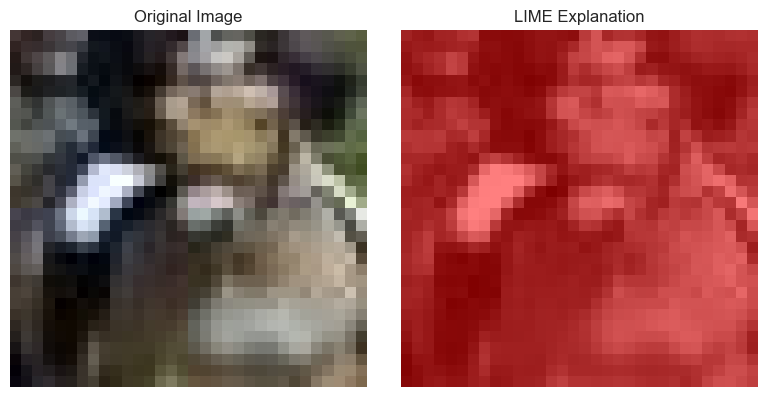

  0%|          | 0/1000 [00:00<?, ?it/s]

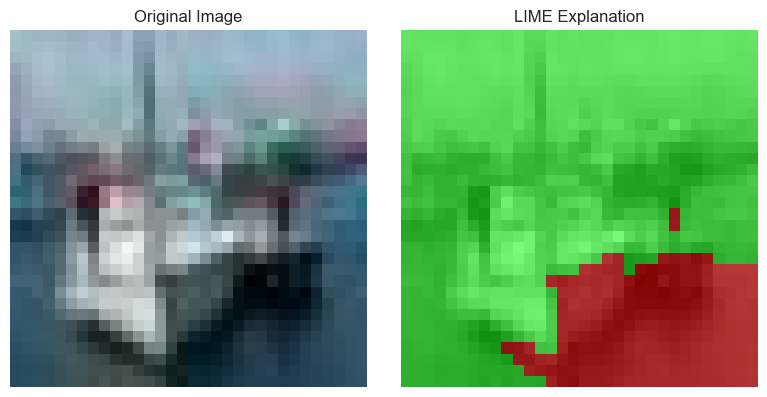

  0%|          | 0/1000 [00:00<?, ?it/s]

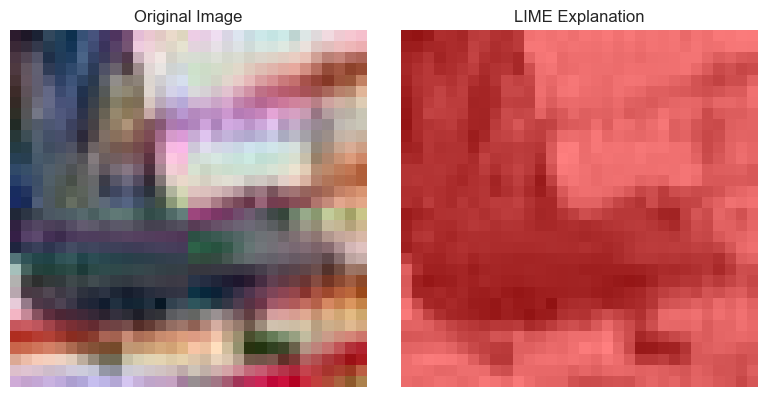

In [125]:
for i in range(len(real1)):
    lime_mapper(model, image_path=real1[i][0])

In [ ]:
selected_fake_fake = [7786, 4154, 7433, 6008, 6116, 9227, 7506, 5958, 1121, 1465]
selected_fake_real = [6284, 5792, 3692, 212, 6875, 5687, 2131, 4870, 2465, 4132]
selected_real_fake = [13949, 11212, 18791, 11152, 16471, 19542, 18931, 18764, 15377, 11623]
selected_real_real = [19865, 18531, 10577, 18205, 13565, 16712, 10323, 15840, 15348, 16320]

In [126]:
fake2 = test_data.samples[4870:4880]
real2 = test_data.samples[15370:15380]

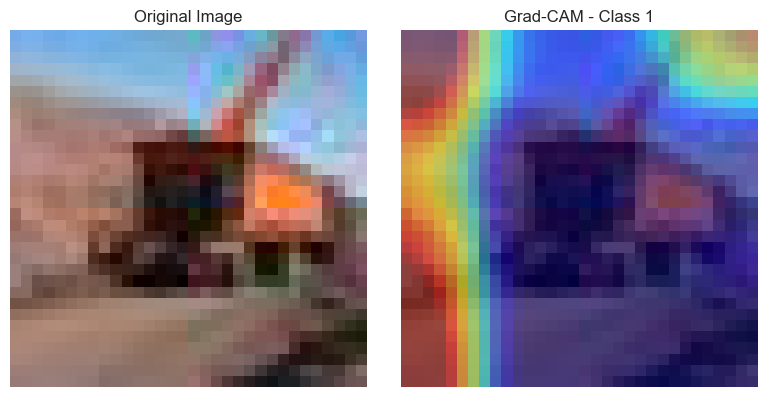

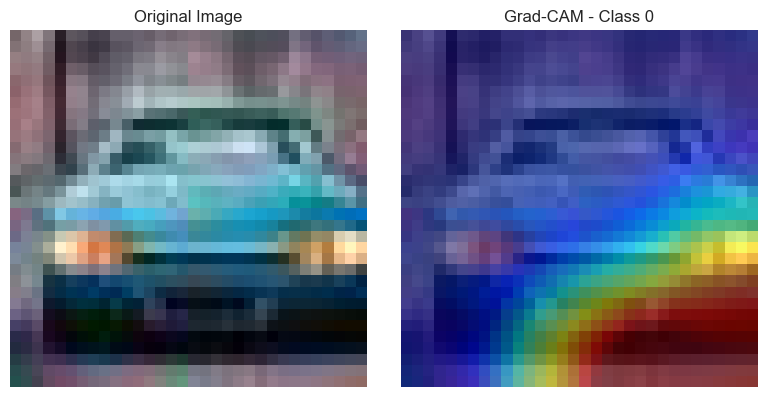

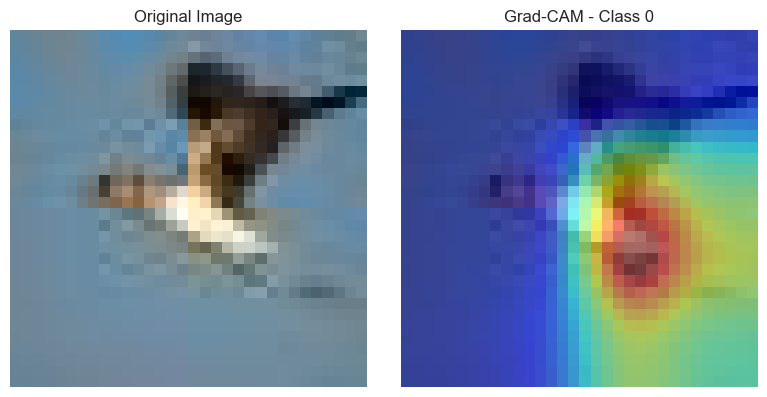

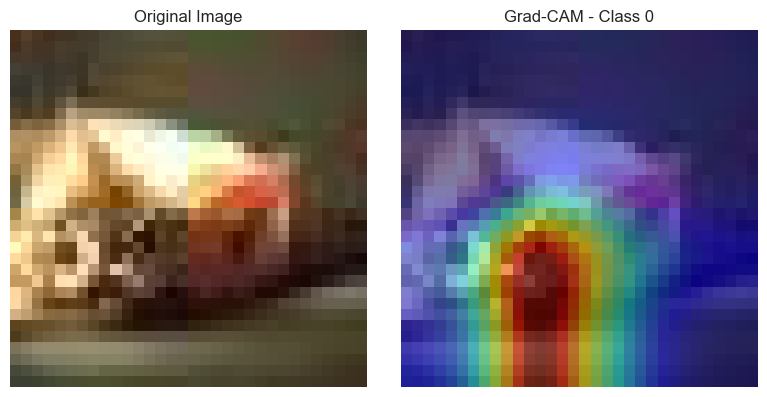

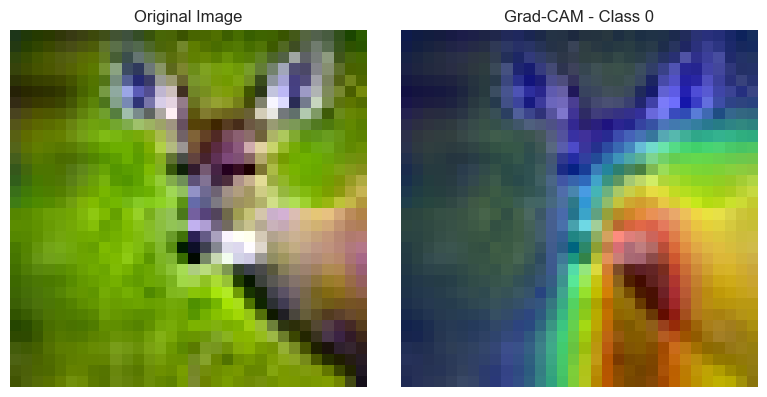

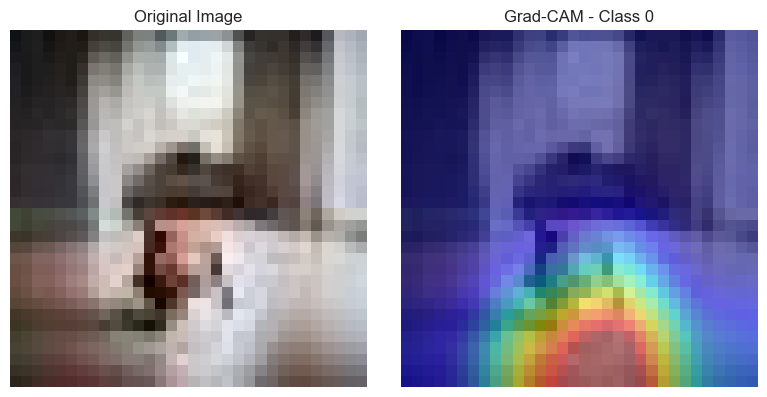

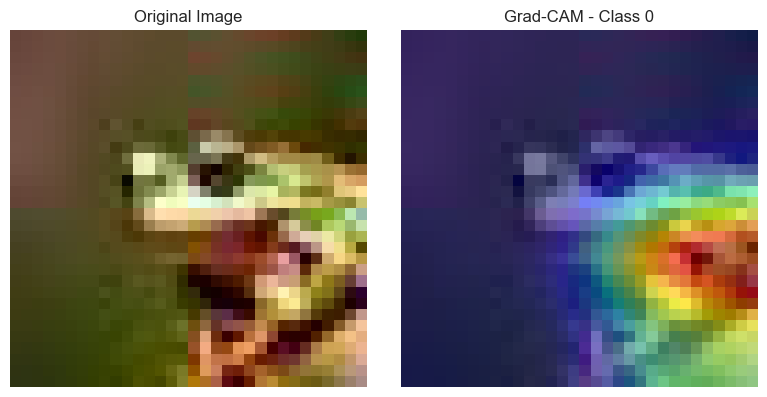

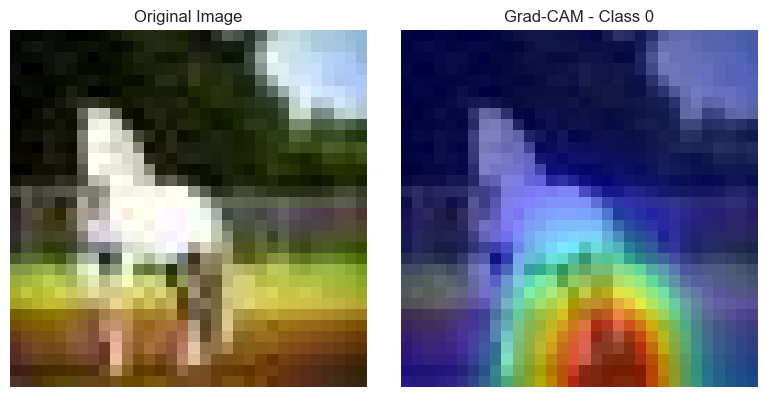

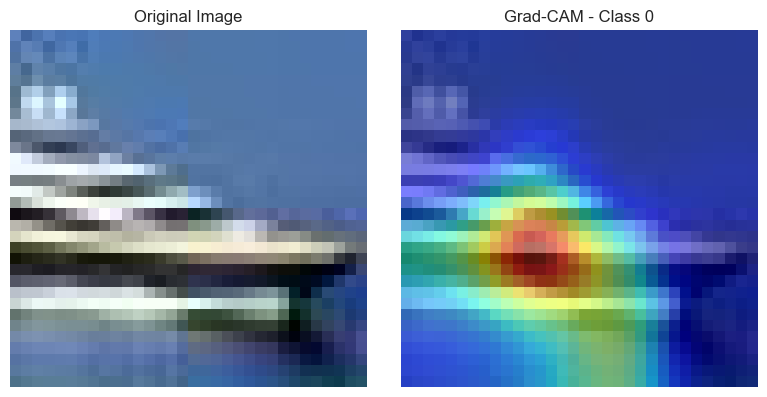

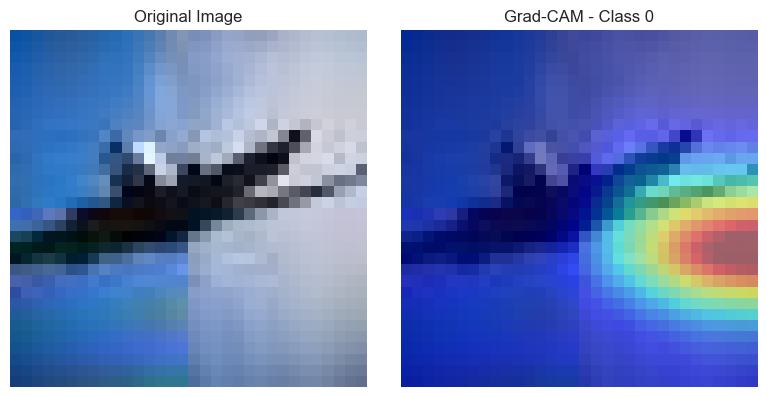

In [104]:
for i in range(len(fake2)):
    cam_mapper(model, image=fake2[i][0])

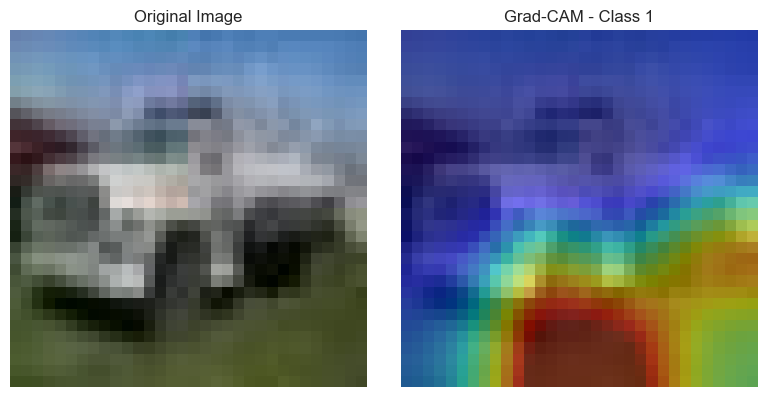

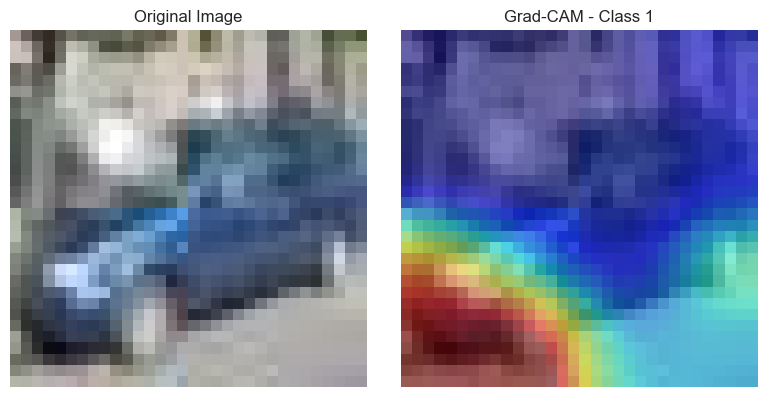

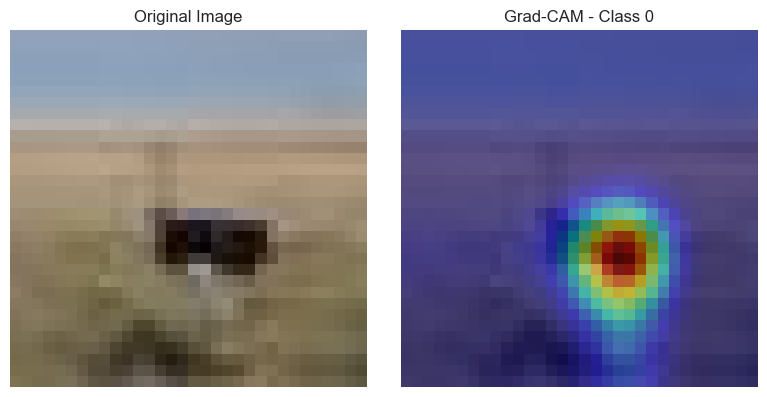

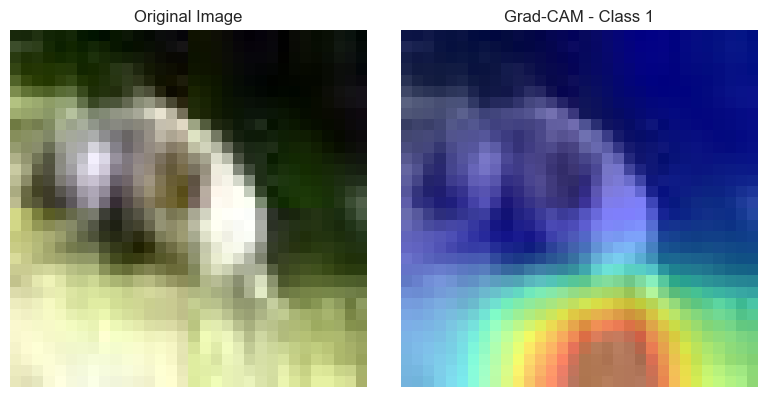

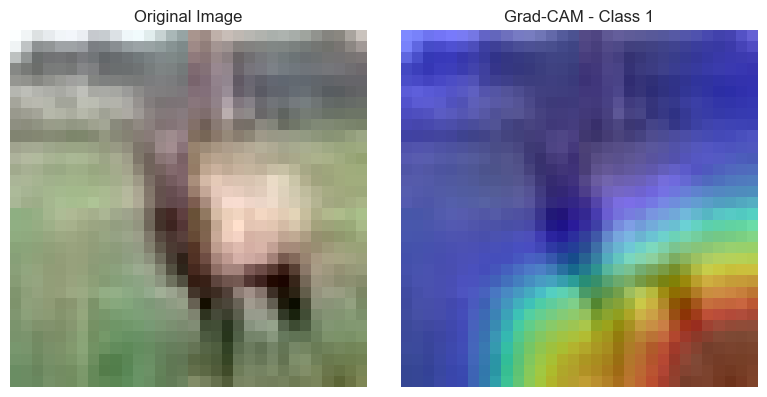

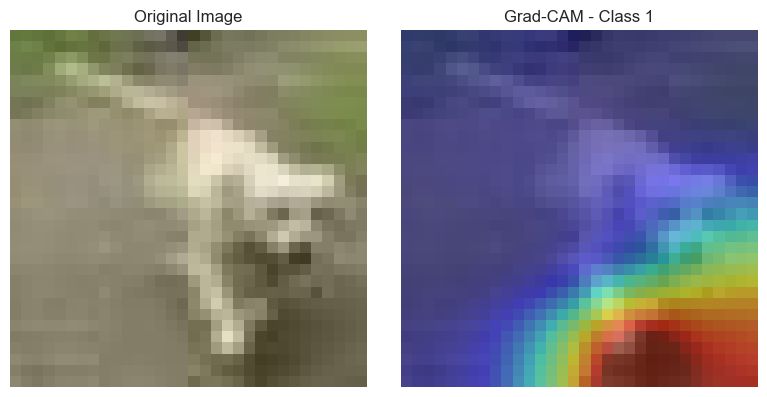

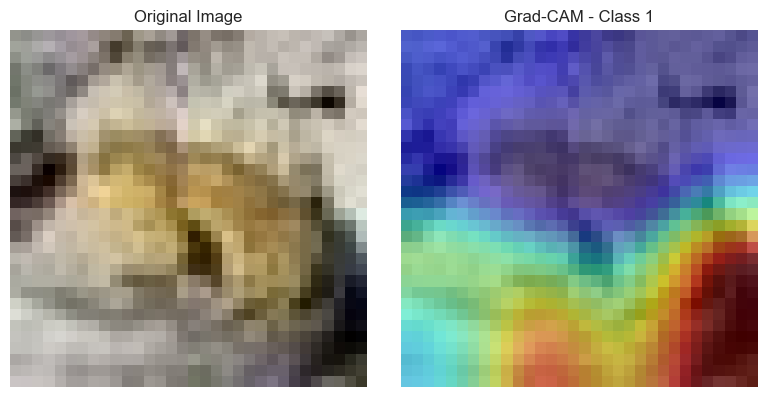

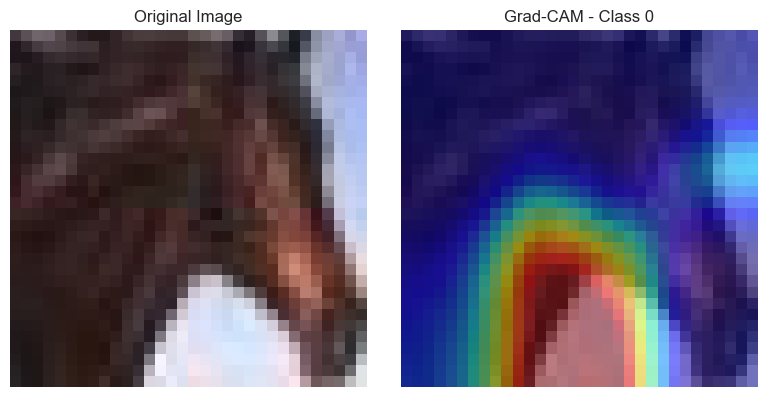

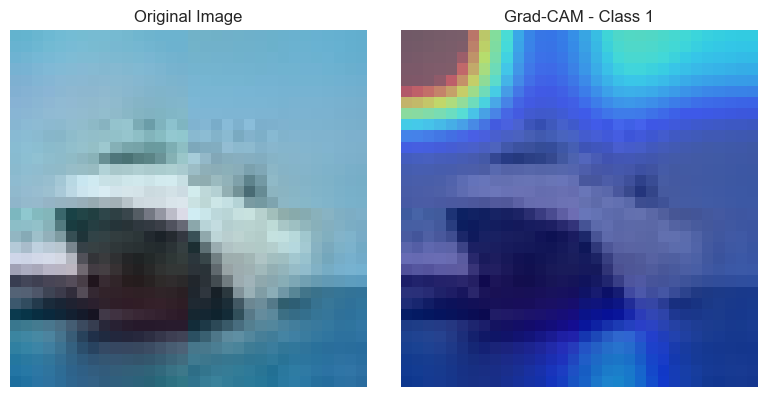

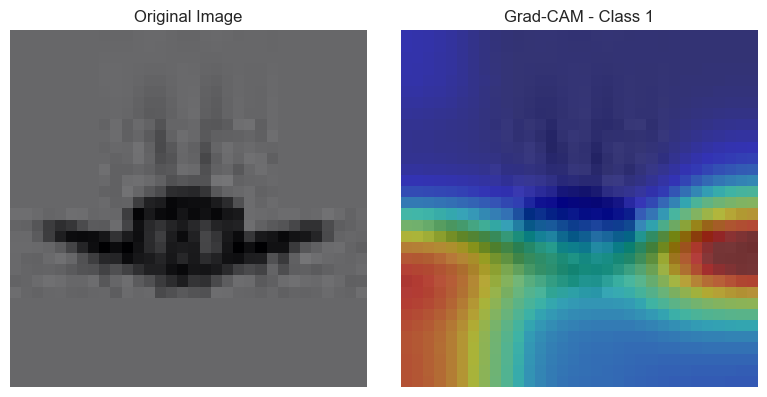

In [105]:
for i in range(len(real2)):
    cam_mapper(model, image=real2[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

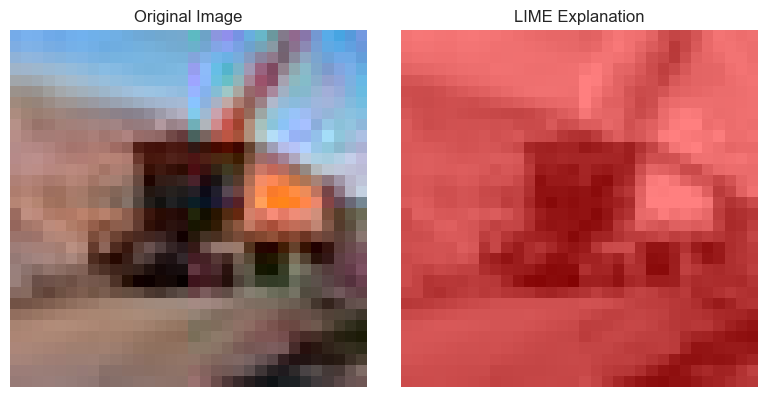

  0%|          | 0/1000 [00:00<?, ?it/s]

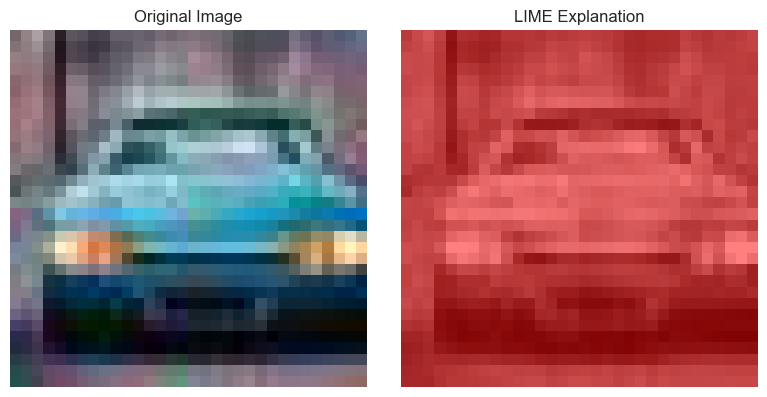

  0%|          | 0/1000 [00:00<?, ?it/s]

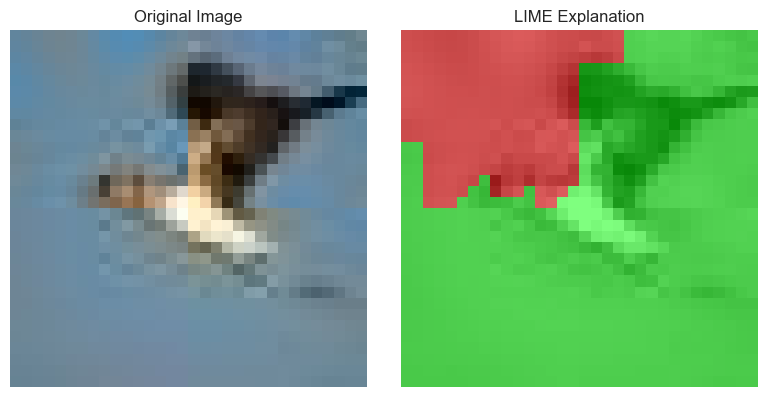

  0%|          | 0/1000 [00:00<?, ?it/s]

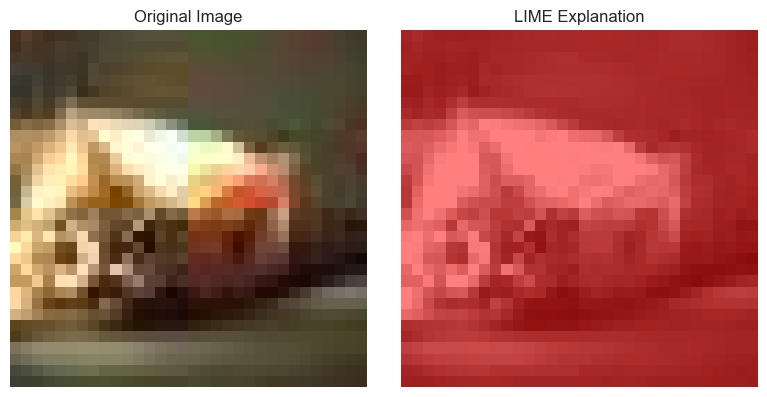

  0%|          | 0/1000 [00:00<?, ?it/s]

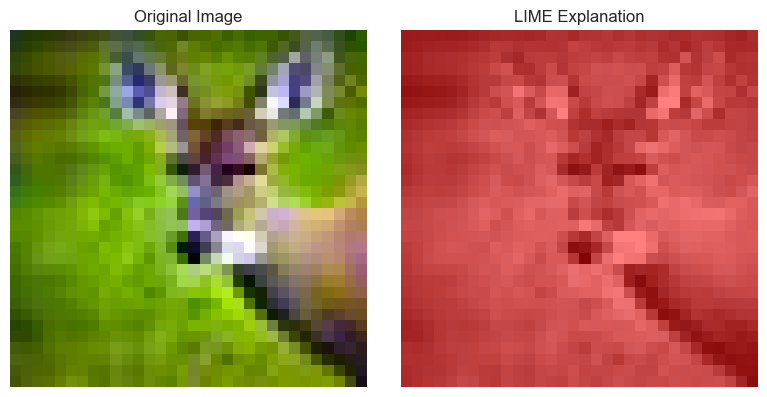

  0%|          | 0/1000 [00:00<?, ?it/s]

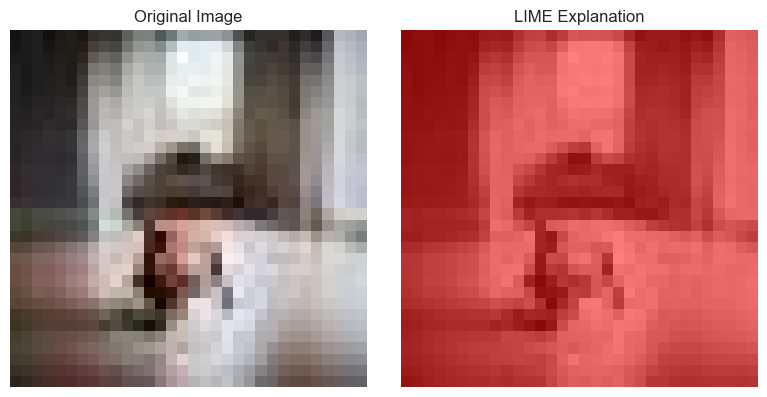

  0%|          | 0/1000 [00:00<?, ?it/s]

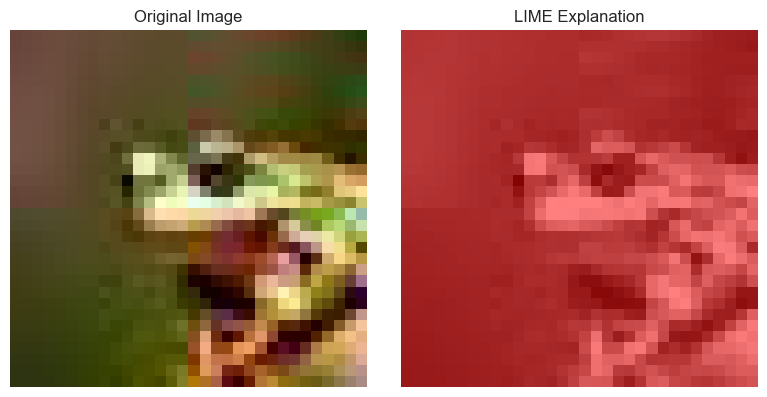

  0%|          | 0/1000 [00:00<?, ?it/s]

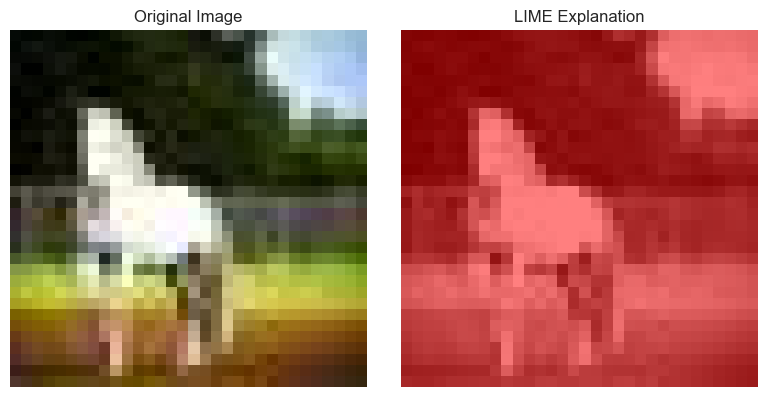

  0%|          | 0/1000 [00:00<?, ?it/s]

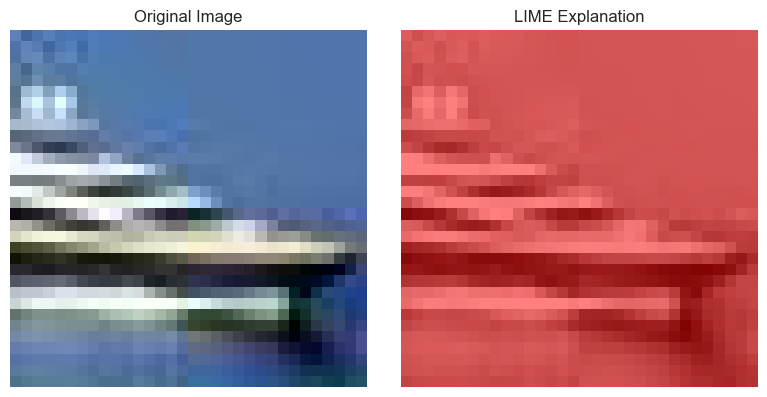

  0%|          | 0/1000 [00:00<?, ?it/s]

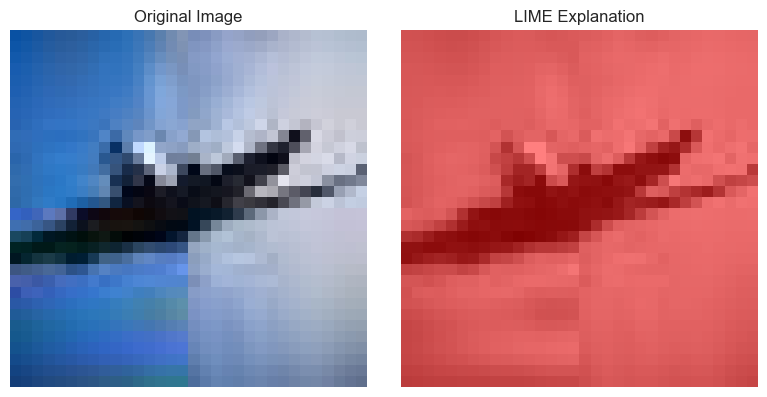

In [127]:
for i in range(len(fake2)):
    lime_mapper(model, image_path=fake2[i][0])

  0%|          | 0/1000 [00:00<?, ?it/s]

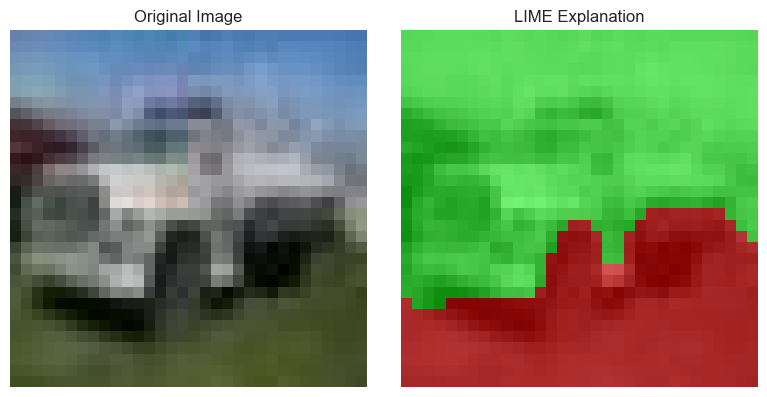

  0%|          | 0/1000 [00:00<?, ?it/s]

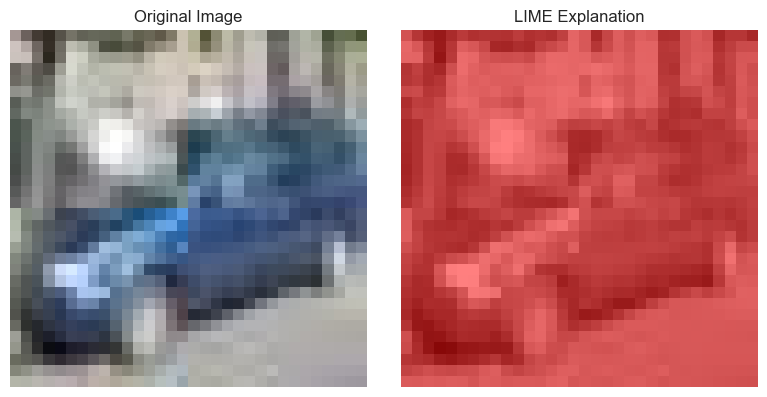

  0%|          | 0/1000 [00:00<?, ?it/s]

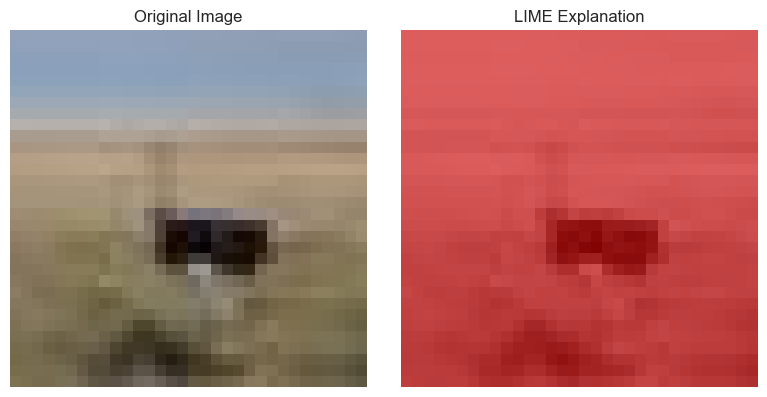

  0%|          | 0/1000 [00:00<?, ?it/s]

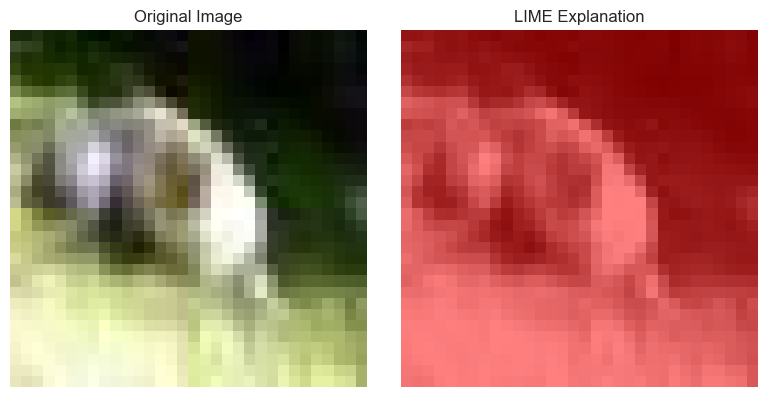

  0%|          | 0/1000 [00:00<?, ?it/s]

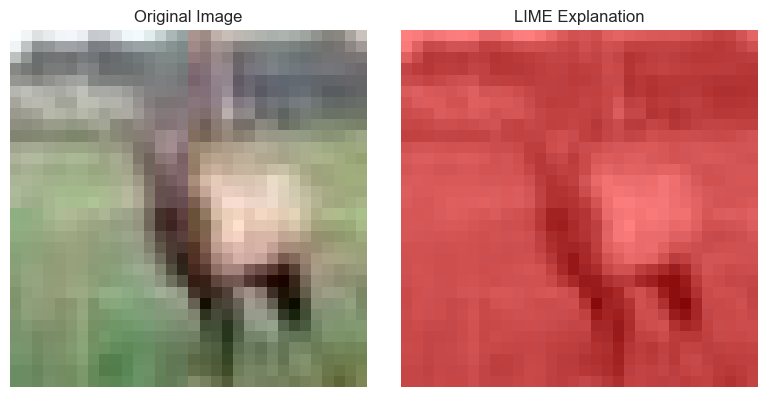

  0%|          | 0/1000 [00:00<?, ?it/s]

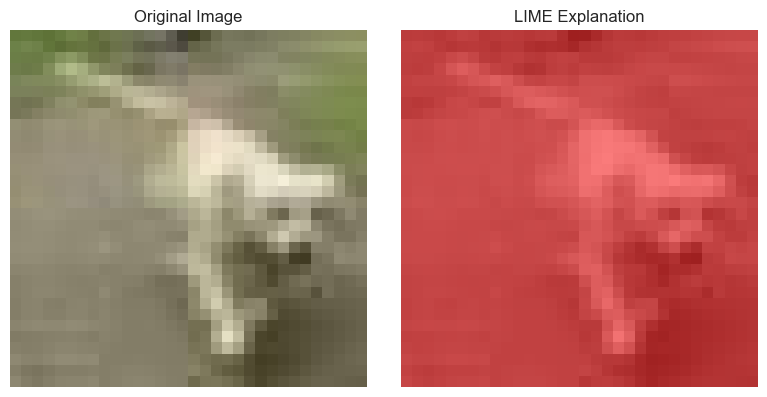

  0%|          | 0/1000 [00:00<?, ?it/s]

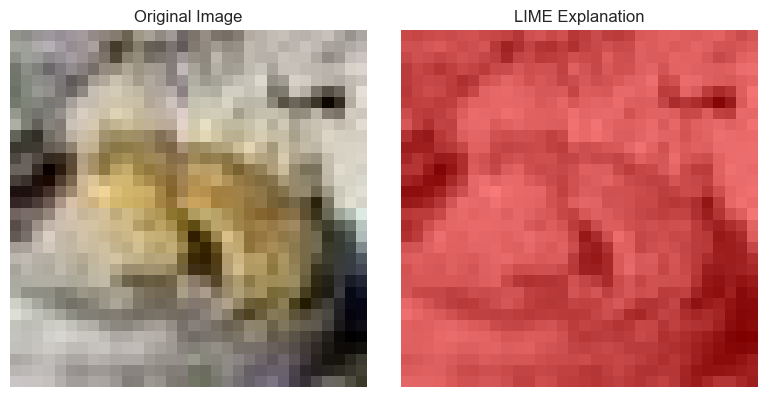

  0%|          | 0/1000 [00:00<?, ?it/s]

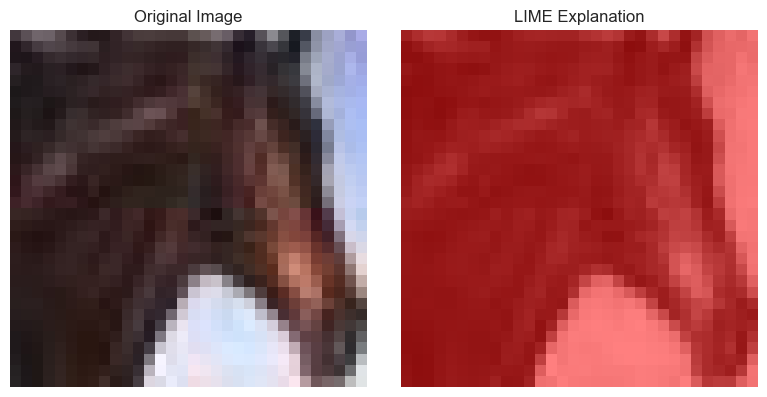

  0%|          | 0/1000 [00:00<?, ?it/s]

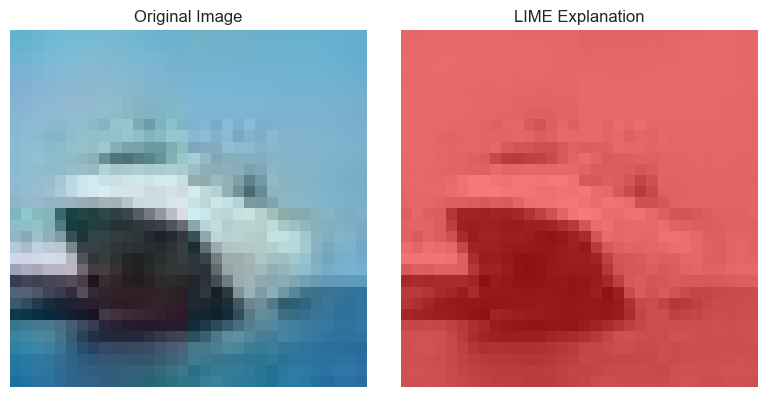

  0%|          | 0/1000 [00:00<?, ?it/s]

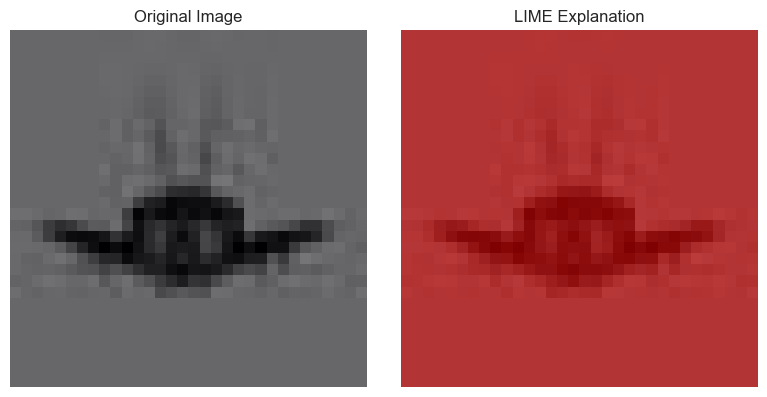

In [128]:
for i in range(len(real2)):
    lime_mapper(model, image_path=real2[i][0])

For Lime will need to verify class predictions